In [1]:

import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

import anndata
import scanpy as sc

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import kneighbors_graph

import igraph as ig
import leidenalg as la


In [2]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [3]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [142]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Import data**

In [691]:
tokeep = ['Tcells','Monocytes','Bcells']

chosen = [tokeep] #[['L5_IT','L2-3_IT','L6_IT'],['L6_CT','L2-3_IT','L6_IT']] 
individs = []
for names in chosen:
    individs += [[i] for i in names]

In [692]:
num_ks = 5
ks = [1,3,5,10,15] #1,4,10

In [693]:
dataset_meta = ['pbmc_10k_v3']

subcluster_names = []
for r in range(len(chosen)):
    subcluster_names += [chosen[r]]*num_ks

subcluster_names += individs

sub_names_only = ['_'.join(n) for n in subcluster_names]
for i in range(len(ks)):
    sub_names_only[i] = sub_names_only[i]+'_k'+str(ks[i])
    
cluster_names = []

#cluster_names = ['Tcells','Monocytes','Bcells']

dataset_names = [x+'_'+y for x in dataset_meta for y in sub_names_only]  
raw_data_locations = [x for x in dataset_meta for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/10x_pbmcs/loom/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)

In [694]:
dataset_names

['pbmc_10k_v3_Tcells_Monocytes_Bcells_k1',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k3',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k5',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k10',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k15',
 'pbmc_10k_v3_Tcells',
 'pbmc_10k_v3_Monocytes',
 'pbmc_10k_v3_Bcells']

In [695]:
# markers = ['CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5',
#       'CD93','CSTA','FPR1','CD14','CD36',
#       'CD79A','CD22','BLK','IGHD','VPREB3']

#From Cell Atlas - cite Angel/Sina
all_marks = pd.read_csv('/home/tchari/metadata/all_pbmc_markers.csv')
print(all_marks.head())

#From lit + https://satijalab.org/seurat/articles/pbmc3k_tutorial.html
toplot_marks = ['CD300E','FCGR2B','CD40',
                'CD69','MS4A1','CD79A','PTPRC',
                'CD3D','IL7R','LEF1','TRAC','CD4','CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5',
      'CD93','CSTA','FPR1','CD14','CD36',
      'CD79A','CD22','BLK','IGHD','VPREB3','CD28','IRF4','CCR6','GATA3','IL2RA','FOXP1','CD38',
               'CX3CR1','CD86','ADGRE1'] + ['CD14','FCGR3A','FCGR3B','CCR2','CCR5','CCR7',
'CD69','ITGAE','CTLA4','NCAM1','FOXP3','STAT4', 'TCF7','IL26',
'IL22','IL13','KLRB1','CXCR3','CD38',
'CLEC9A','ITGAX','XCR1','CD1C','CD207','ITGAM', 'NOTCH2',
'BATF3','CCR7','CD8A','CD8B',
'BCL2','BCL6','CD5','CD27','CD79B','SDC1','TLR9','XBP1','GZMB','IL3RA','CD74',
'IL7R', 'CCR7','LYZ','S100A4','GNLY', 'NKG7','FCER1A', 'CST3','PPBP','PF4'] 

markers = list(all_marks['gene_name']) + toplot_marks #Added

markers = list(np.unique(markers)) #Added

print(len(markers))

  gene_name  num_cell_types
0     PTPRC              28
1      CD14              27
2     IL-7R              24
3      CD3D              24
4    FCG3RA              23
2357


In [696]:
annots=pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header=None)
print(annots.head())

filt_markers = [m for m in markers if m in list(annots[0])]
len(filt_markers)

       0      1    2   3   4   5   6   7   8   9   ...  39  40  41  42  43  \
0    TNMD  14950   48  23  10   5   2   2   2   2  ...   0   0   0   0   0   
1    DPM1  23689   98  38  25  17  10   6   5   5  ...   0   0   0   0   0   
2   SCYL3  44637  132  51  20  13   9   7   6   4  ...   0   0   0   0   0   
3  TSPAN6  12884   43  18  13   8   3   2   2   1  ...   0   0   0   0   0   
4     FGR  23122   41  18   8   4   1   1   1   1  ...   0   0   0   0   0   

   44  45  46  47  48  
0   0   0   0   0   0  
1   0   0   0   0   0  
2   0   0   0   0   0  
3   0   0   0   0   0  
4   0   0   0   0   0  

[5 rows x 49 columns]


2011

In [697]:
dups = ['FCGR2C','GGTA1P', 'ANKRD36BP1', 'HSPA7','HLA-DRB4','HLA-DRB3','HLA-DPB2','GVINP1',
'ANXA2P2','DENND10P1','CES1P1','CORO7-PAM16','CRYM-AS1','WHAMMP3','SUZ12P1','STING1', 
'STAG3L1','STAG3L3','STAG3L4', 'TM4SF19-TCTEX1D2','KDM5D','LCT-AS1','KIR2DS2','KIR2DS5',
'KIR3DS1','PMS2P5','PALM2AKAP2','NCF1B','NCF1C']
filt_markers = [i for i in filt_markers if i not in dups]
len(filt_markers)

1982

In [698]:
len([i for i in toplot_marks if i in filt_markers])

92

In [699]:
#Filter again for acceptable U/S bounds
#Read in loom + layers
ds = lp.connect('/home/tchari/counts/10x_pbmcs/loom/pbmc_10k_v3.loom')
s = ds.layers['spliced'][:,:]
u = ds.layers['unspliced'][:,:]
g_names = ds.ra['gene_name']

filt_param={
        "min_U_mean": 0.01,
        "min_S_mean": 0.01,
        "max_U_max": 400,
        "max_S_max": 400,
        "min_U_max": 3,
        "min_S_max": 3,
    }

expr_filt = monod.preprocess.threshold_by_expression(s,u,filt_param)
ds.close()

INFO:root:5887 genes retained after expression filter.


In [700]:
fin_markers = set(filt_markers).intersection(list(g_names[expr_filt]))
len(fin_markers)

1082

In [701]:
len([i for i in toplot_marks if i in fin_markers])

58

In [702]:
fin_markers = list(fin_markers)

## **Filter Cells/Barcodes**

In [703]:
cluster_annotations = []
for k in range(len(dataset_meta)):
    cluster_assignments = pd.read_csv(f'/home/tchari/metadata/{dataset_meta[k]}_analysis/analysis/clustering/kmeans_4_clusters/clusters.csv')
    print(cluster_assignments['Barcode'].str[-1:].unique())
    cluster_assignments['Barcode'] = cluster_assignments['Barcode'].str[:-2]
    cluster_annotations.append(cluster_assignments)

['1']


In [704]:
clus_names = dict(zip([1,2,3,4],['Tcells','Monocytes','Bcells','Other']))
clus_names

{1: 'Tcells', 2: 'Monocytes', 3: 'Bcells', 4: 'Other'}

In [705]:
cluster_annotations[0]['Cluster_name'] = [clus_names[i] for i in cluster_annotations[0]['Cluster']]
cluster_annotations[0].head()

Barcode  Cluster Cluster_name
0  AAACCCAAGCGCCCAT        1       Tcells
1  AAACCCAAGGTTCCGC        2    Monocytes
2  AAACCCACAGAGTTGG        2    Monocytes
3  AAACCCACAGGTATGG        1       Tcells
4  AAACCCACATAGTCAC        3       Bcells

Dataset pbmc_10k_v3. 
	11756 barcodes in loom, 11171 pass filter. 11769 in annotations; of these, 11536 in loom and 11121 in filtered loom.
	['Tcells', 'Monocytes', 'Bcells']: 10999 cells in annotations. 10997 in loom. 10913 pass filter.
	['Tcells', 'Monocytes', 'Bcells']: 10999 cells in annotations. 10997 in loom. 10913 pass filter.
	['Tcells', 'Monocytes', 'Bcells']: 10999 cells in annotations. 10997 in loom. 10913 pass filter.
	['Tcells', 'Monocytes', 'Bcells']: 10999 cells in annotations. 10997 in loom. 10913 pass filter.
	['Tcells', 'Monocytes', 'Bcells']: 10999 cells in annotations. 10997 in loom. 10913 pass filter.
	['Tcells']: 5376 cells in annotations. 5375 in loom. 5339 pass filter.
	['Monocytes']: 3973 cells in annotations. 3972 in loom. 3933 pass filter.
	['Bcells']: 1650 cells in annotations. 1650 in loom. 1641 pass filter.


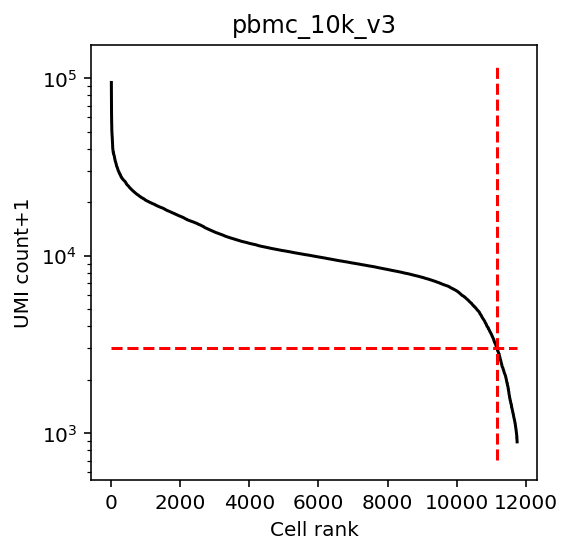

In [706]:
cf = []
thr_lb = [3e3]
fig1,ax1 = plt.subplots(1,1,figsize=(4,4))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(subcluster_names)*k ]
    dataset_name = raw_data_locations[len(subcluster_names)*k ]
    
    clusters = cluster_annotations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1,viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(clusters)
        annot_bcs_in_loom = clusters['Barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = clusters['Barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        for j,cluster in enumerate(subcluster_names):
            annot_bcs = clusters[clusters['Cluster_name'].isin(cluster)]['Barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')

    ax1.set_title(dataset_name)

In [707]:
all_assigns = [list(clusters['Cluster_name'][clusters['Barcode'] == i])[0] for i in bcs[cf[0]]]
print(len(all_assigns)) 

10913


In [235]:
# #Select for hvgs
# adata = sc.read_loom('/home/tchari/counts/10x_pbmcs/loom/pbmc_10k_v3.loom') #sc
# bars = bcs[cf[0]]
# adata_sub = adata[adata.obs['barcode'].isin(bars)]
# adata_sub
#

In [102]:
# sc.pp.normalize_total(adata_sub, target_sum=1e4)
# sc.pp.log1p(adata_sub)
# sc.pp.highly_variable_genes(adata_sub, n_top_genes=2000, min_mean=0.0125, max_mean=3, min_disp=0.5)

# # Subset to highly variable genes
# adata_hvg = adata_sub[:, adata_sub.var.highly_variable]

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [103]:
# #adata_hvg = adata_sub
# adata_hvg.layers['spliced'].shape

(10913, 1999)

In [104]:
# hvgs = adata.var['gene_name'][adata_sub.var.highly_variable]
# len(hvgs)

1999

## **Gene Filtering**

In [708]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1 already exists.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k1
INFO:root:10913 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:5814 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k1 already exists.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k3
INFO:root:10913 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:5814 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3 already exists.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k5
INFO:root:10913 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:5814 genes retained

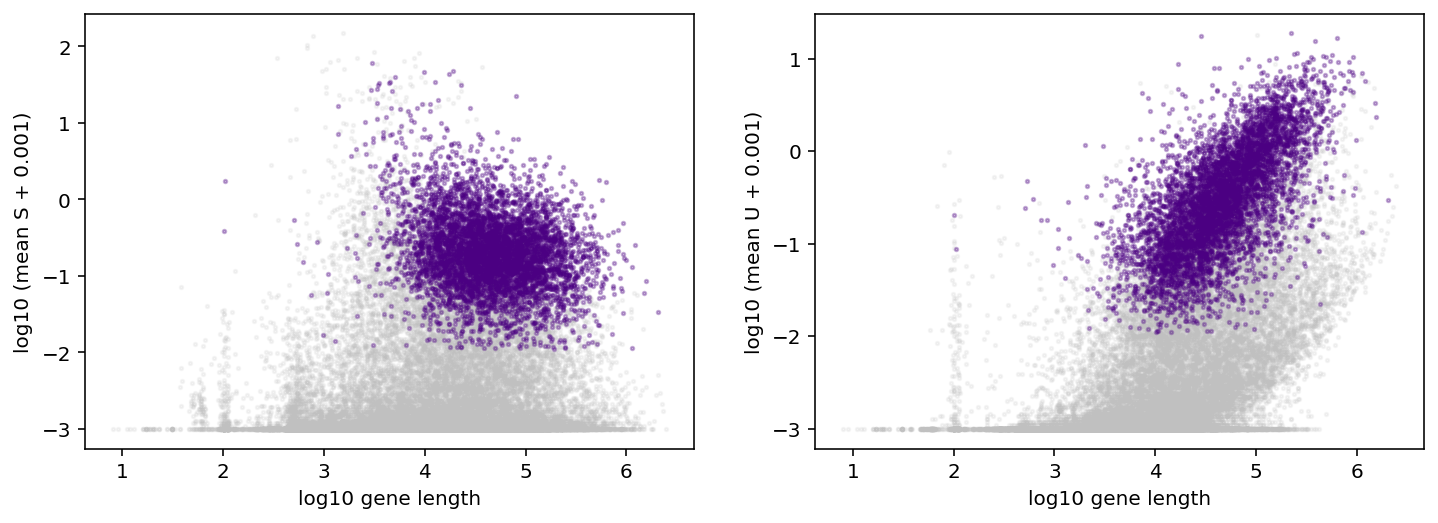

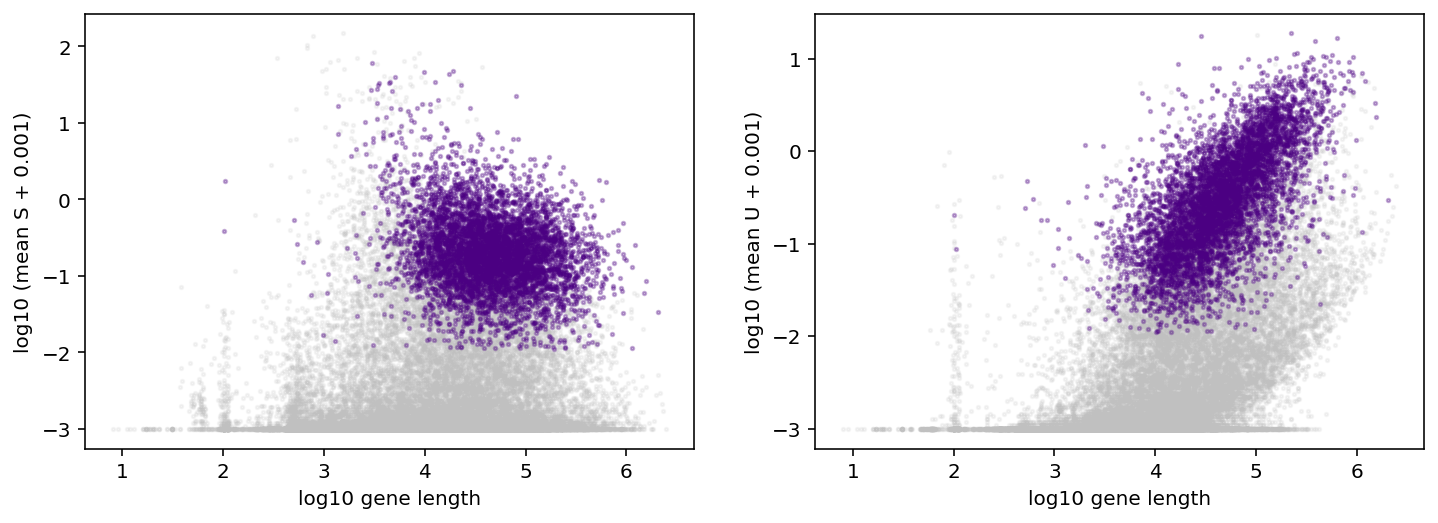

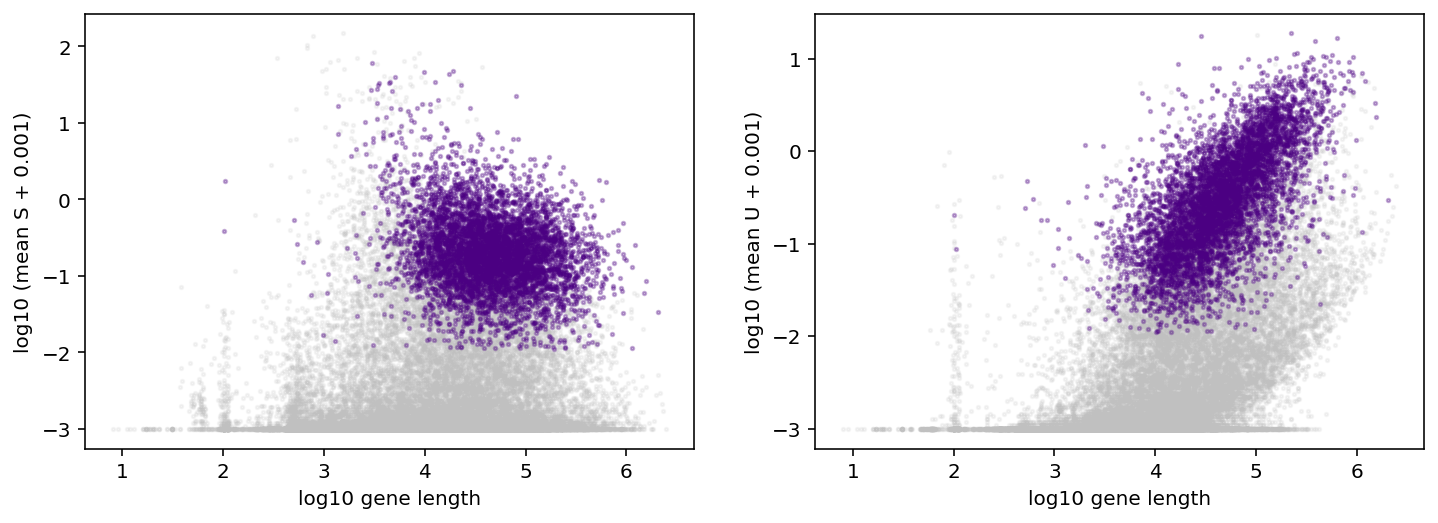

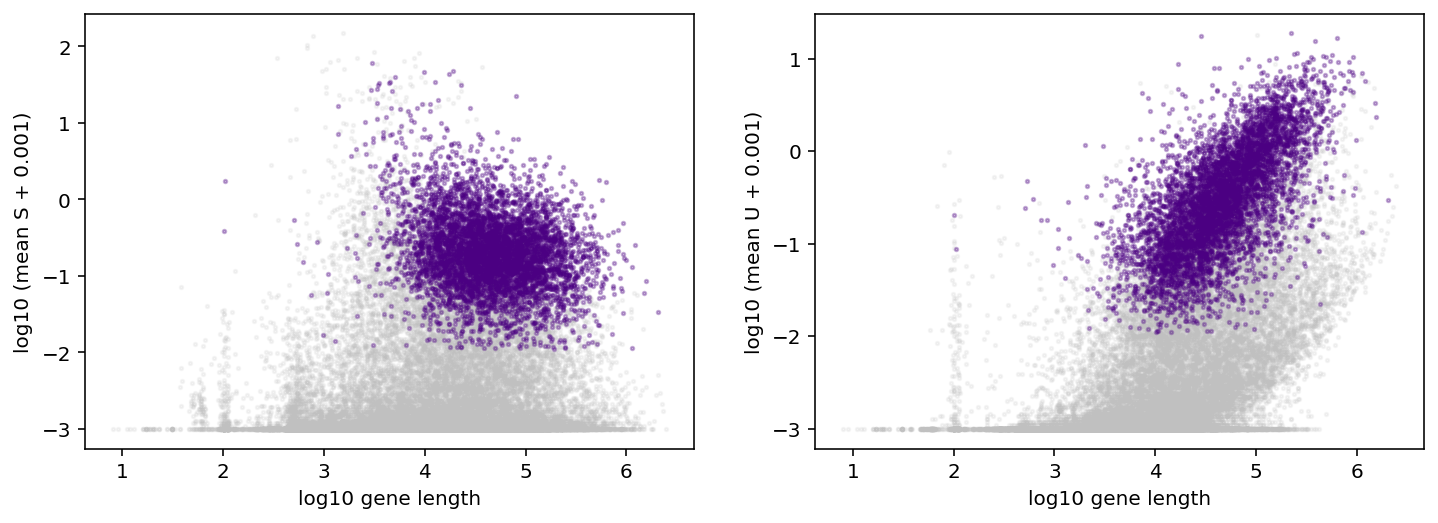

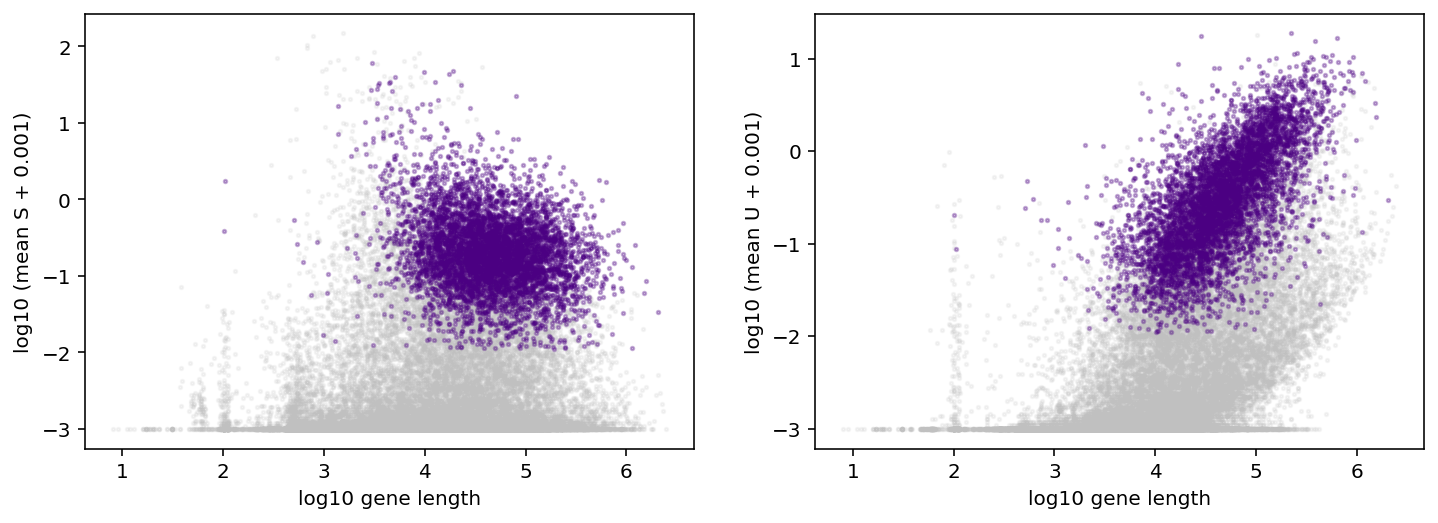

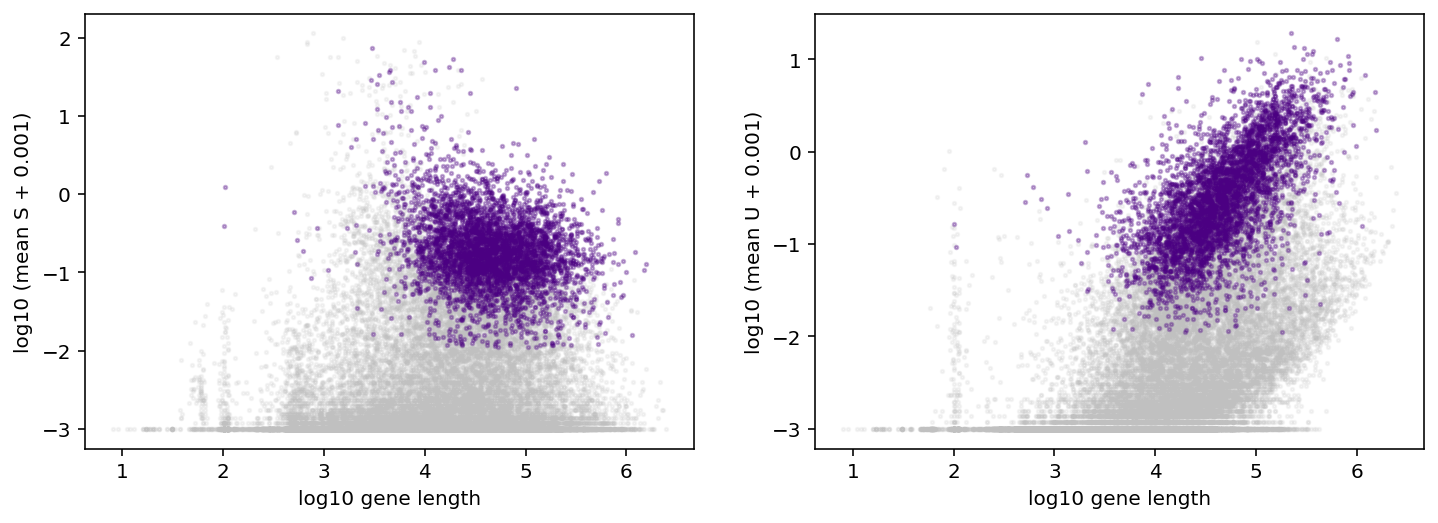

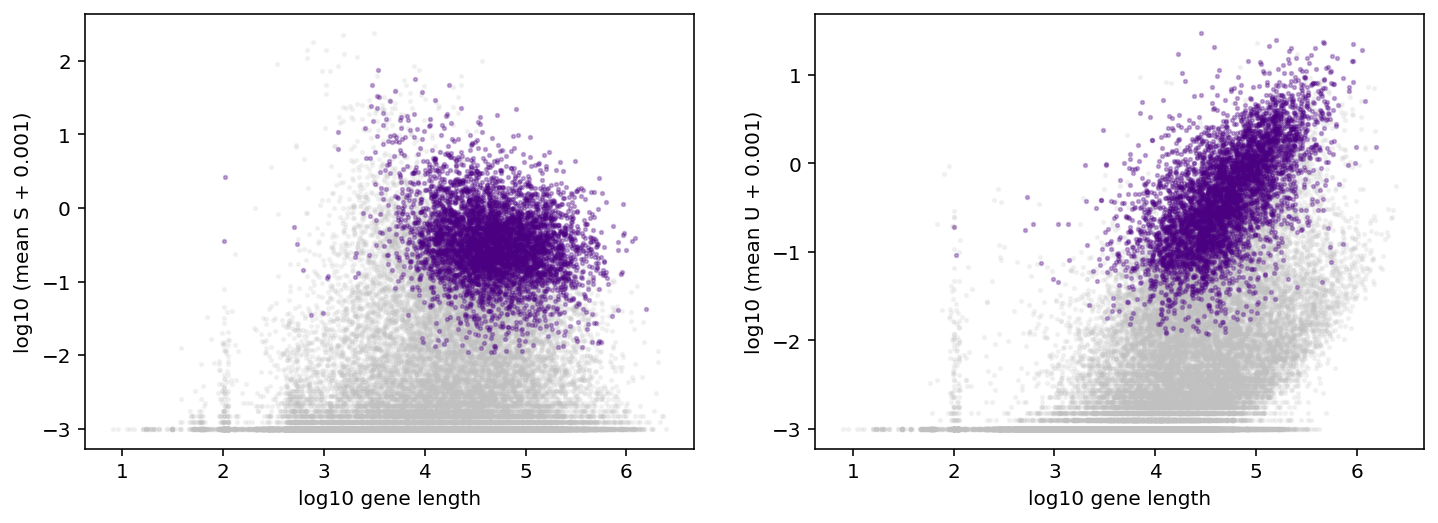

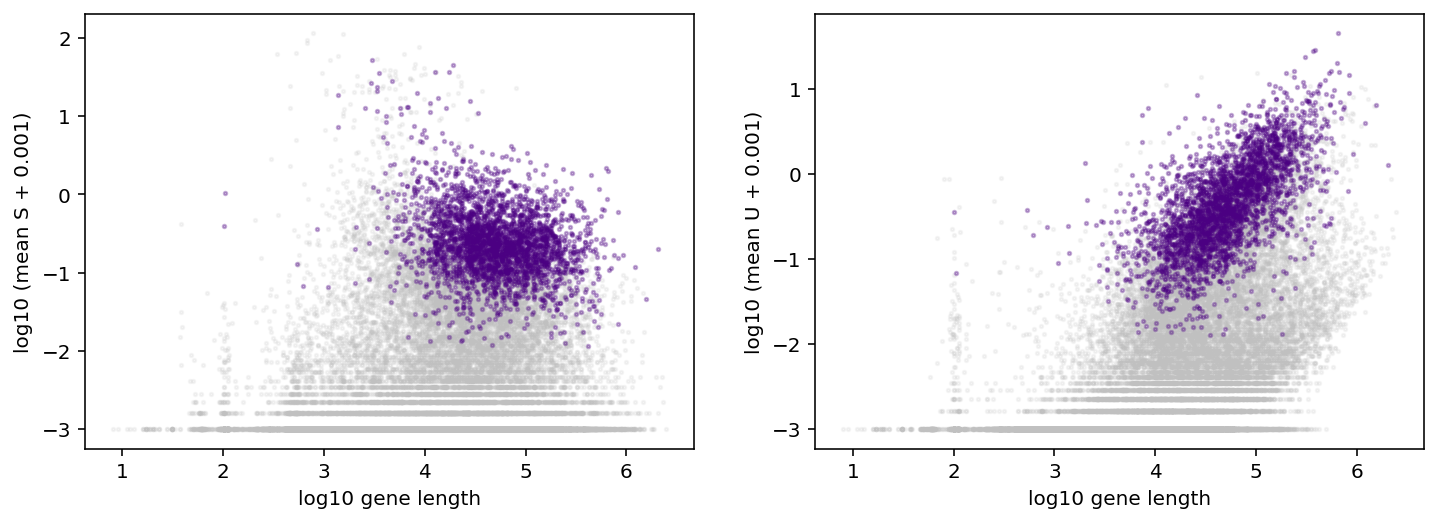

In [709]:
#Get genes.csv
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='pbmc_MM',batch_id=1,\
                                             datestring='230501', n_genes=1000,\
                                             exp_filter_threshold=None,cf=cf) 
#hvgs,1900, 2000

In [710]:
dir_string = './fits/gg_230501_025_pbmc_MM_1' #230426,230425
dataset_strings = [ dir_string+'/'+item for item in dataset_names]
print(dataset_strings)

['./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k1', './fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3', './fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5', './fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k10', './fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k15', './fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells', './fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Monocytes', './fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Bcells']


Make genes.csv with known markers as well

In [711]:
sel_genes = pd.read_csv('./fits/gg_230501_025_pbmc_MM_1/genes.csv',header=None) #fin_markers
sel_genes.head()

0       1       2      3     4      5         6       7     8      9    \
0  VPS13D  KCNAB2  KLHL20  DHDDS  COPA  RNF11  RABGAP1L  NOTCH2  PUM1  RC3H1   

   ...    990      991    992    993    994      995  996   997      998  \
0  ...  SASH3  TRAPPC2  ZMAT1  APOOL  BRWD3  CYSLTR1  OGT  PDK3  SH3KBP1   

     999  
0  PRPS2  

[1 rows x 1000 columns]

In [712]:
first_sel = list(sel_genes.iloc[0])

In [713]:
remain = list((set(first_sel)^set(fin_markers))&set(first_sel))
for i in range(len(fin_markers)):
    sel_genes[i] = fin_markers[i]
    
# for i in range(len(fin_markers),1500): #For now ,remove extra genes from Monod selection
#     sel_genes[i] = remain[i-len(fin_markers)]
    
sel_genes.head()

0     1       2       3       4    5      6      7       8      9     \
0  SPATA5  TMPO  CEP170  ADGRE2  MIS18A  EVL  SORL1  ATAD2  SPTBN1  TSHZ2   

   ...  1072    1073    1074   1075   1076  1077  1078     1079    1080   1081  
0  ...  NCR1  CSNK1E  NECAP2  IL2RG  DDOST  RIDA  TRAC  HERPUD1  SCARF1  ISG20  

[1 rows x 1082 columns]

In [714]:
sel_genes.to_csv('./fits/gg_230501_025_pbmc_MM_1/genes.csv',header=None,index=None)

In [715]:
#Check looks ok
test = pd.read_csv('./fits/gg_230501_025_pbmc_MM_1/genes.csv',header=None)
test.head()

0     1       2       3       4    5      6      7       8      9     \
0  SPATA5  TMPO  CEP170  ADGRE2  MIS18A  EVL  SORL1  ATAD2  SPTBN1  TSHZ2   

   ...  1072    1073    1074   1075   1076  1077  1078     1079    1080   1081  
0  ...  NCR1  CSNK1E  NECAP2  IL2RG  DDOST  RIDA  TRAC  HERPUD1  SCARF1  ISG20  

[1 rows x 1082 columns]

Check k-means inits

In [716]:
all_groups_kmeans = []

INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k1
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230501_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k1/raw.sd.
(10913, 1082)
(10913, 1082)
(10913, 1082)
(10913, 1082)
(10913, 1082)


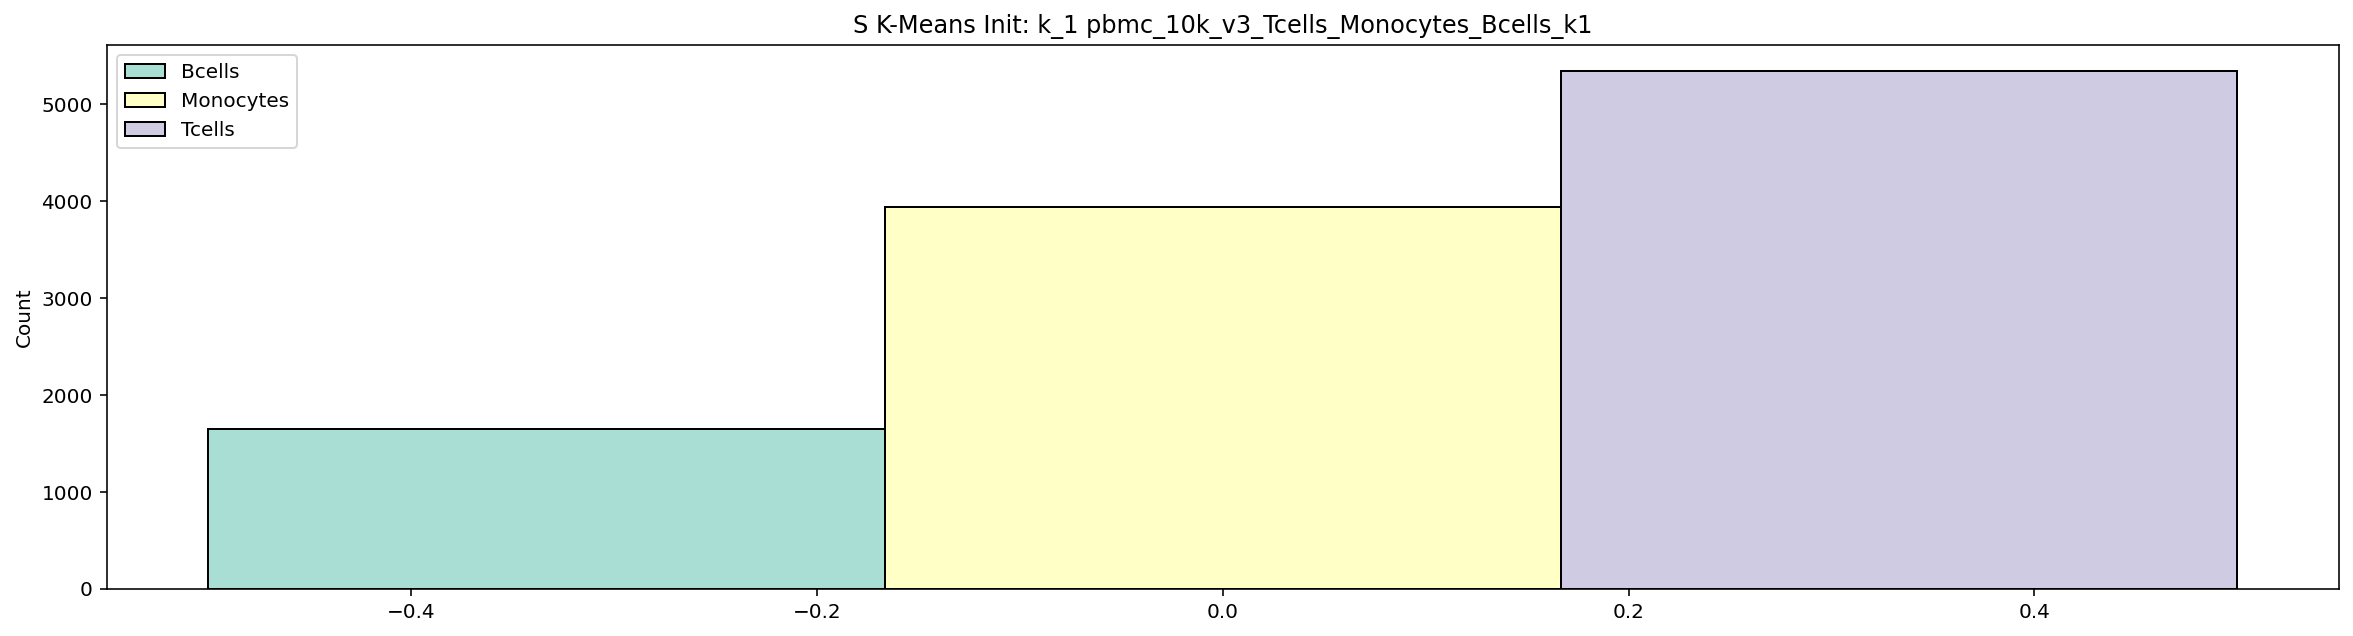

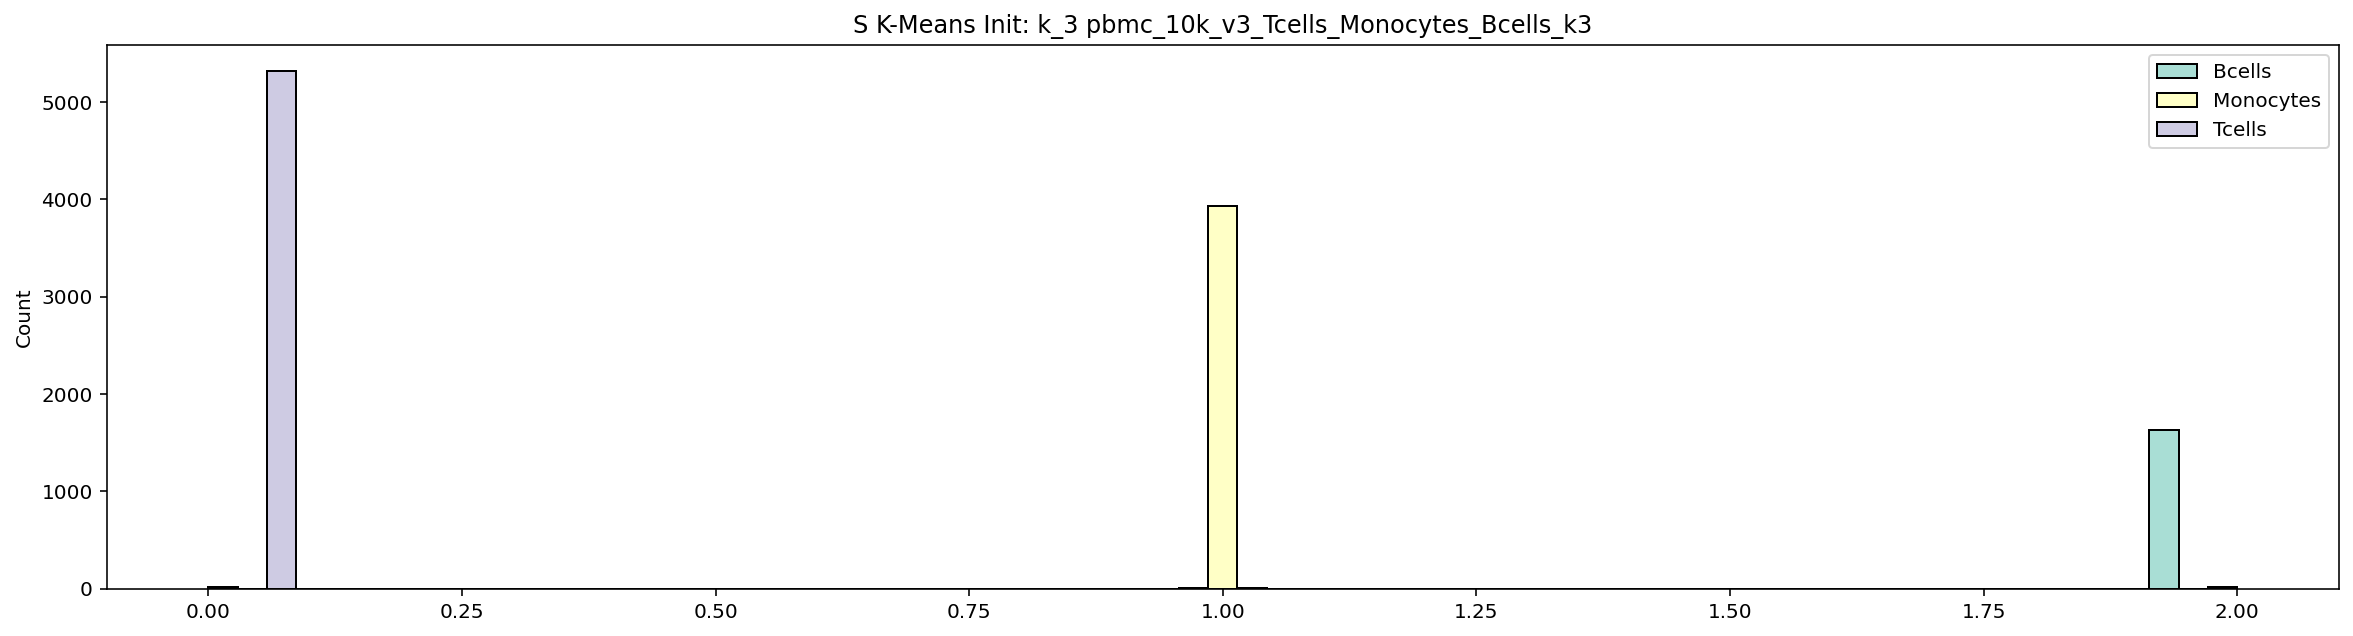

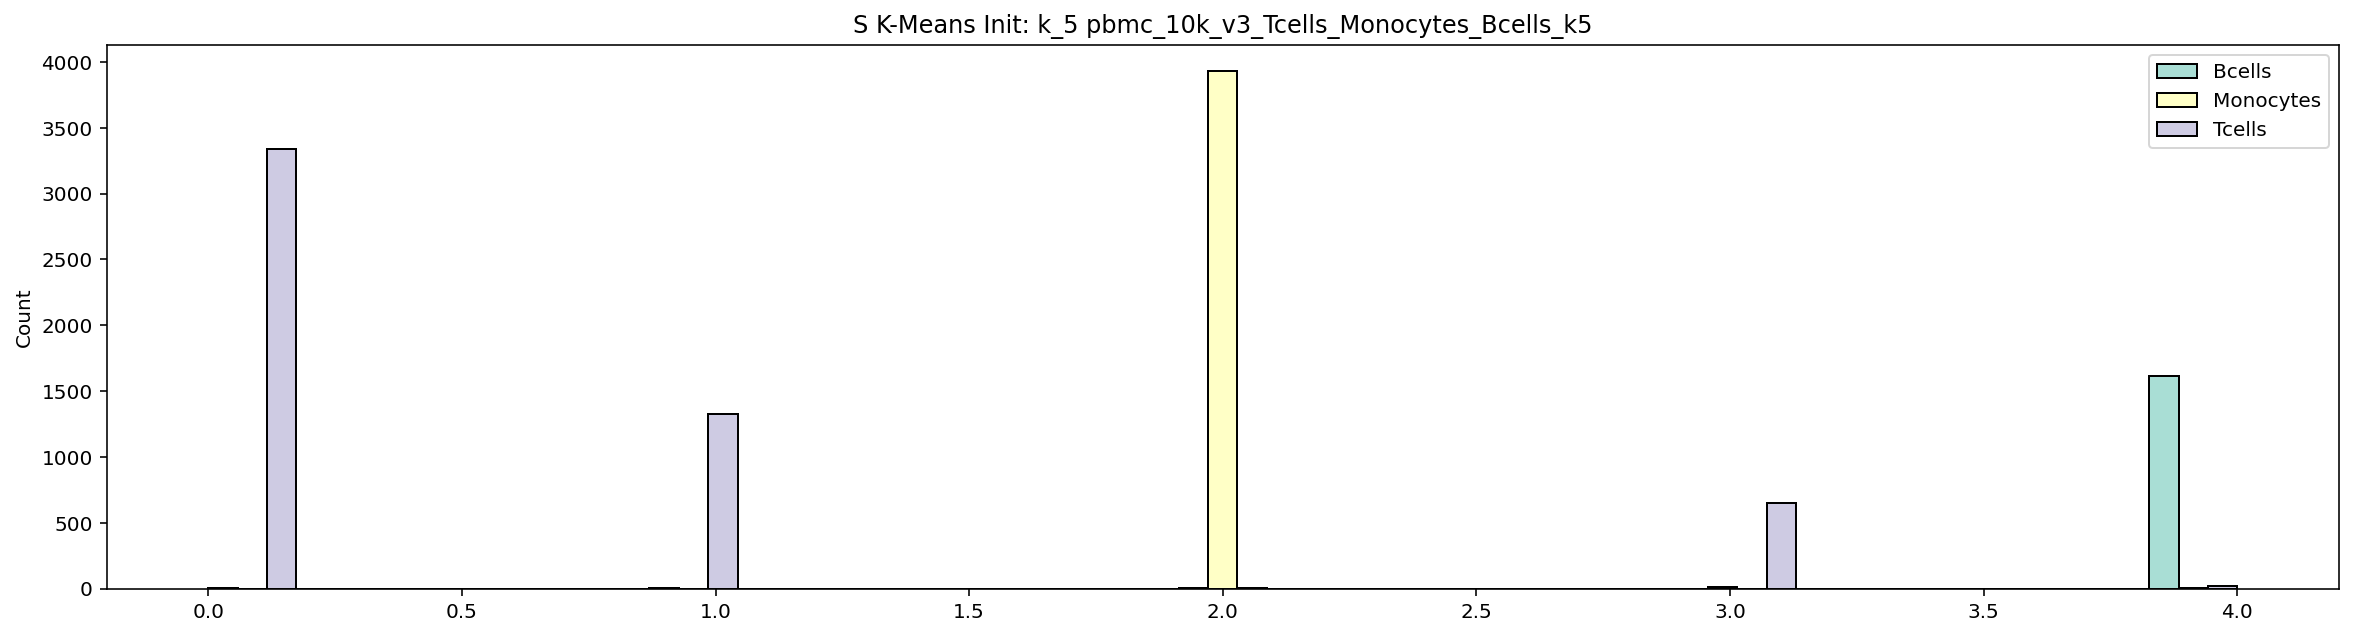

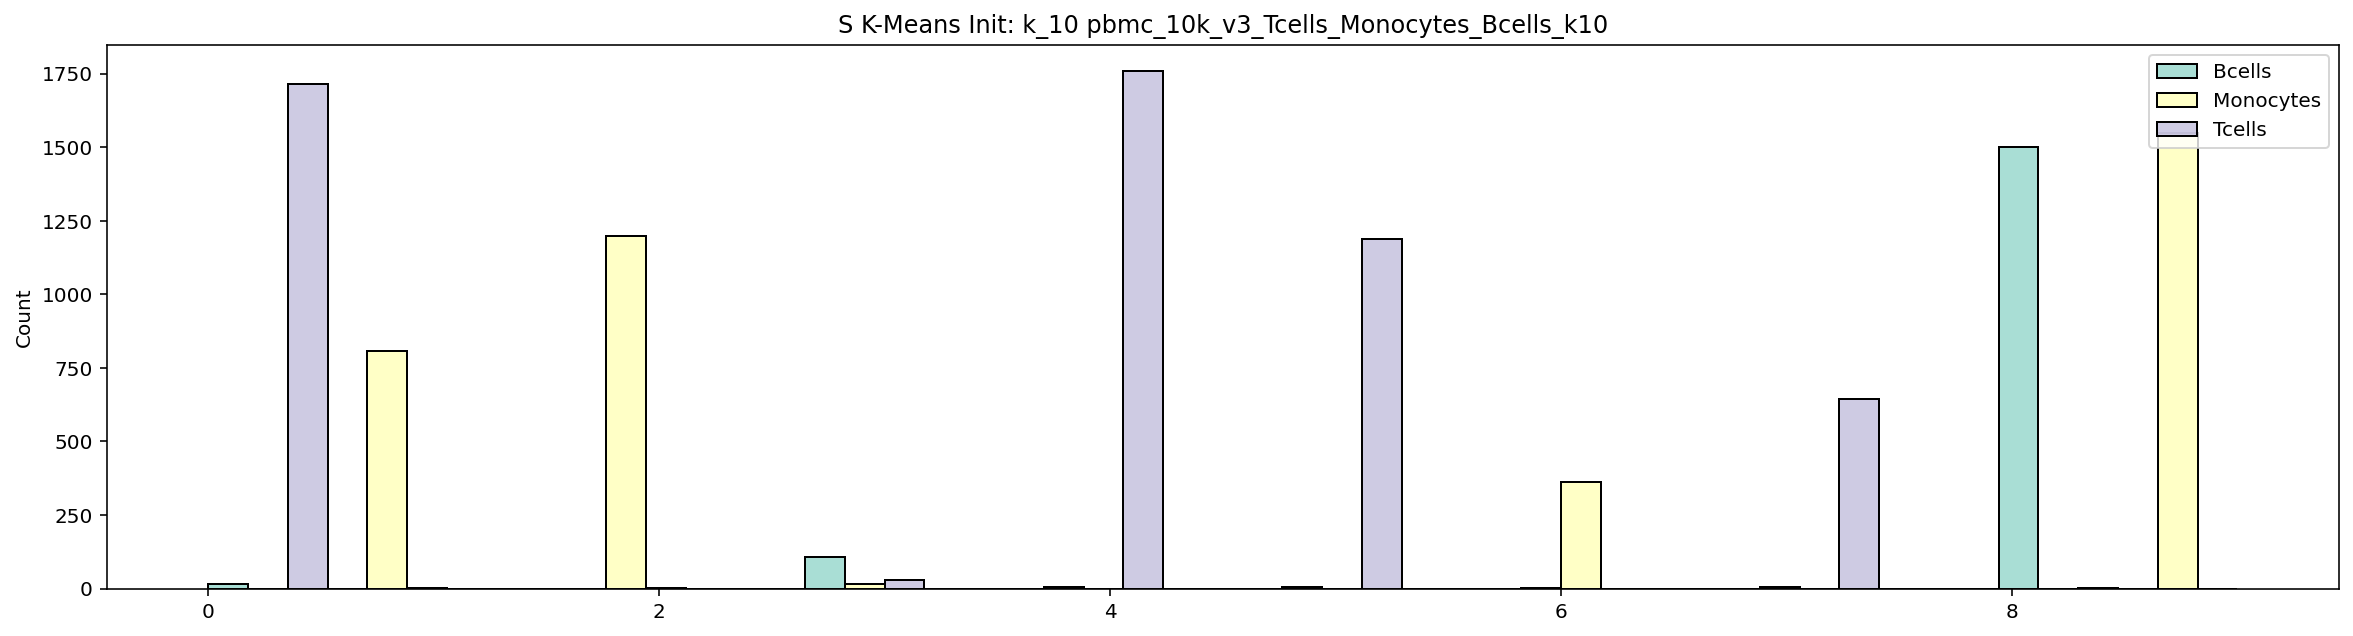

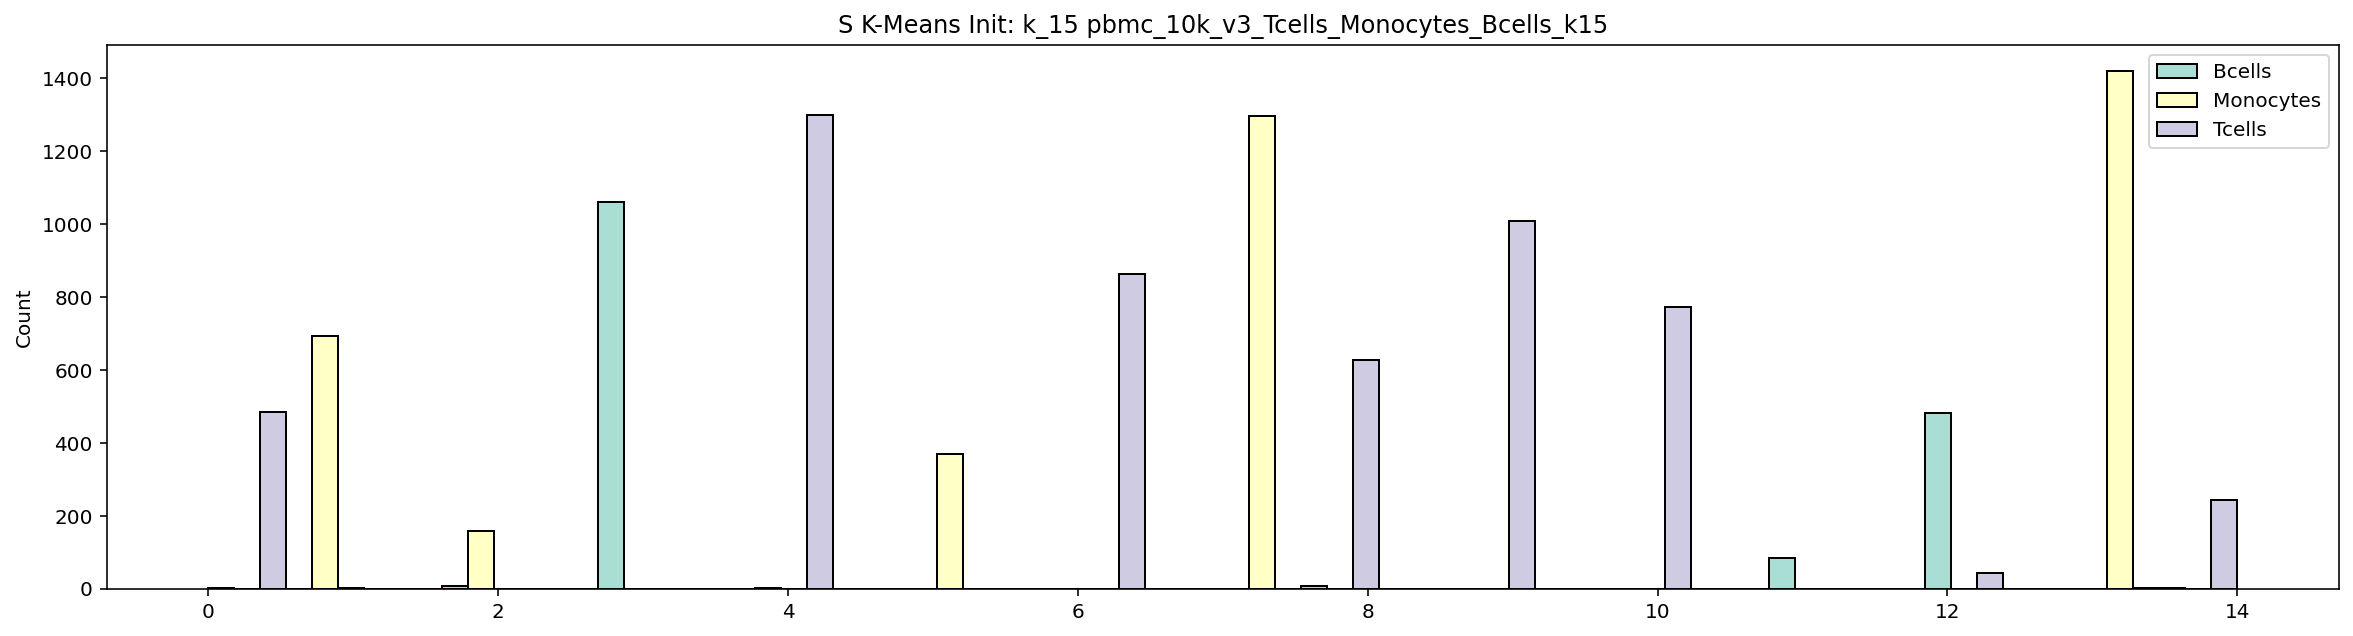

In [717]:
#For easier demonstration
#Check initializations of clusters
which = 0
search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

for i in range(num_ks):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)
    print(S_t.shape)

    kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
    labs = kmeans.labels_


    labels = labs
    all_groups_kmeans += [labs]
    
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Set3',multiple="dodge")
    plt.title('S K-Means Init: '+'k_'+str(ks[which])+' '+dataset_names[which])




(10913, 1082)
(10913, 1082)
(10913, 1082)
(10913, 1082)
(10913, 1082)


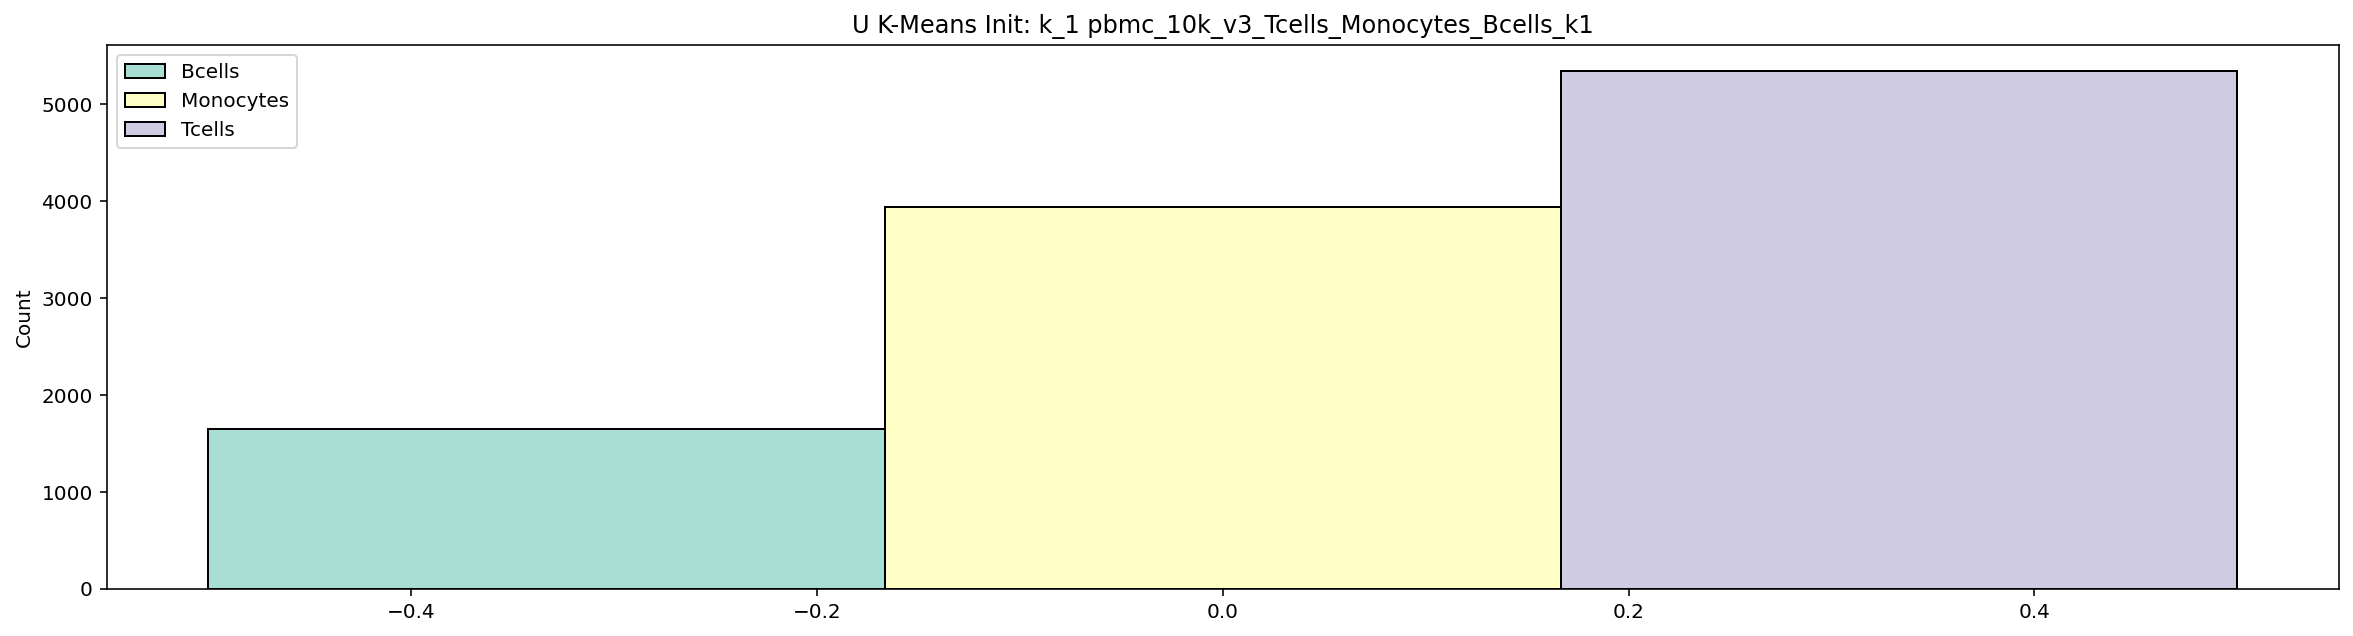

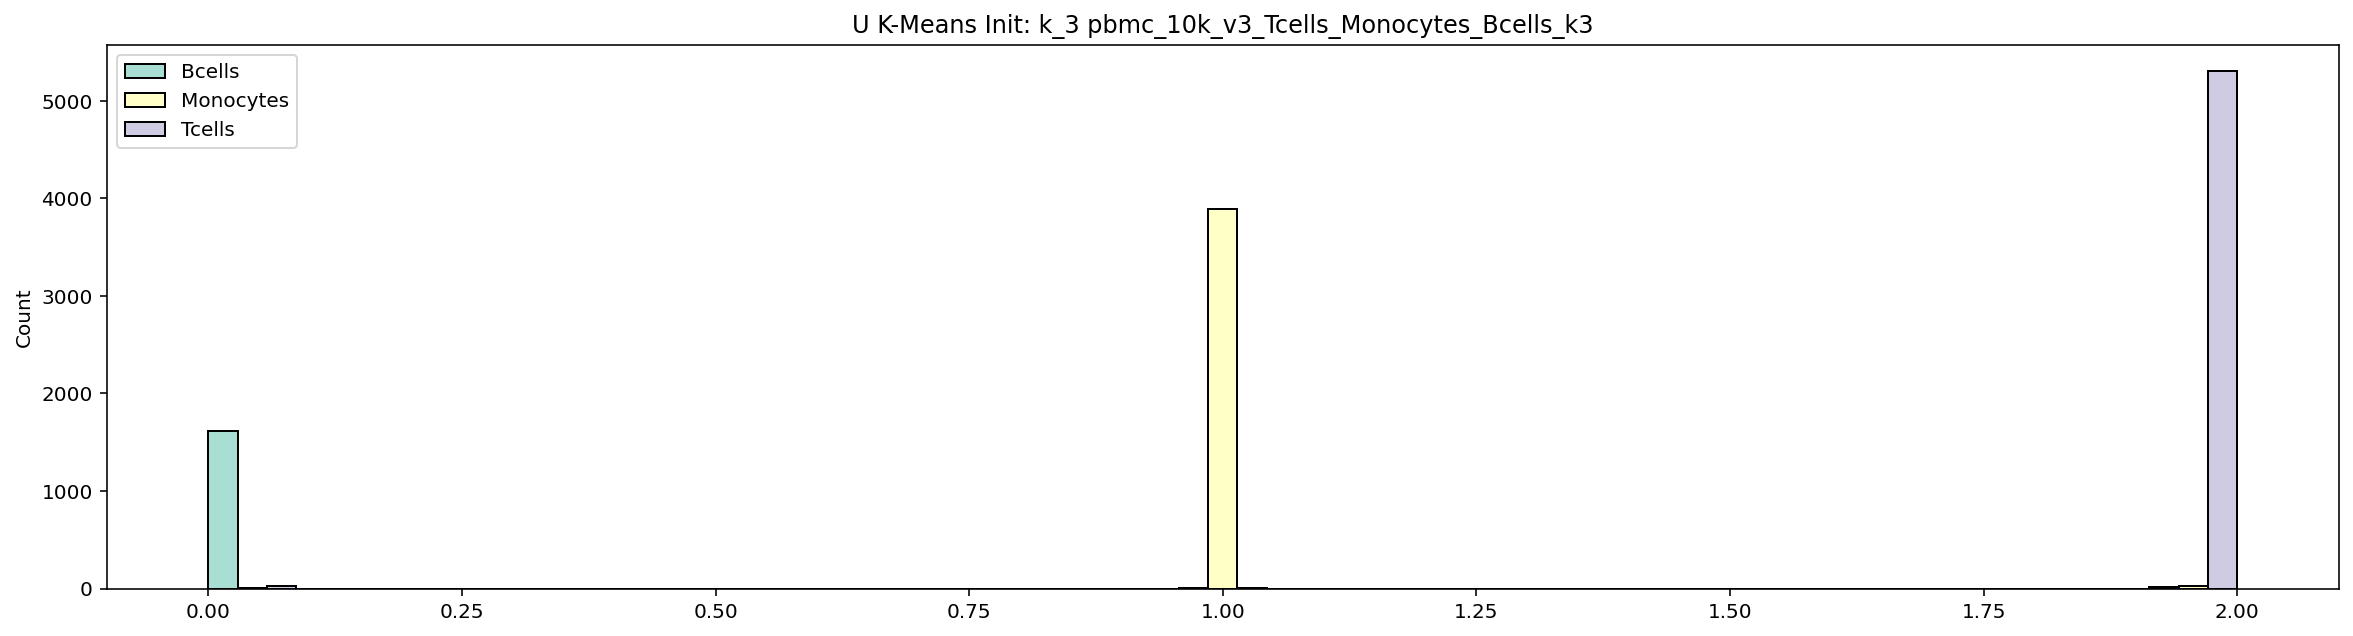

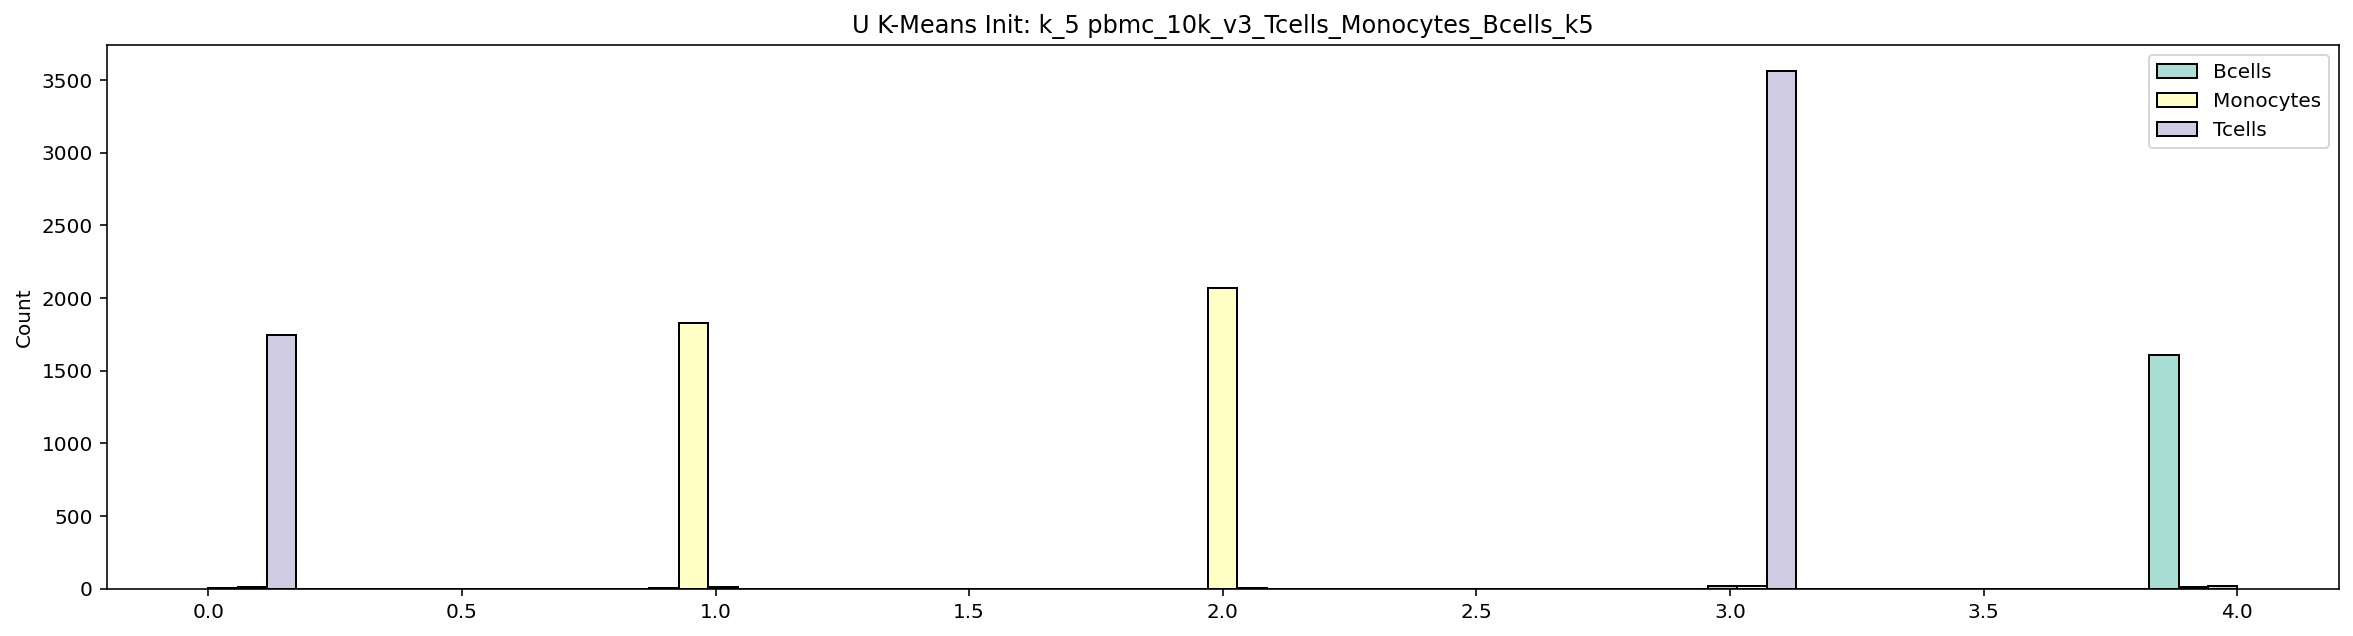

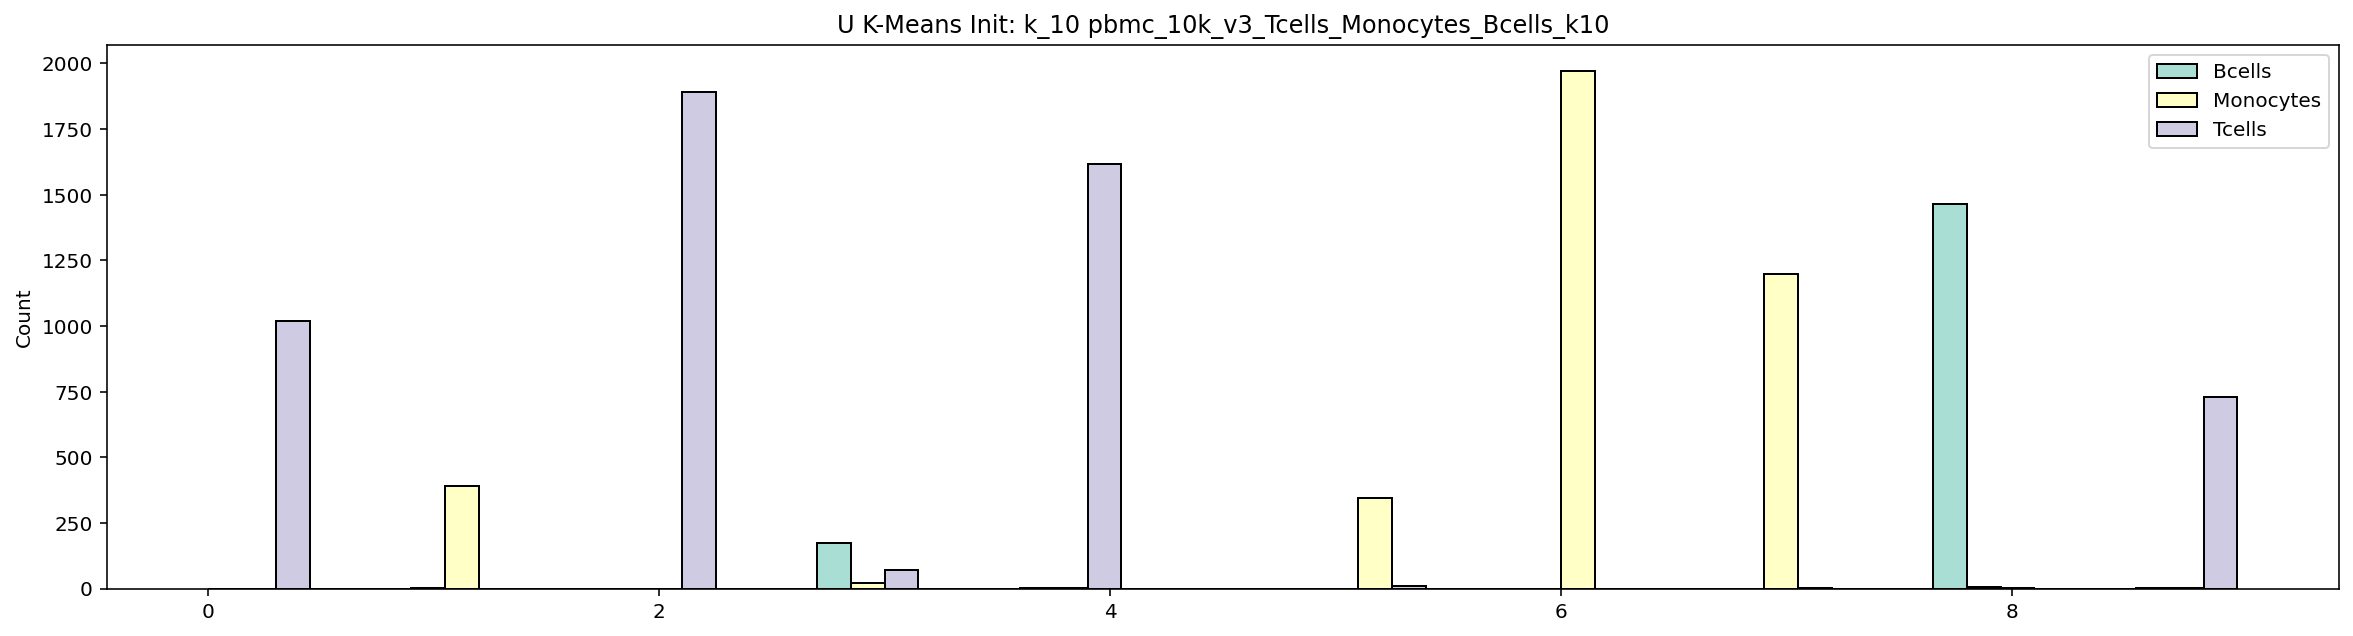

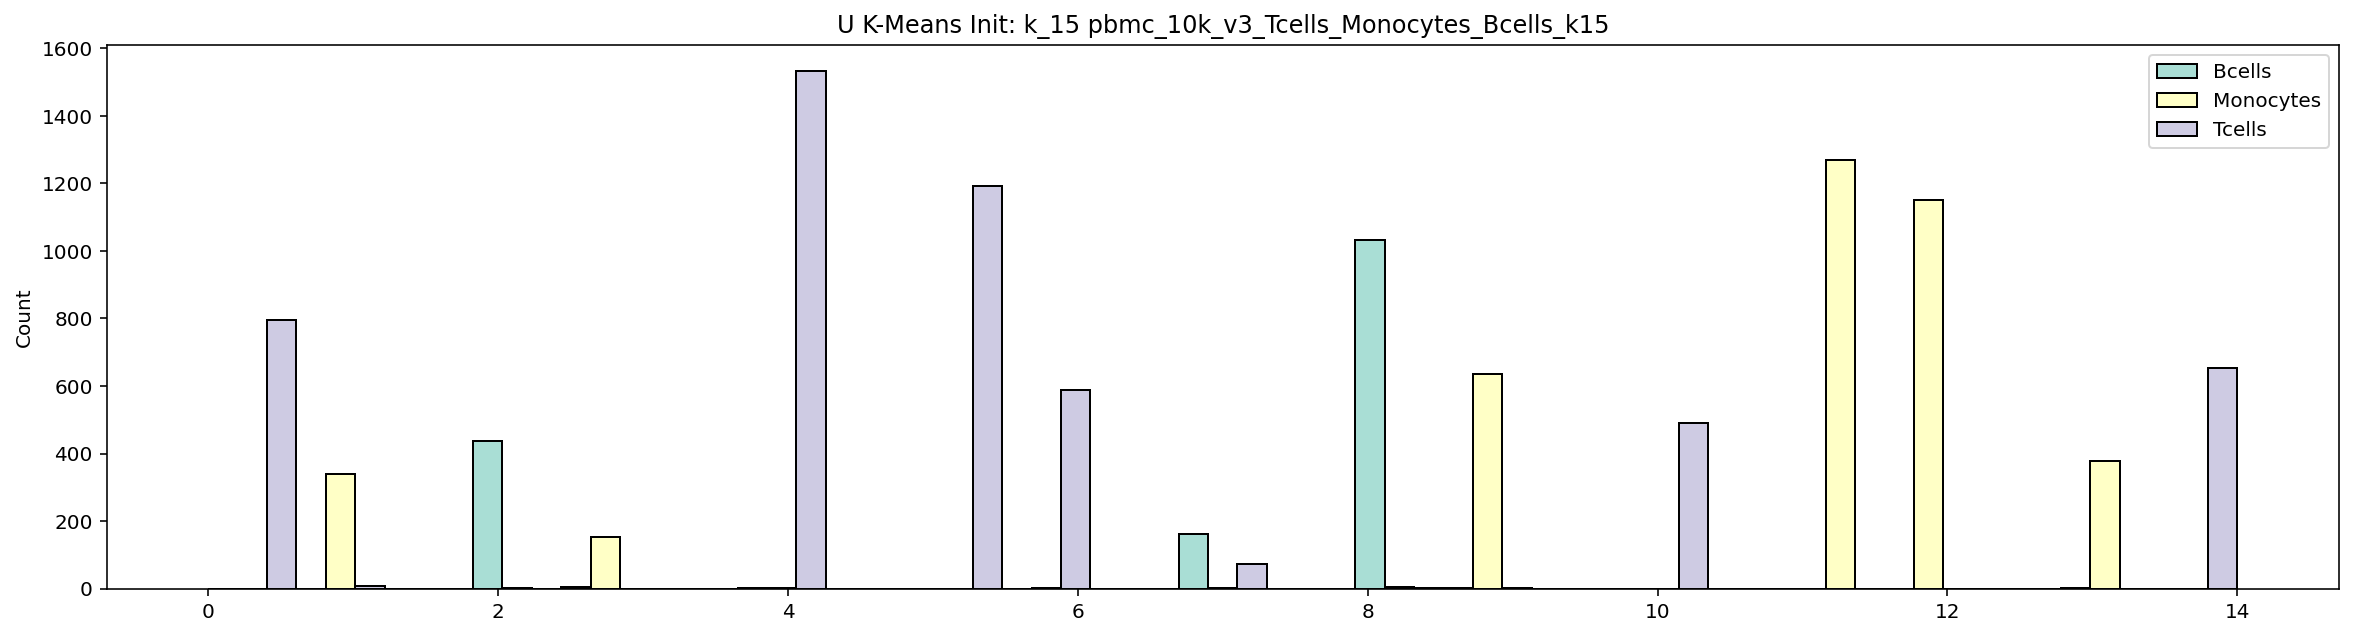

In [718]:
for i in range(num_ks):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)+1
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)
    print(S_t.shape)

    kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
    labs = kmeans.labels_


    labels = labs
    all_groups_kmeans += [labs] 
    
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Set3',multiple="dodge")
    plt.title('U K-Means Init: '+'k_'+str(ks[which])+' '+dataset_names[which])


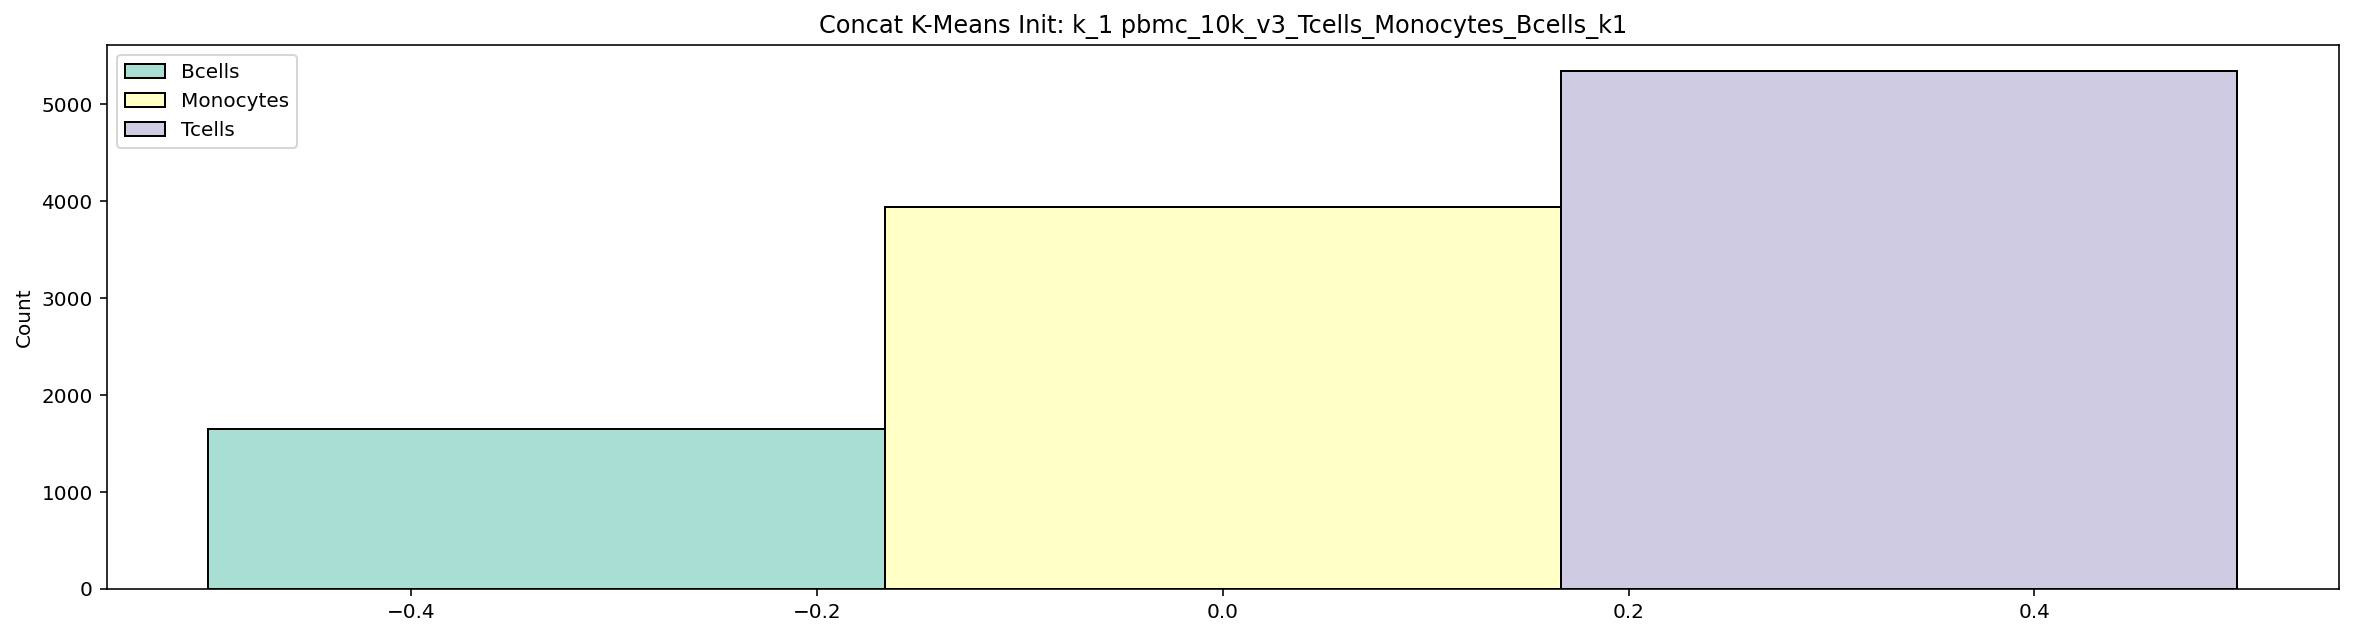

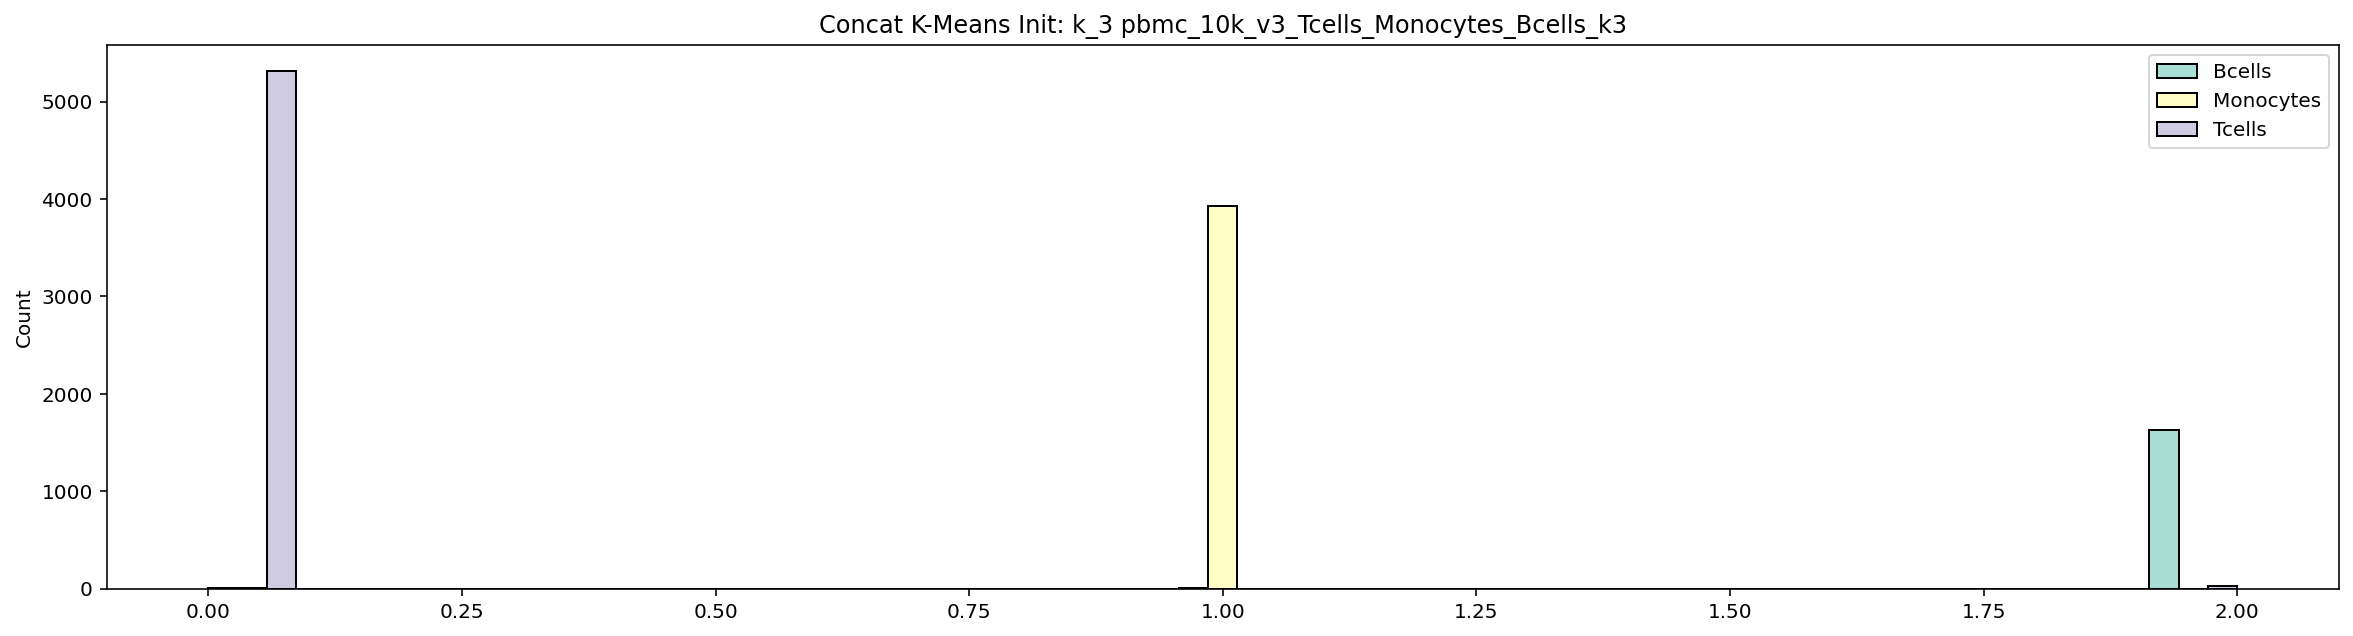

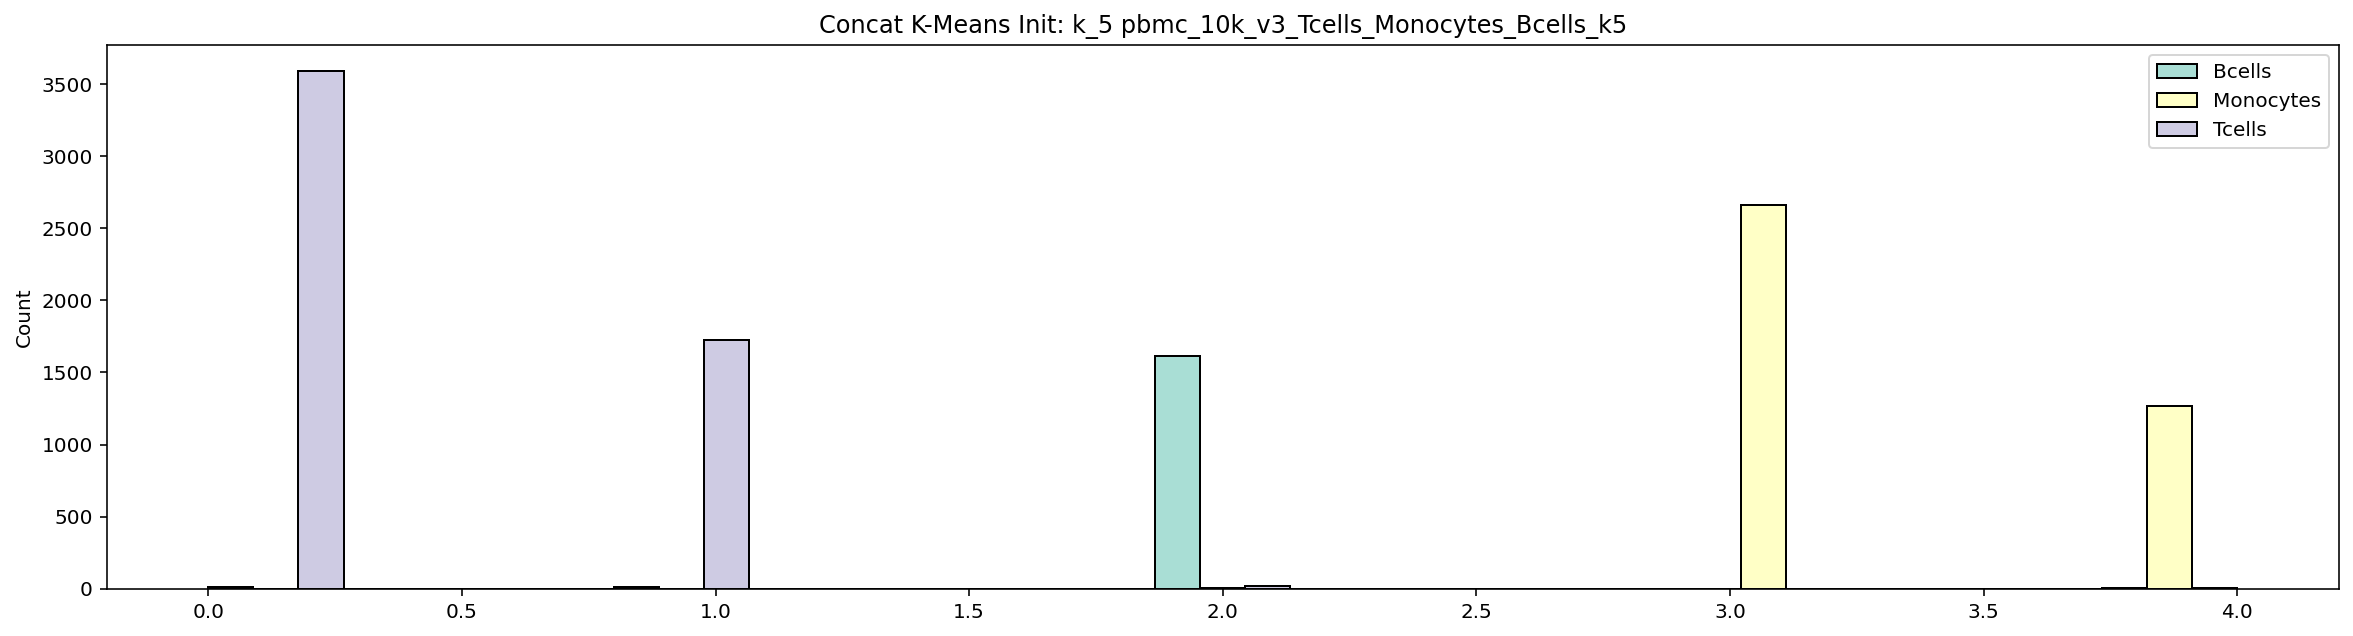

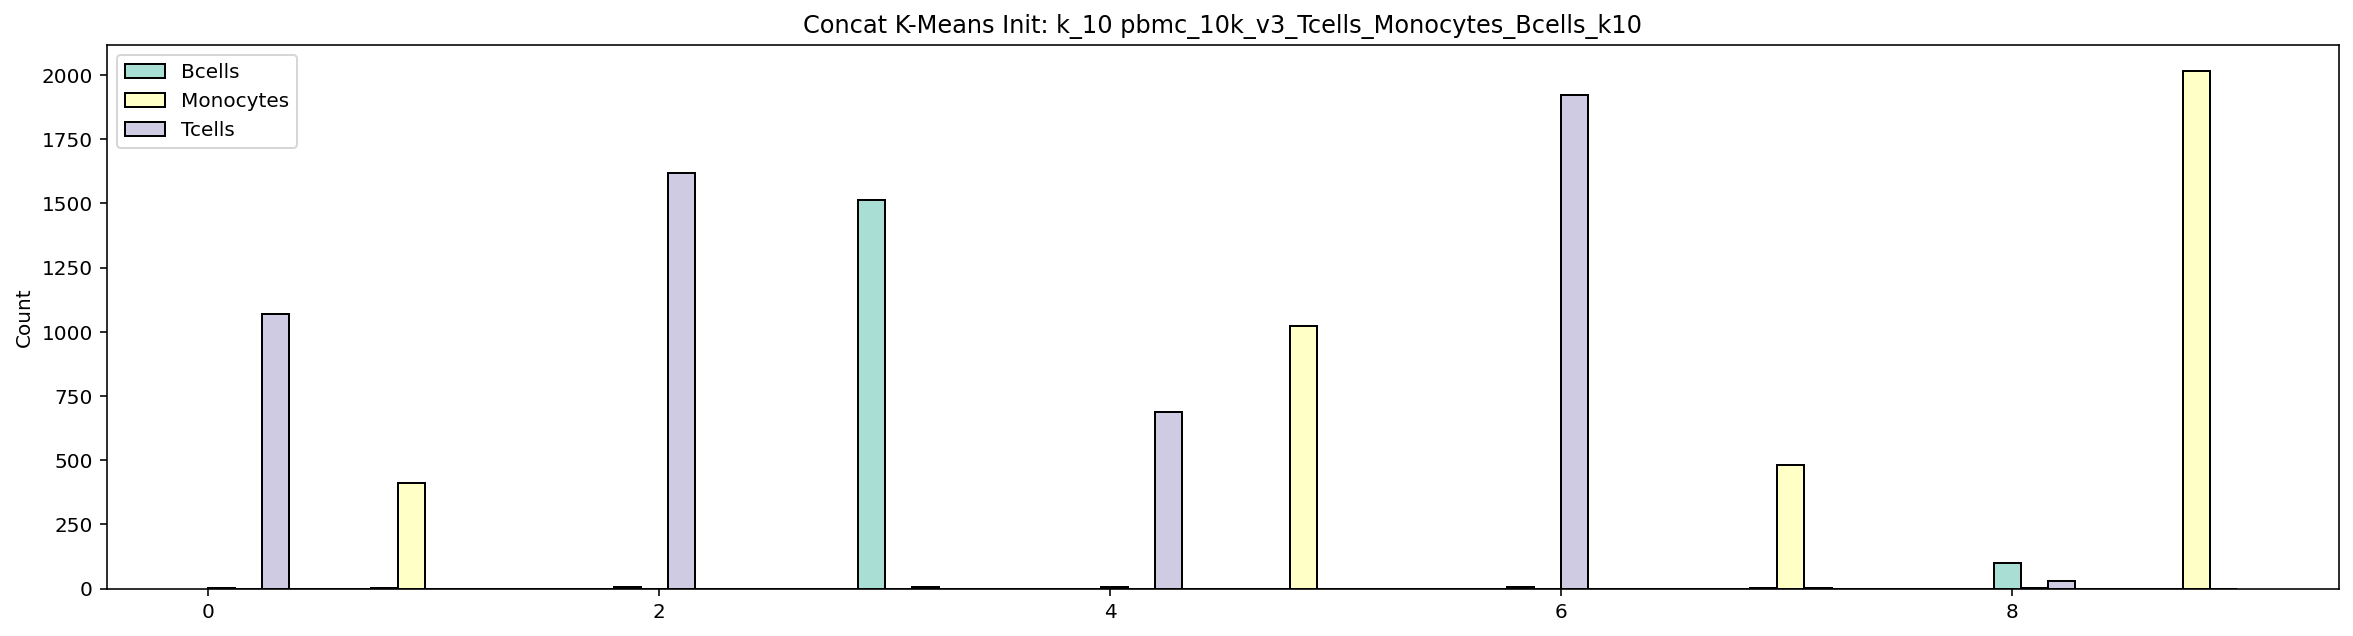

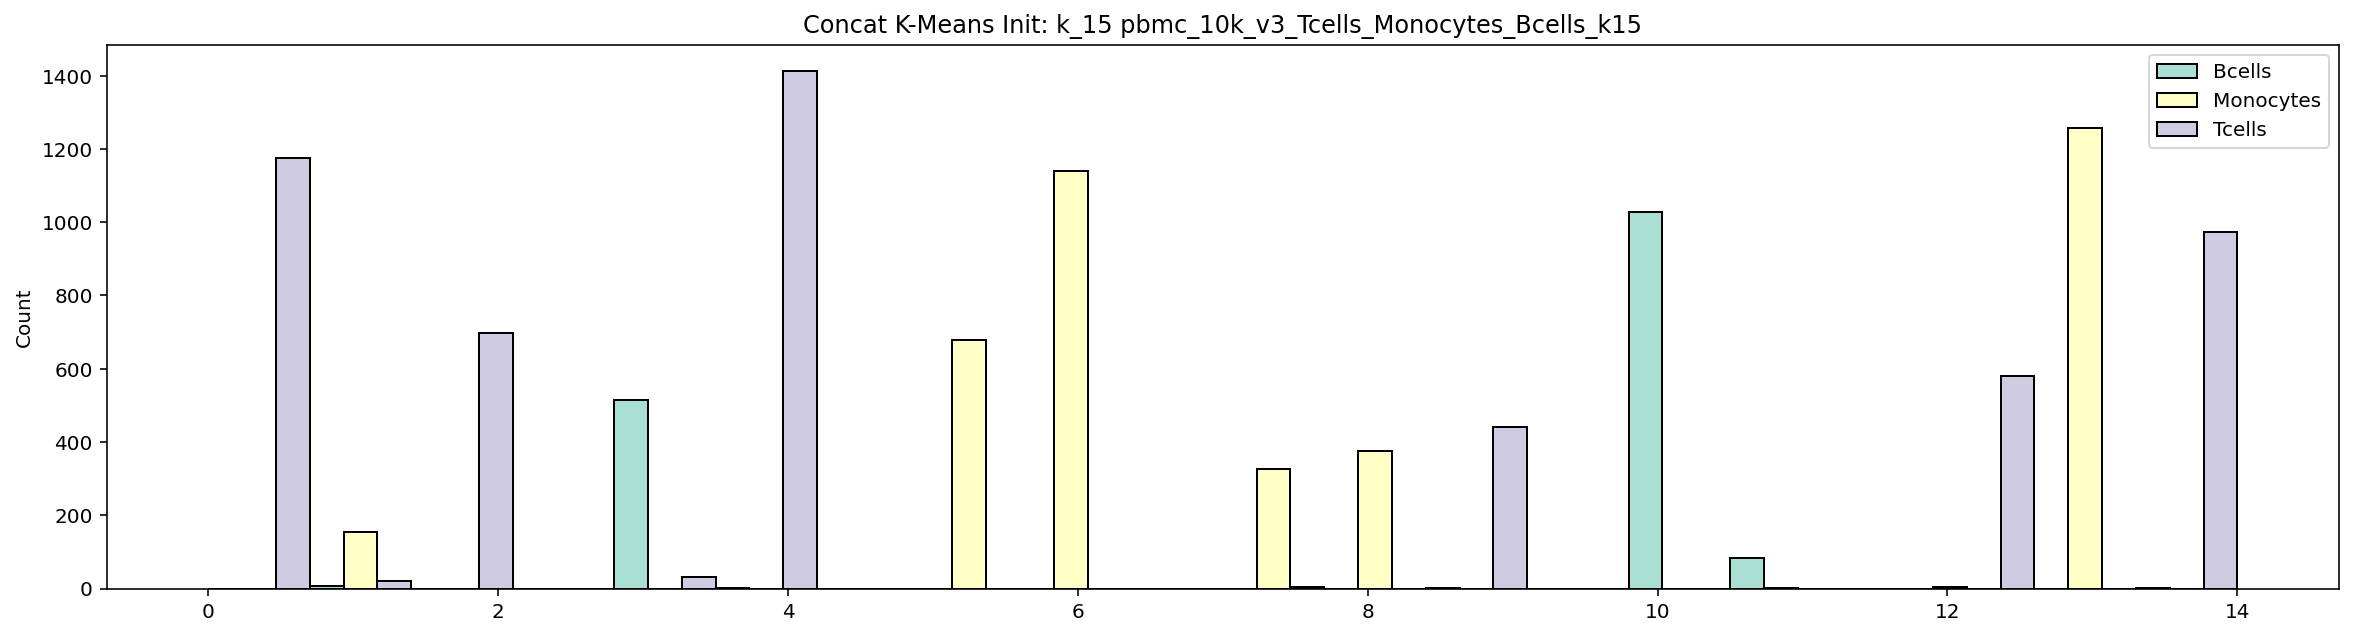

In [719]:
for i in range(num_ks):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    
    
    kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(concat)
    labs = kmeans.labels_

    labels = labs
    all_groups_kmeans += [labs]
    
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Set3',multiple="dodge")
    plt.title('Concat K-Means Init: '+'k_'+str(ks[which])+' '+dataset_names[i])

    
    

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

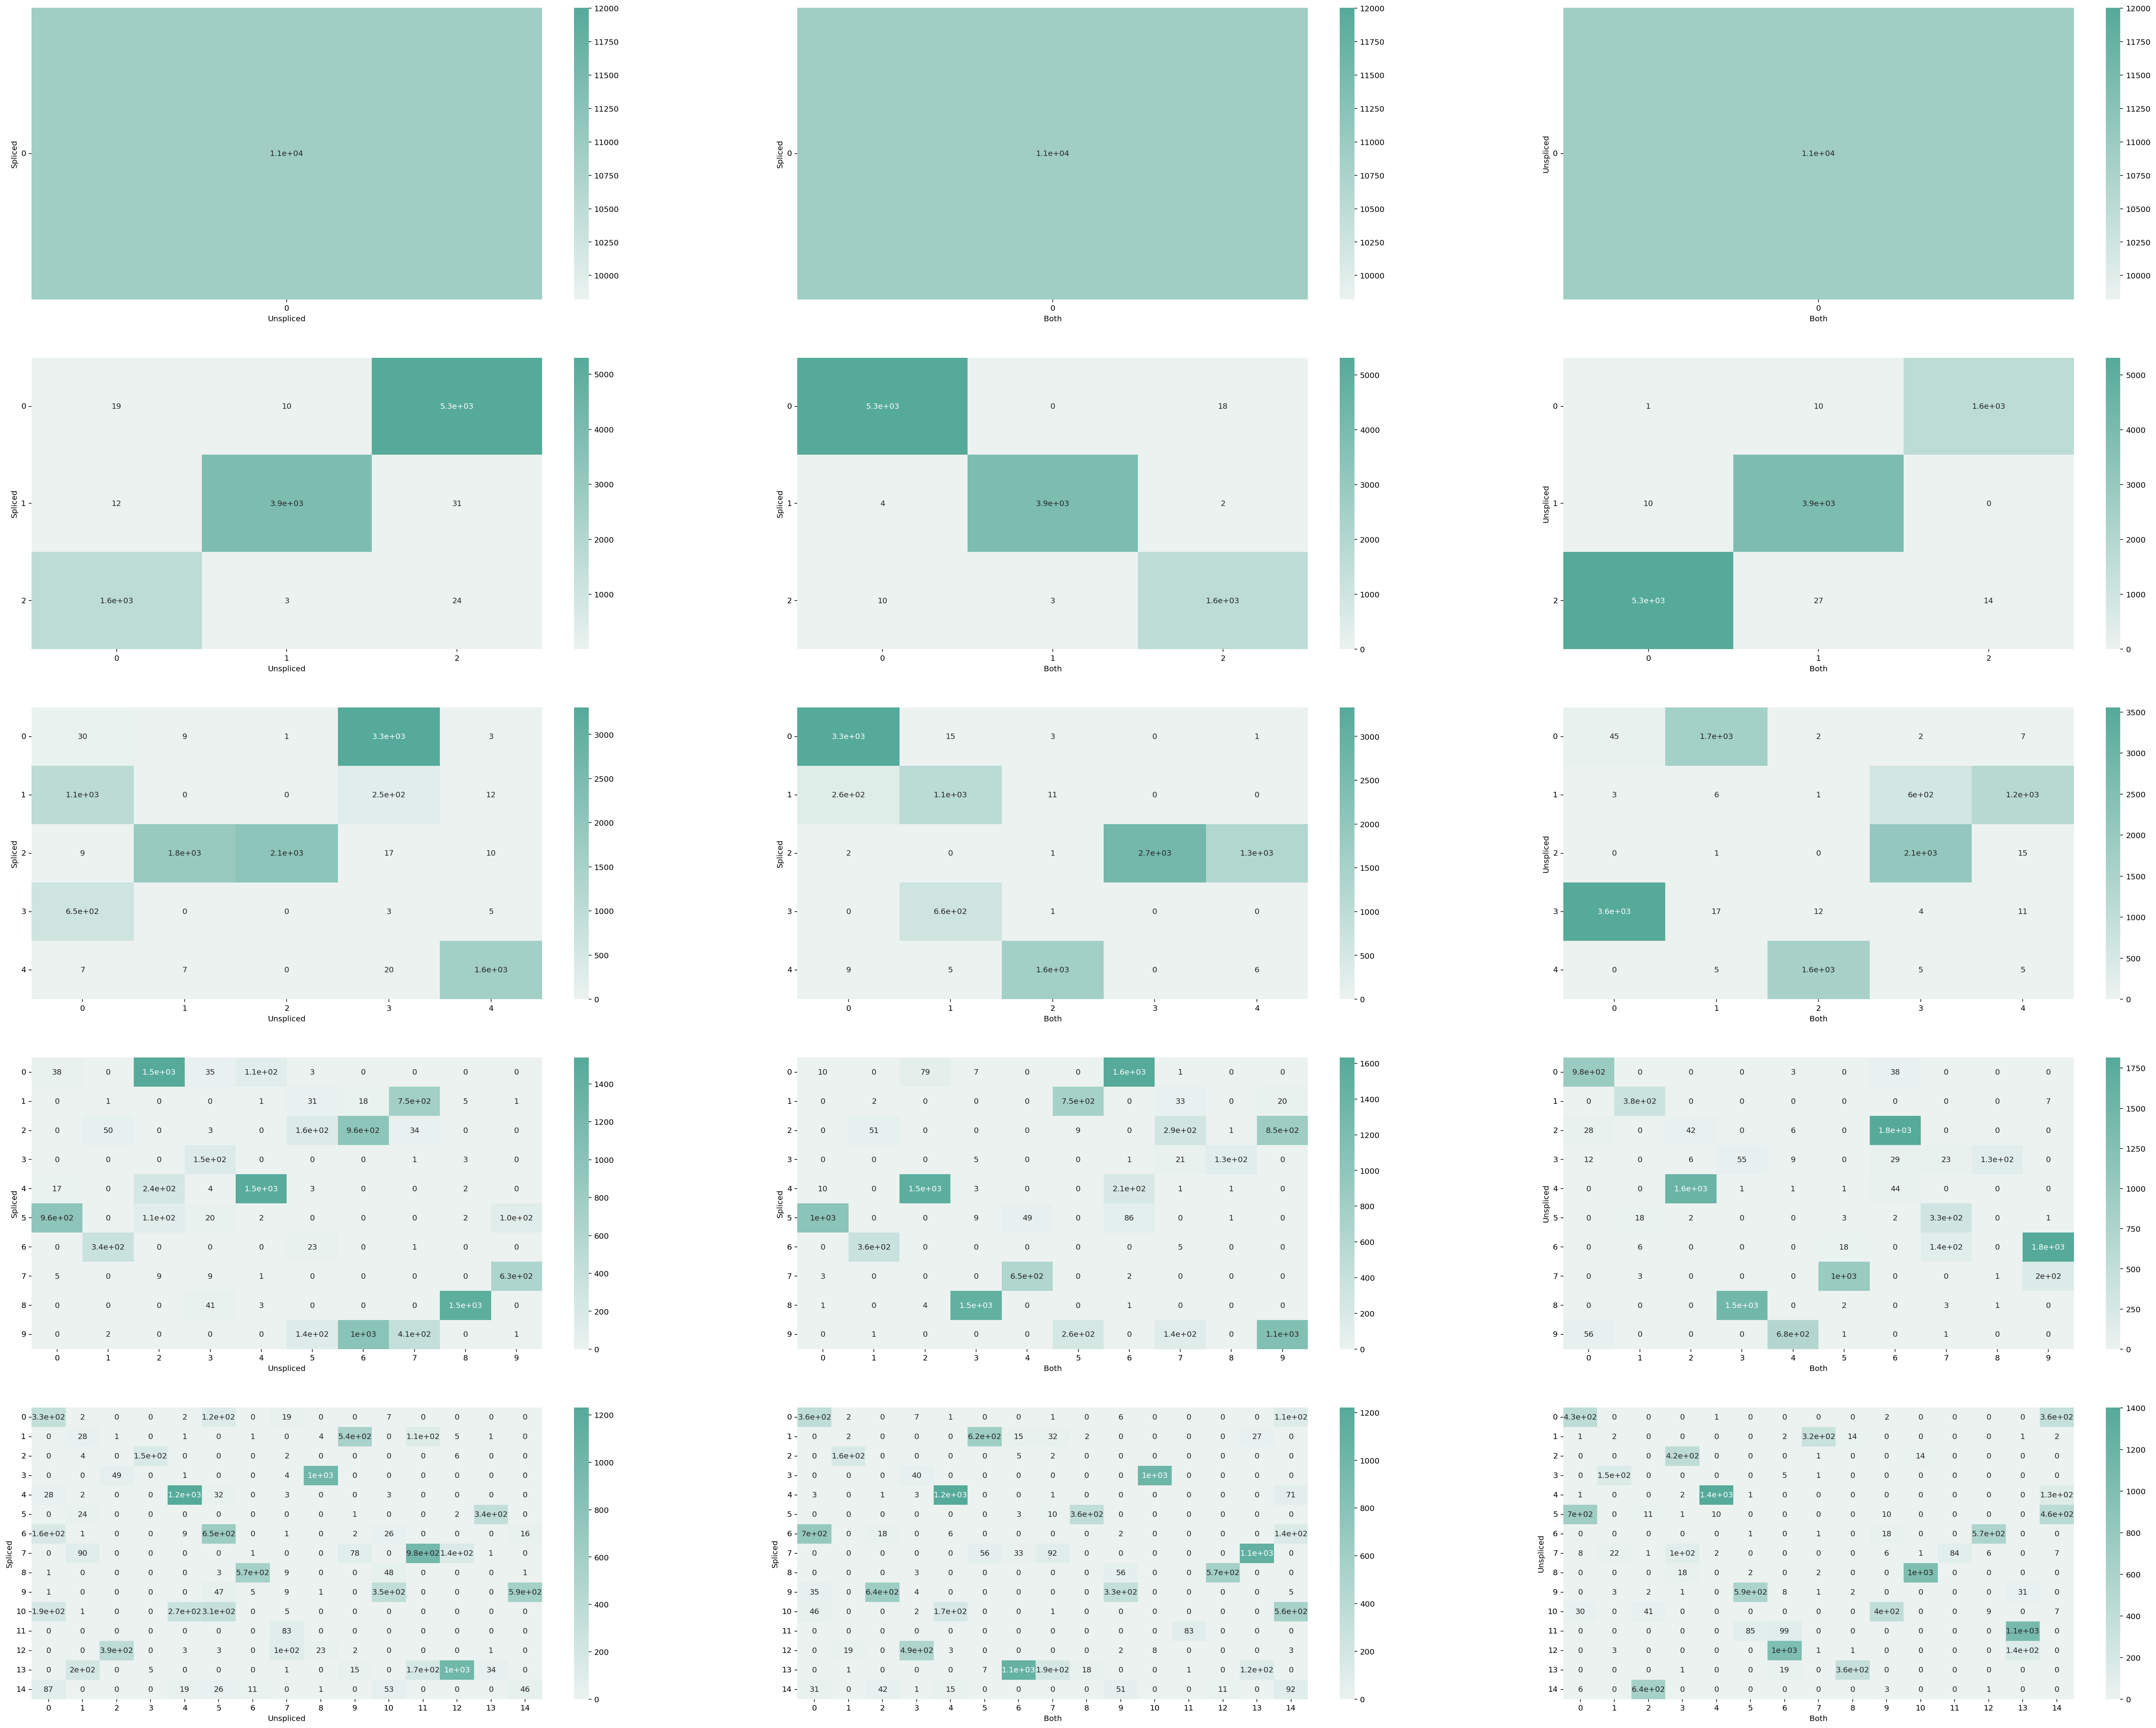

In [720]:
#compare overlap of all k-means assignments

num_per_set = num_ks

pairs = [(0,1),(0,2),(1,2)]
labs = [('Spliced','Unspliced'),('Spliced','Both'),('Unspliced','Both')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(50,40))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups_kmeans[p[1]*(num_per_set)+i]
        true = all_groups_kmeans[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=True, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j])
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)

        ax[i,j].set_ylabel(labs[j][0])
        ax[i,j].set_xlabel(labs[j][1])

    
plt.show()

Leiden Clusters

In [721]:
neigh = 30
all_groups = []
res = [0.25,0.5,1,1.5,2.0]

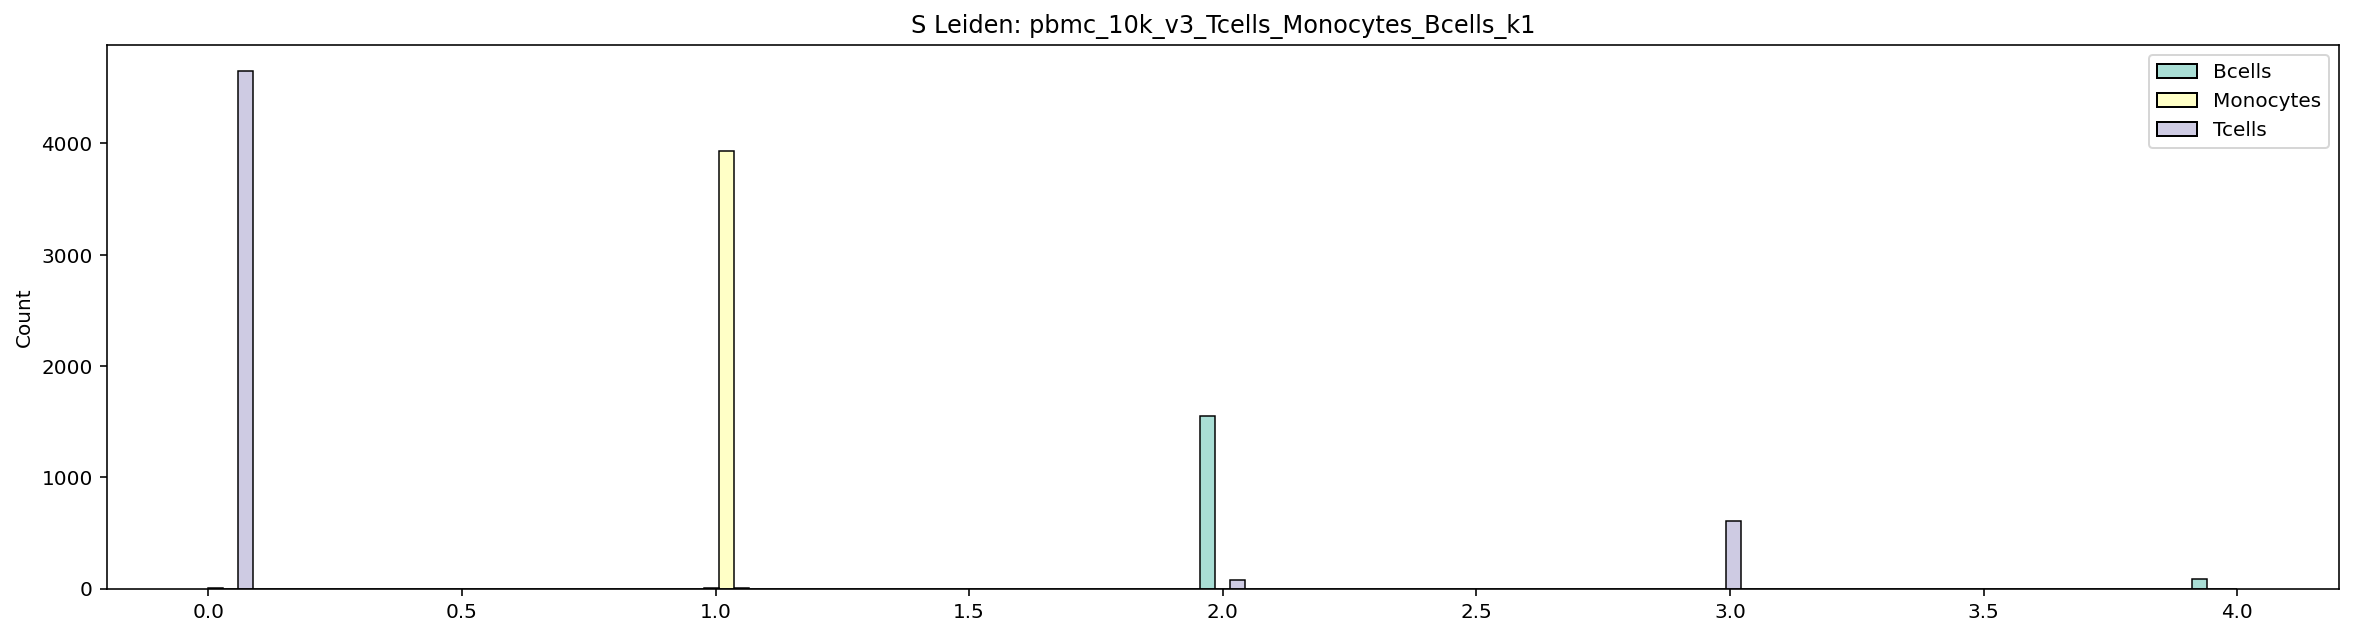

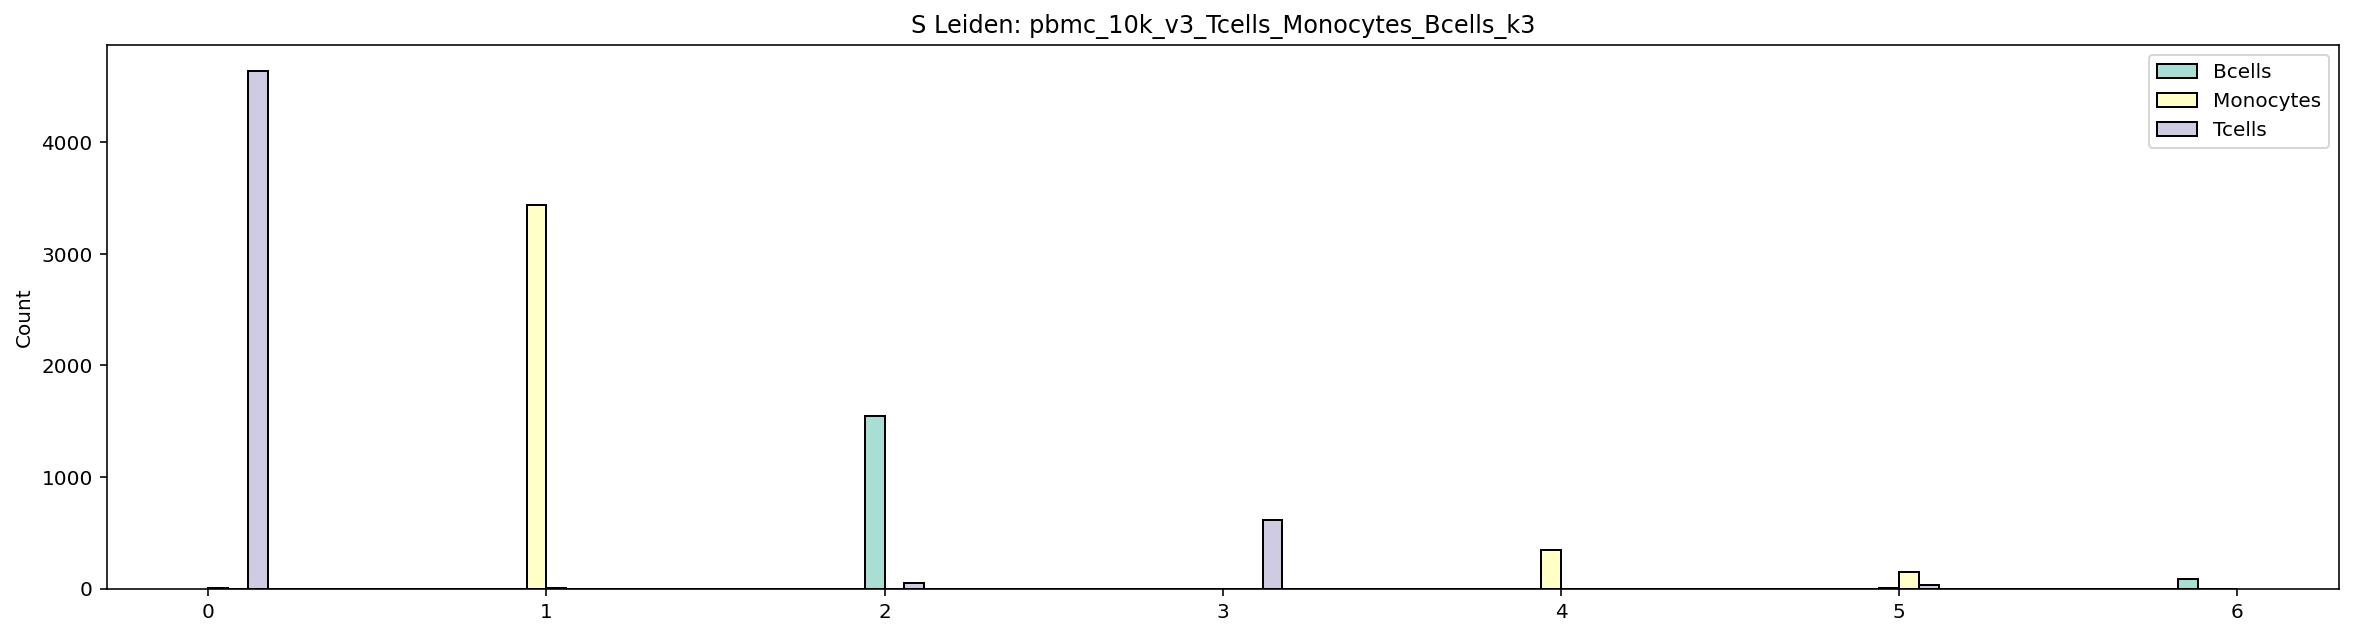

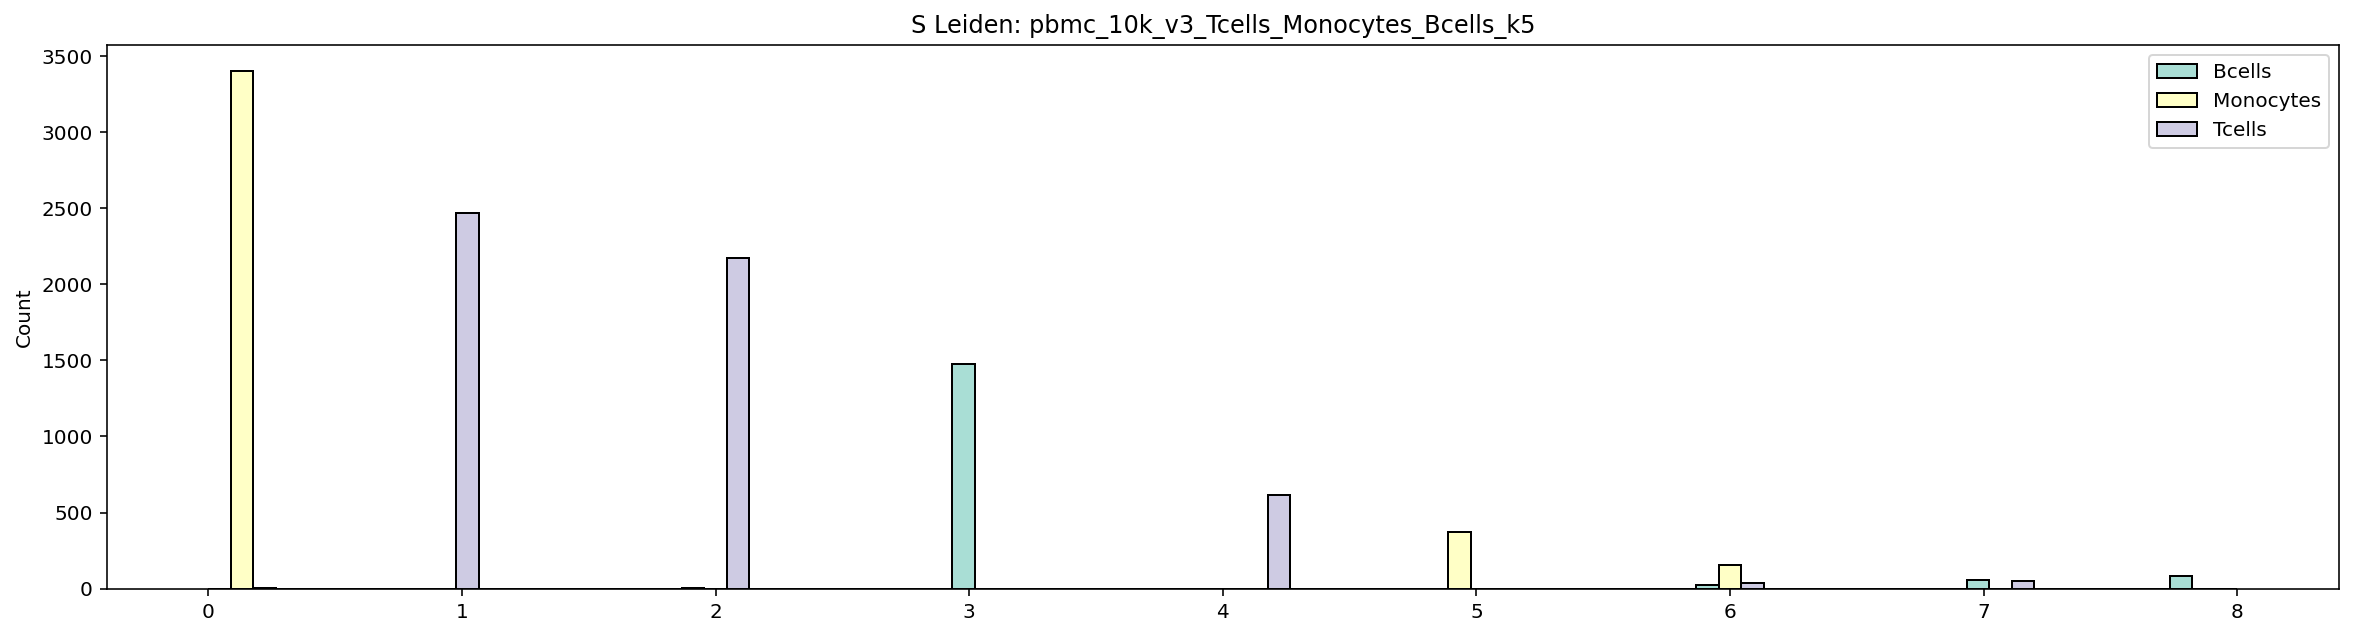

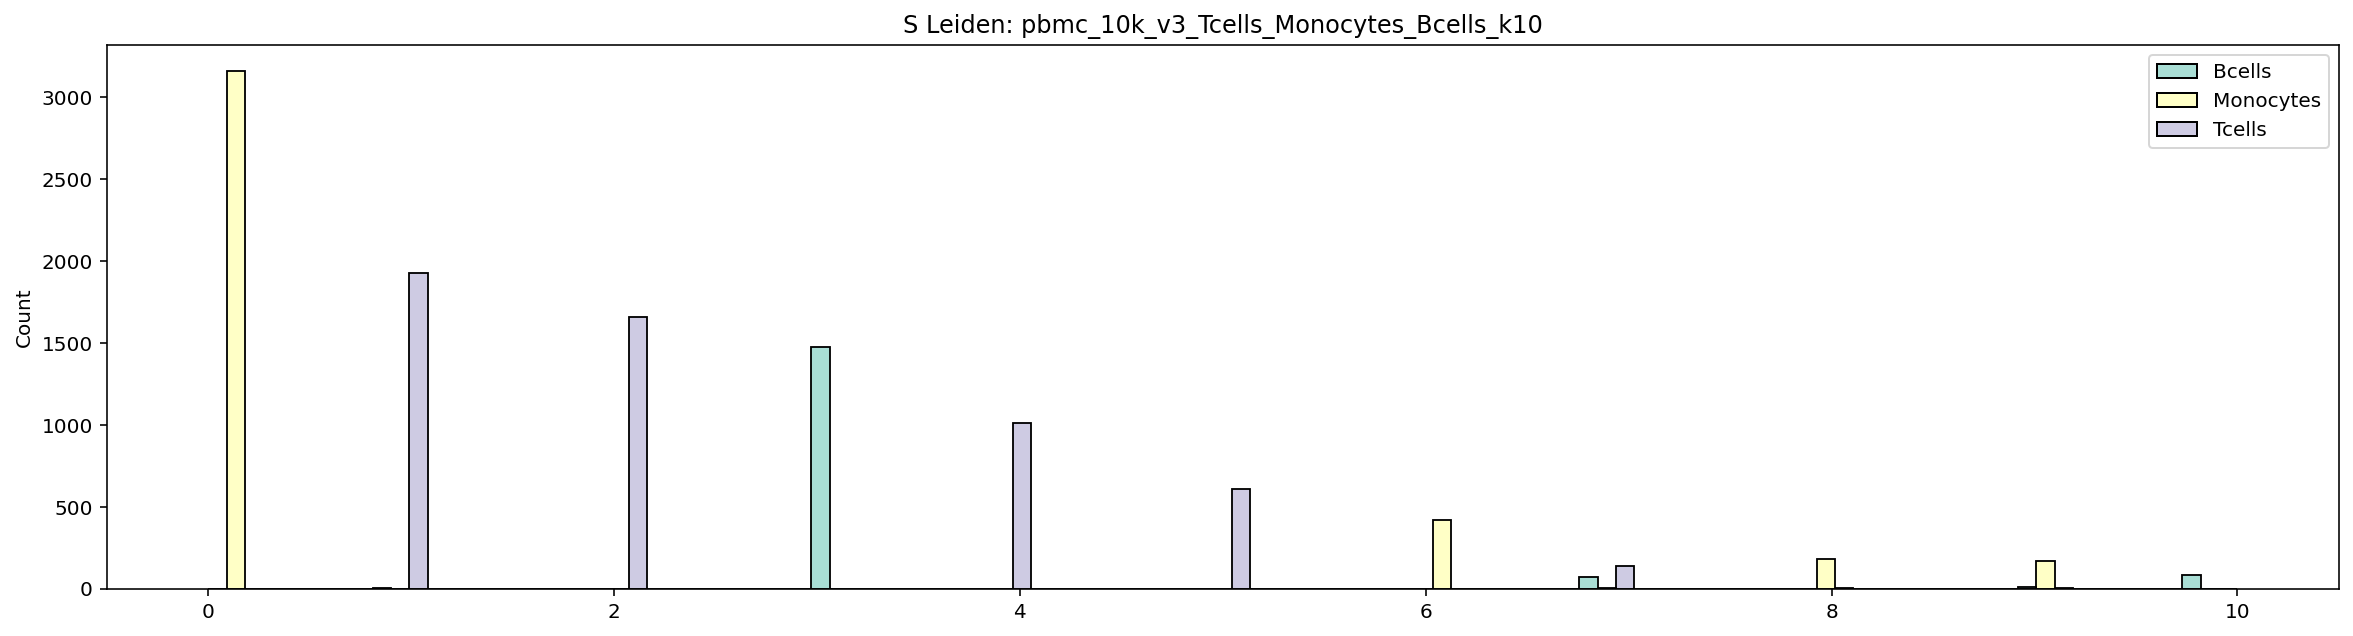

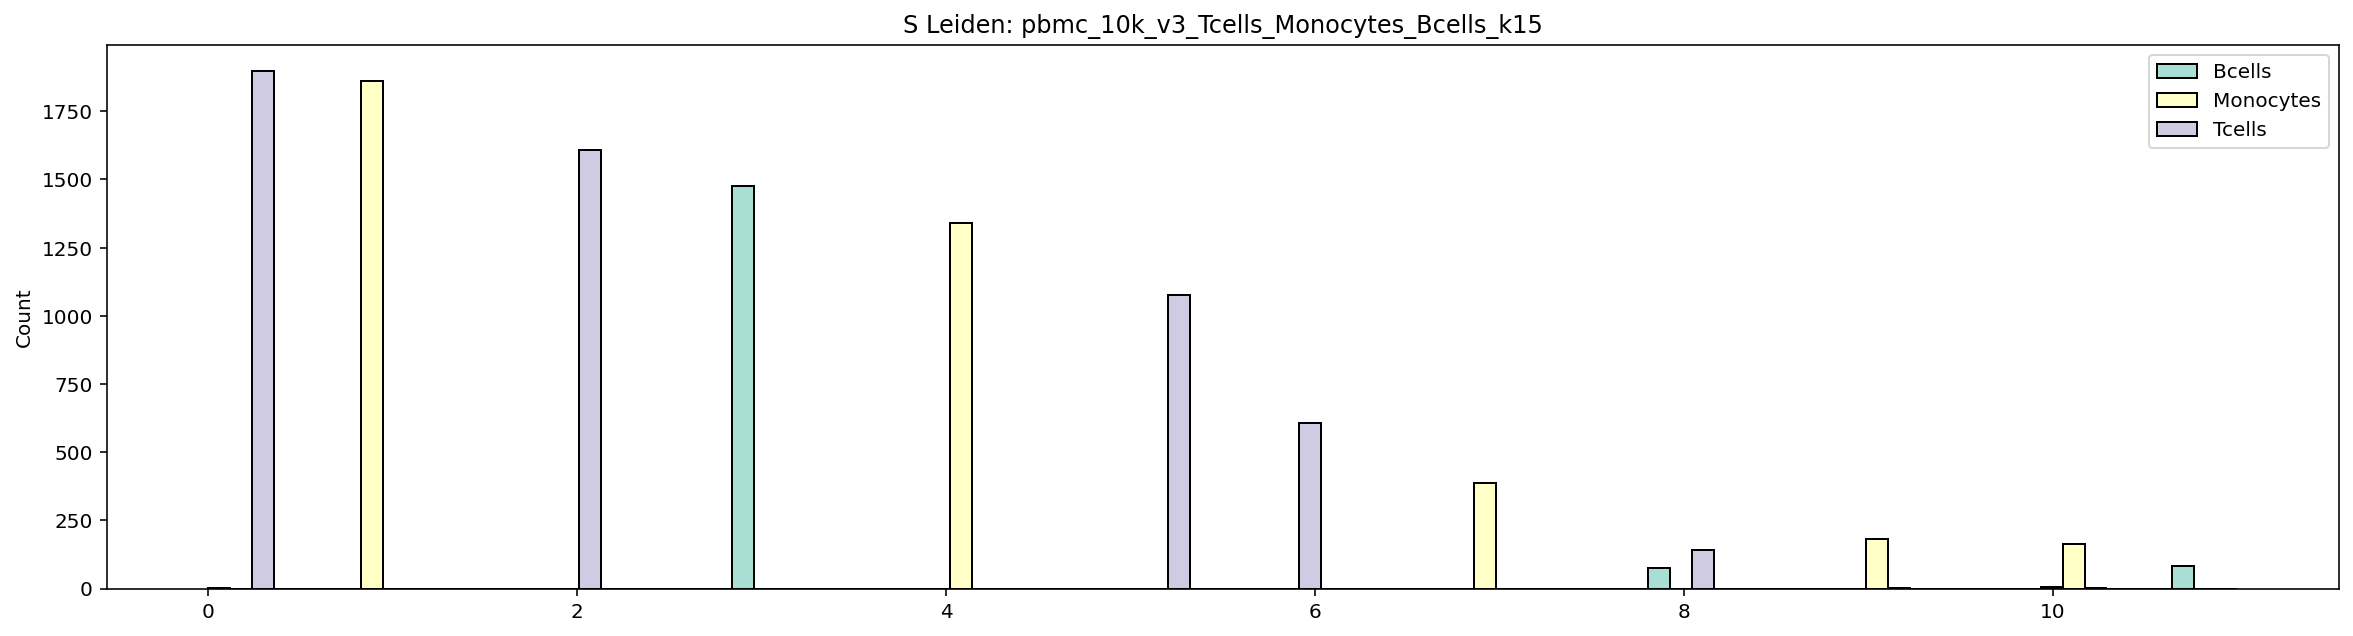

In [722]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(num_ks):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Spliced
    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i%num_ks])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Set3',multiple="dodge")
    plt.title('S Leiden: '+dataset_names[i])
    
    
    


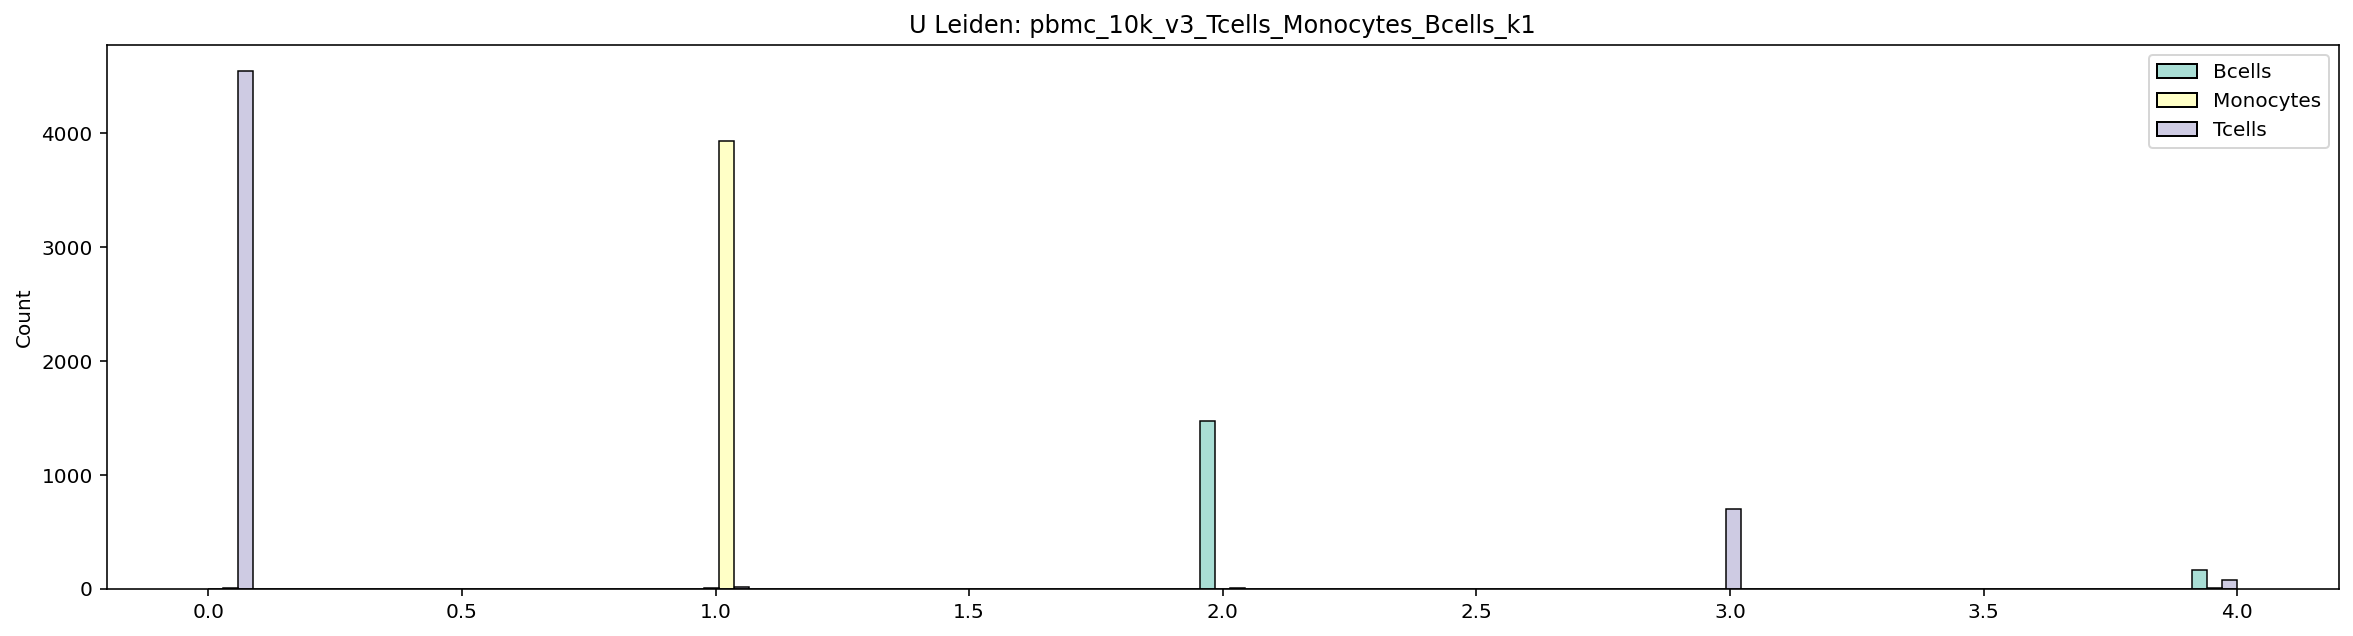

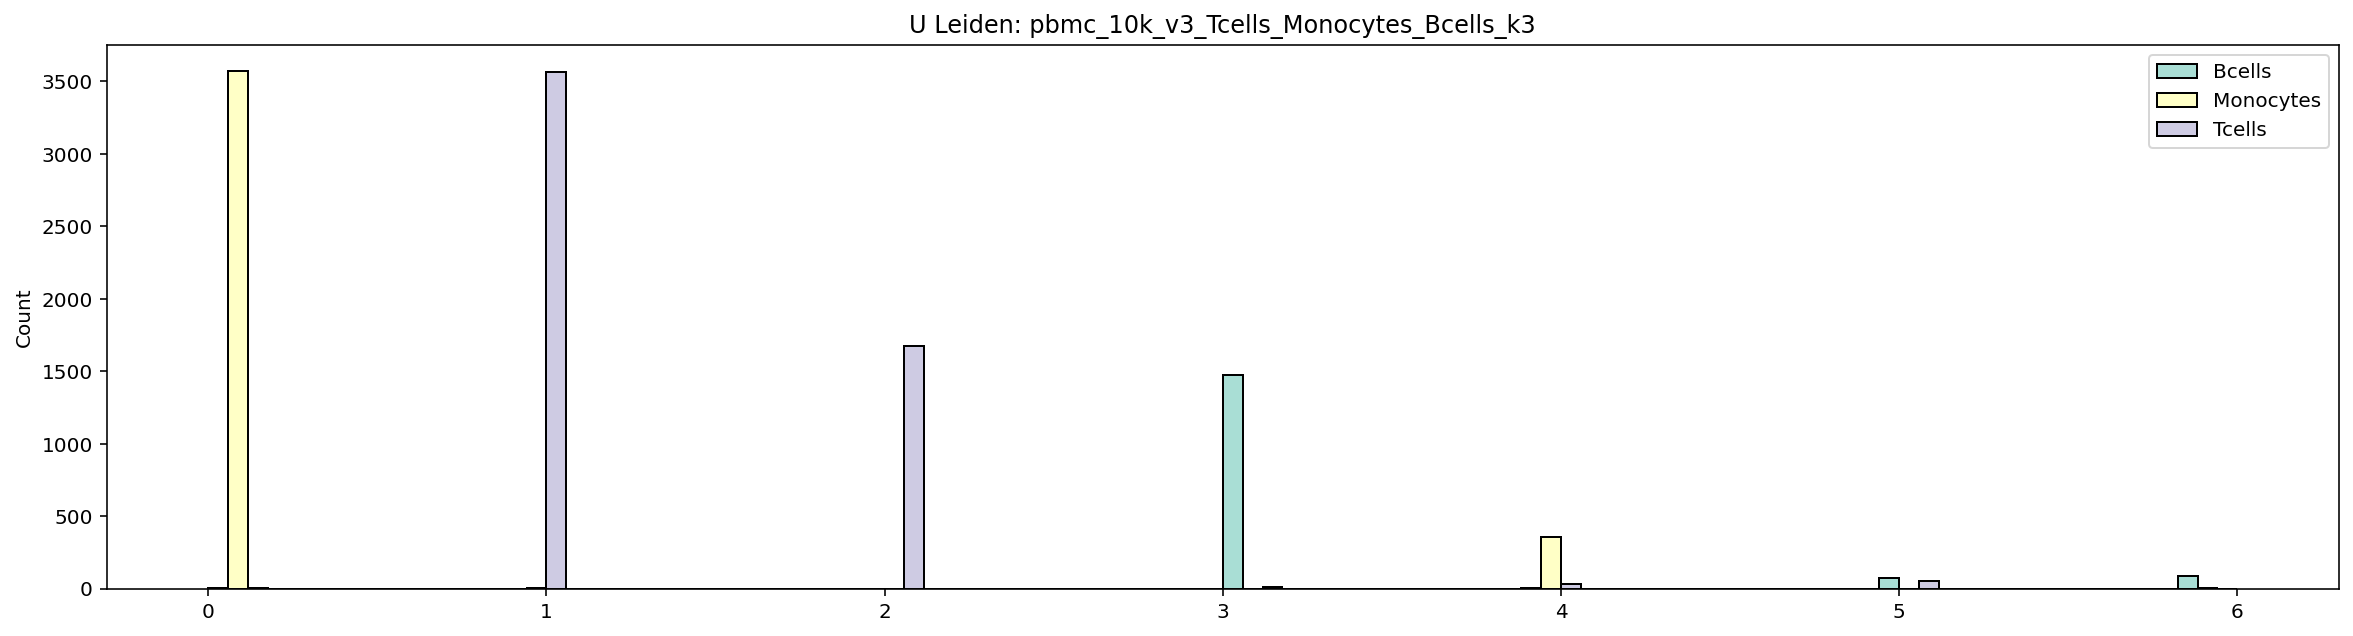

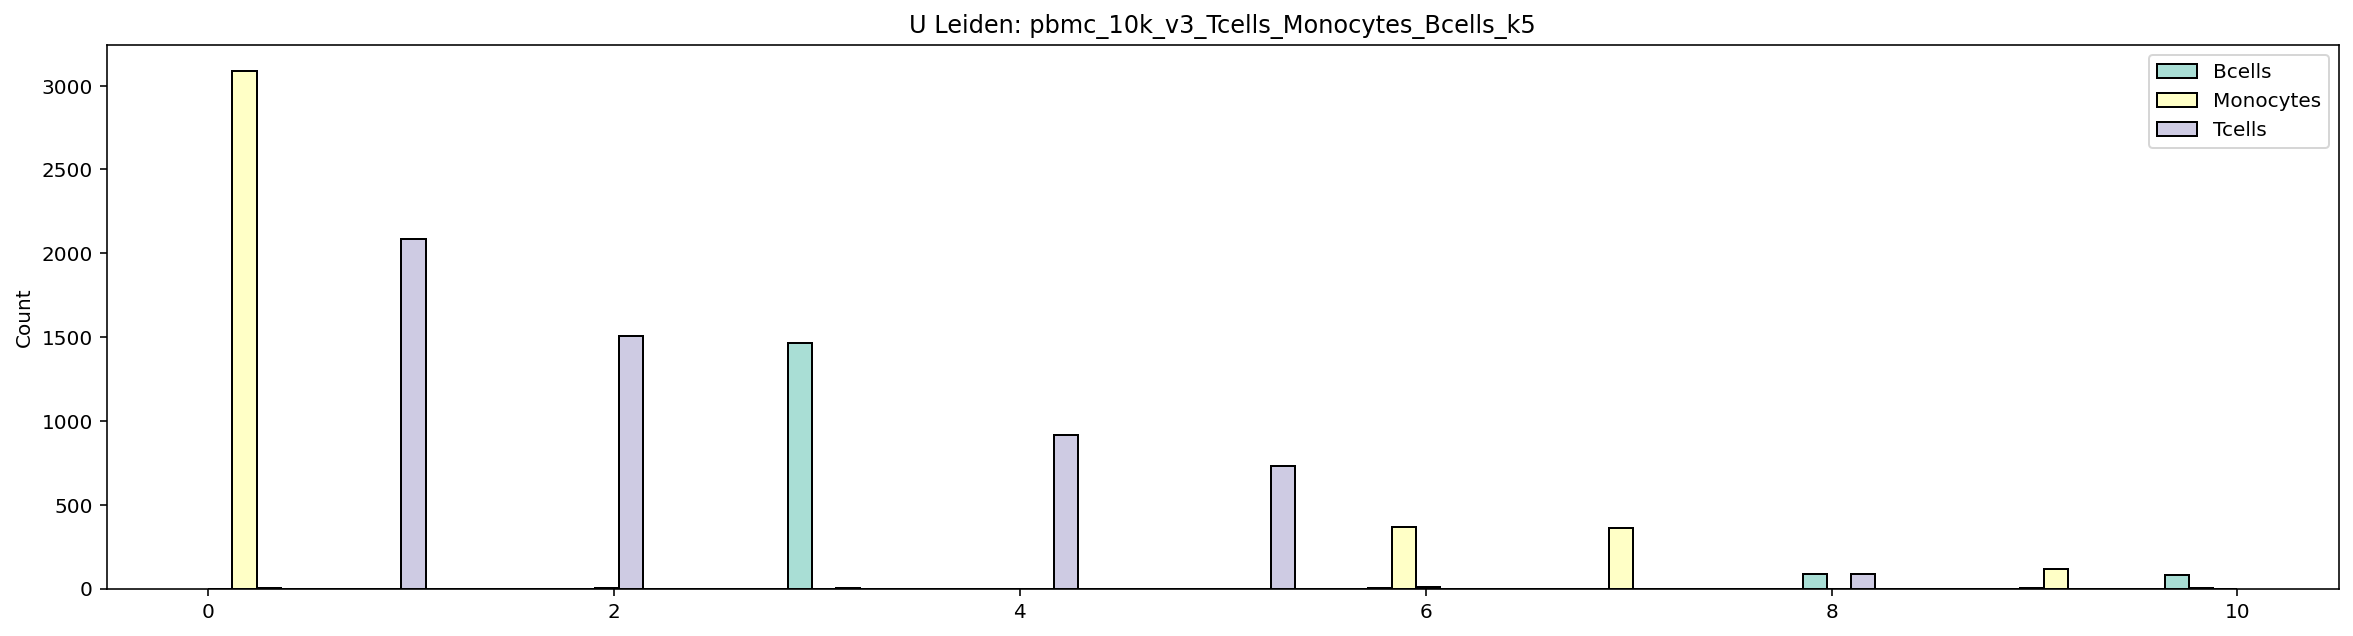

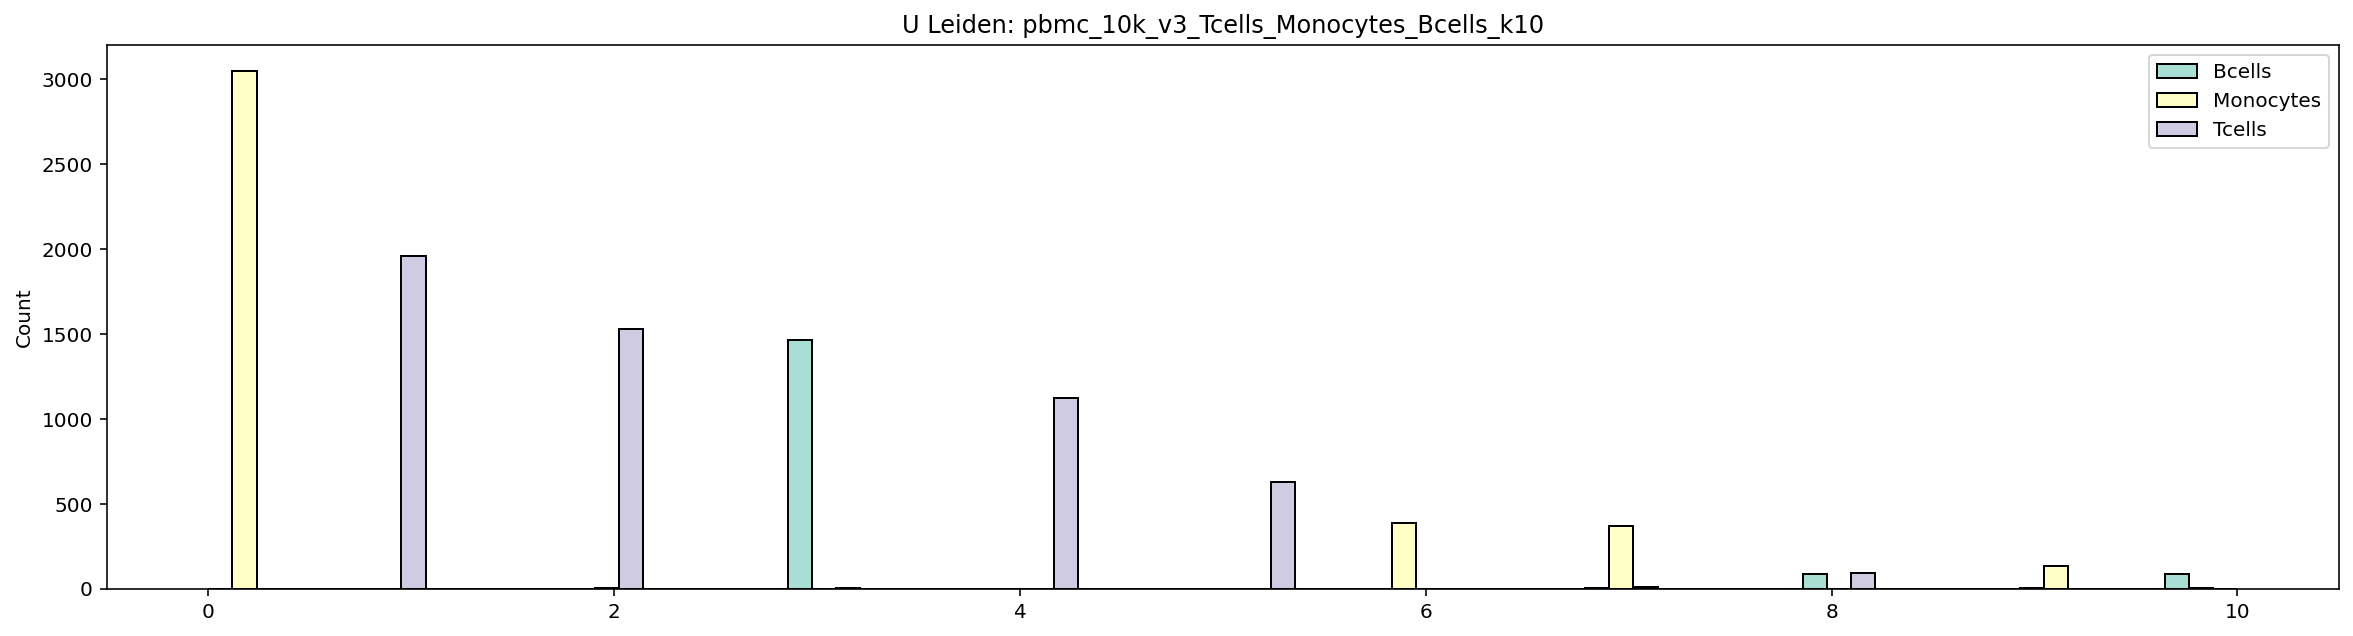

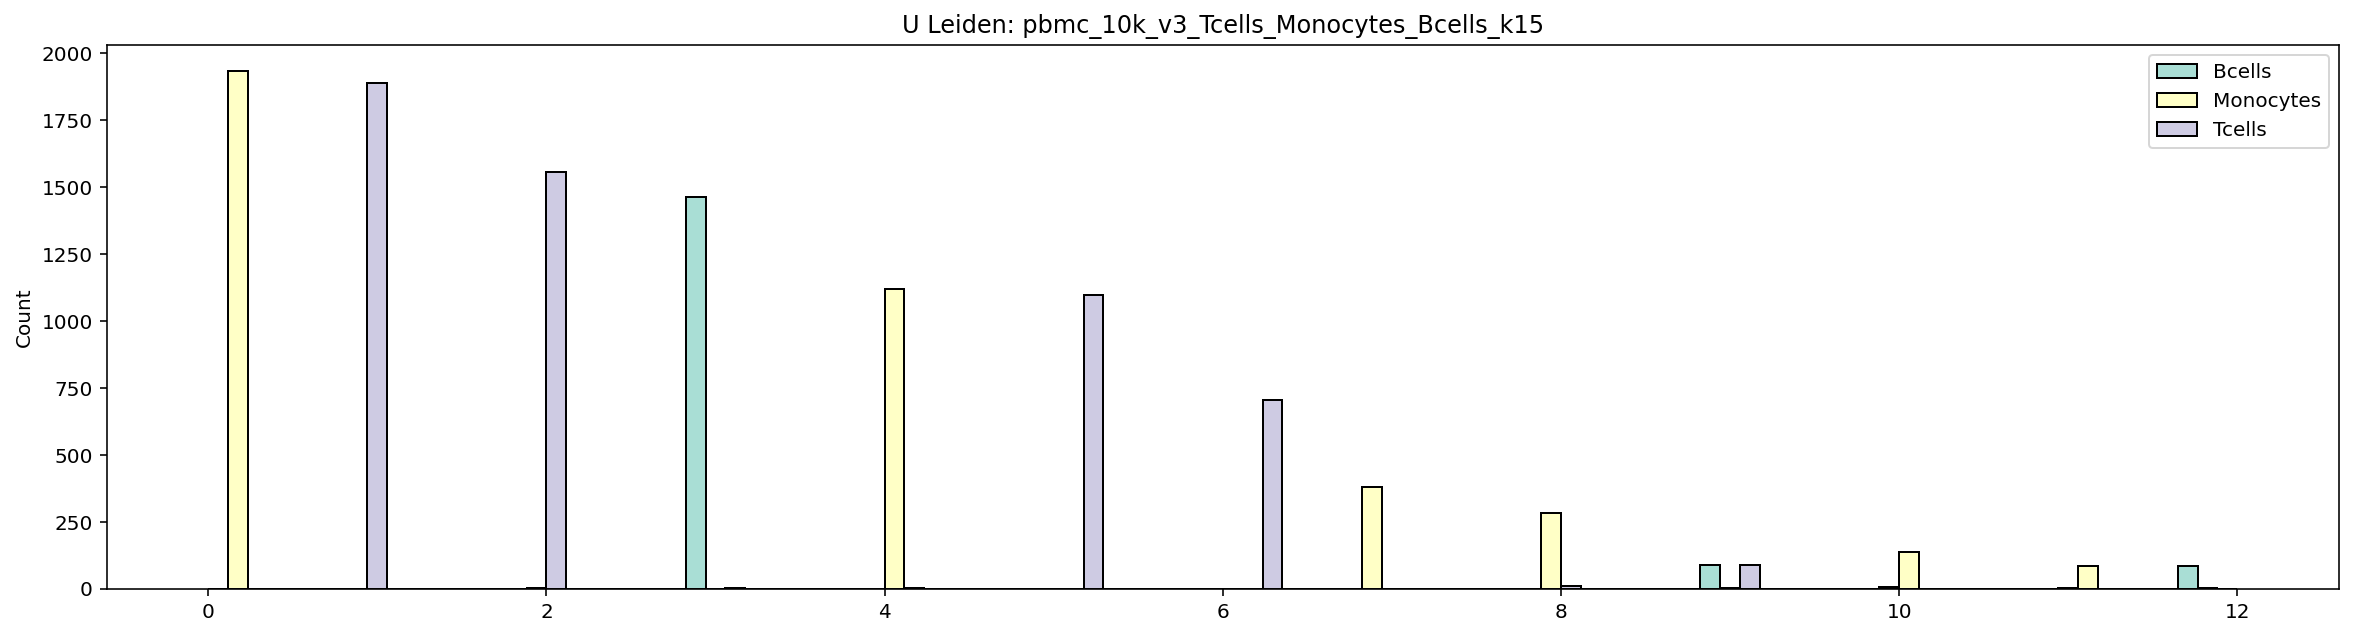

In [723]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(num_ks):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Spliced
    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i%num_ks])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Set3',multiple="dodge")
    plt.title('U Leiden: '+dataset_names[i])
    
    
    


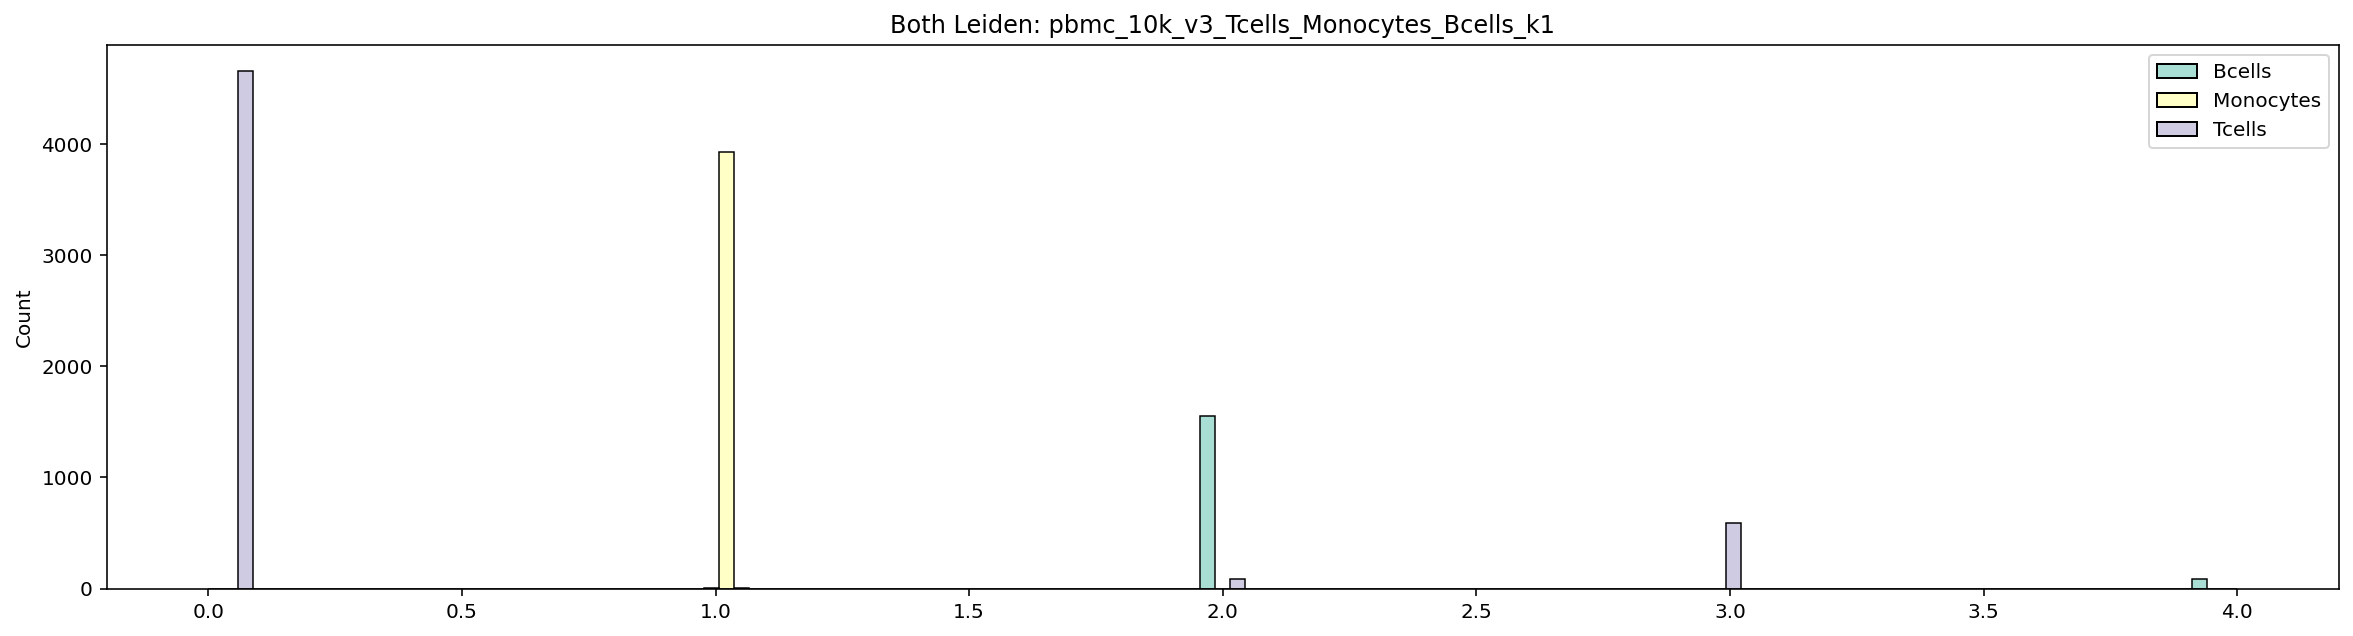

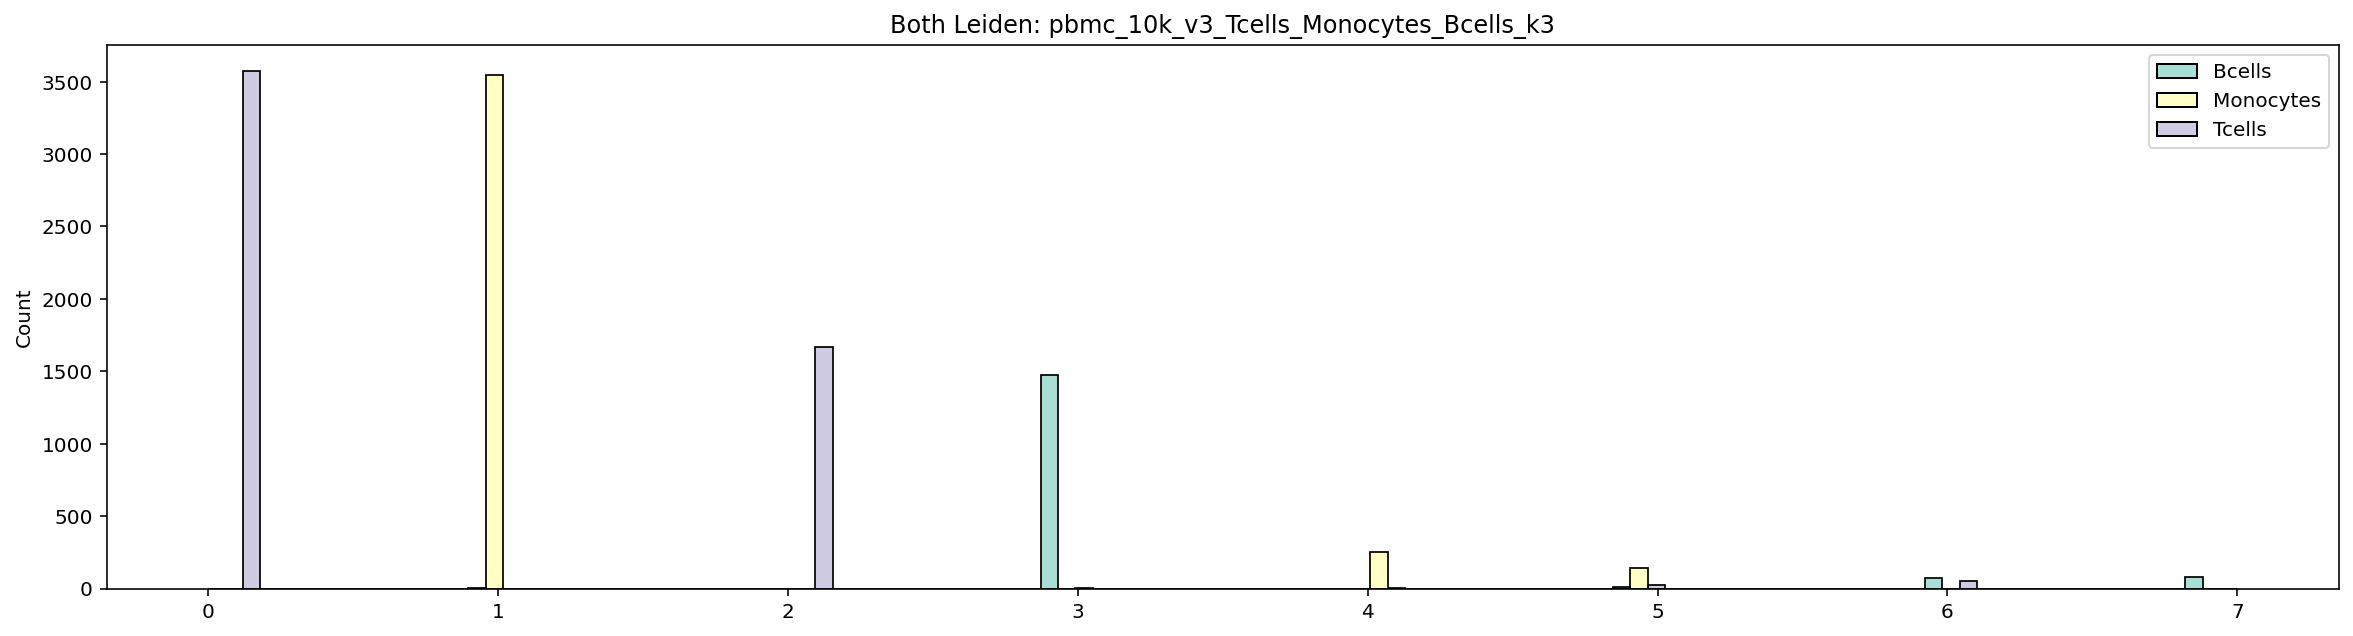

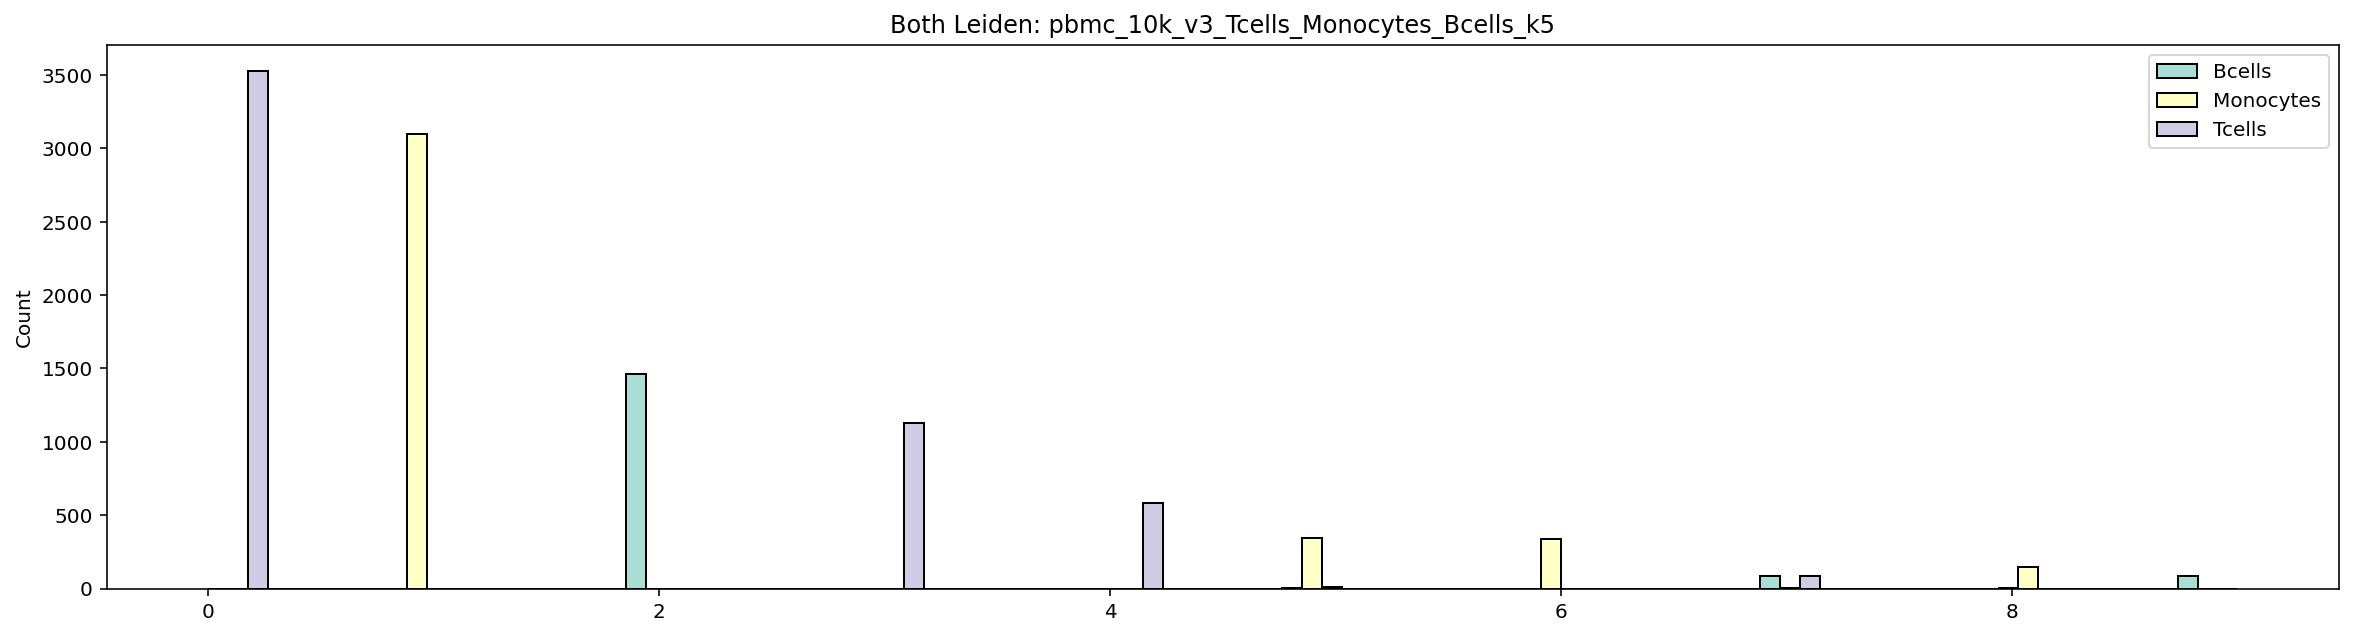

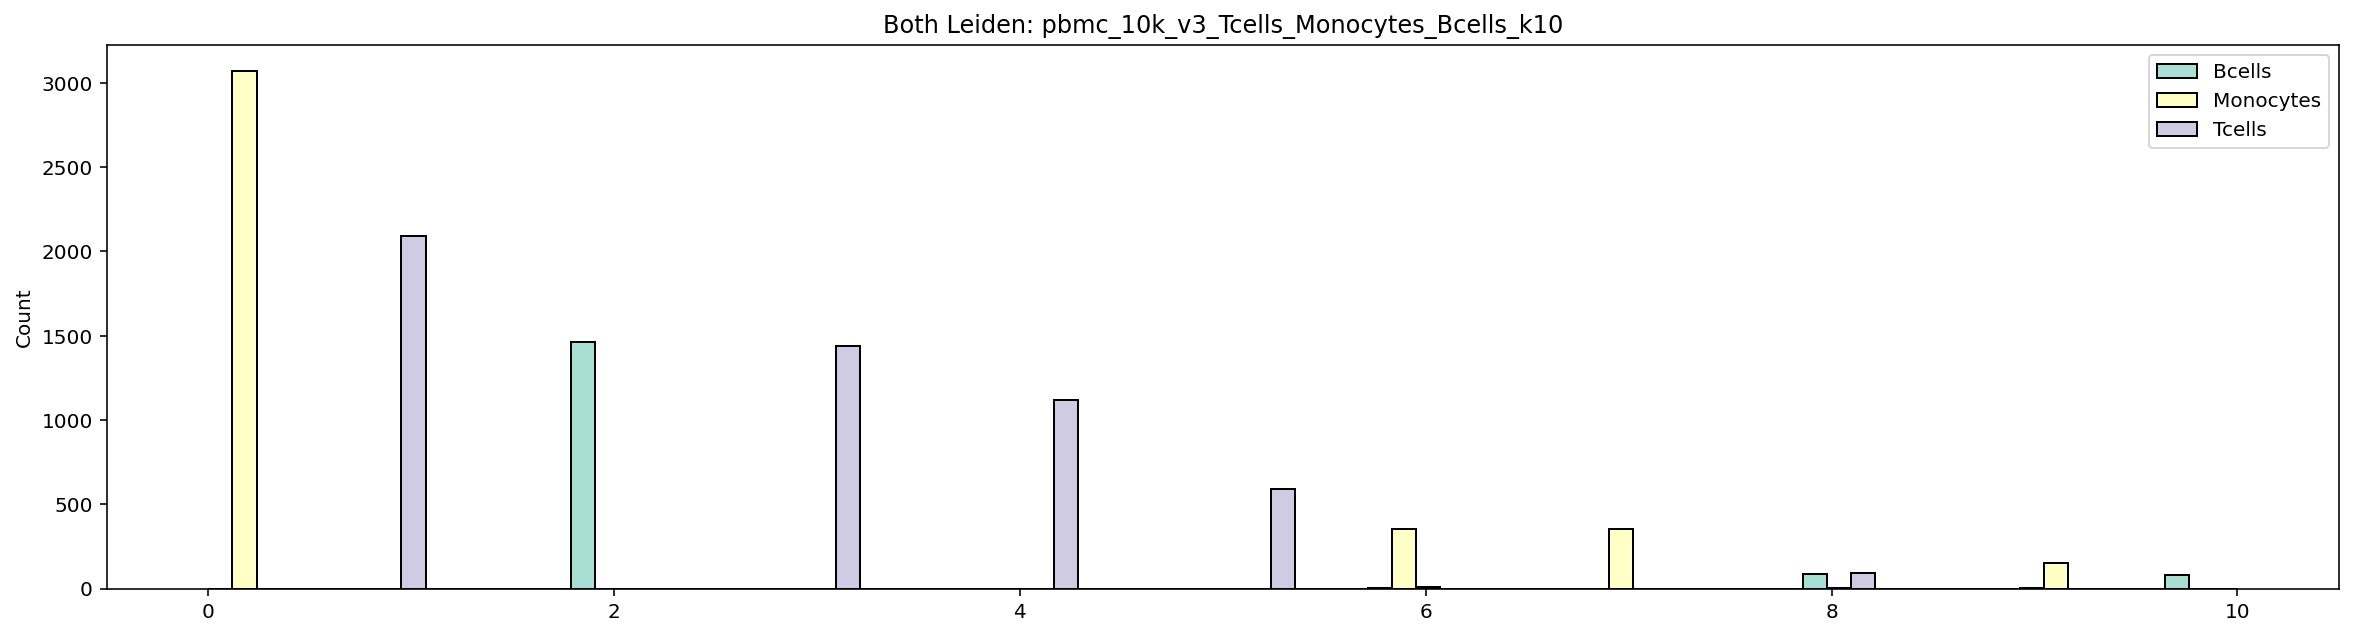

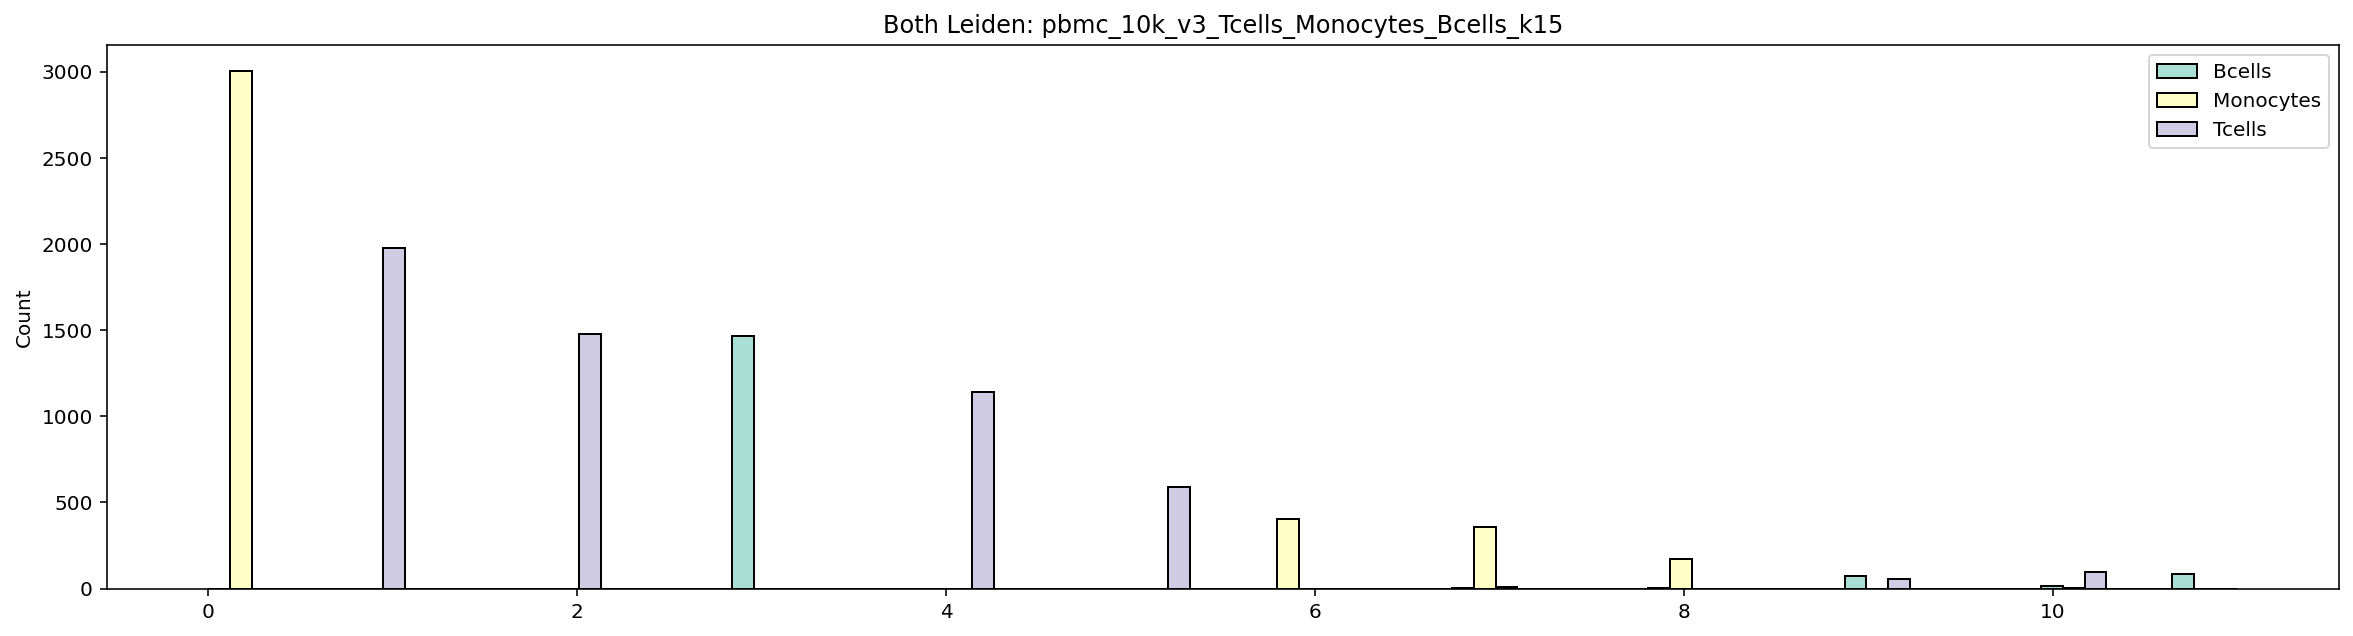

In [724]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(num_ks):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    A = kneighbors_graph(concat, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i%num_ks])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Set3',multiple="dodge")
    plt.title('Both Leiden: '+dataset_names[i])
    
    
    


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(8, 8)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(8, 8)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(11, 11)
(11, 11)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(10, 10)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(13, 13)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


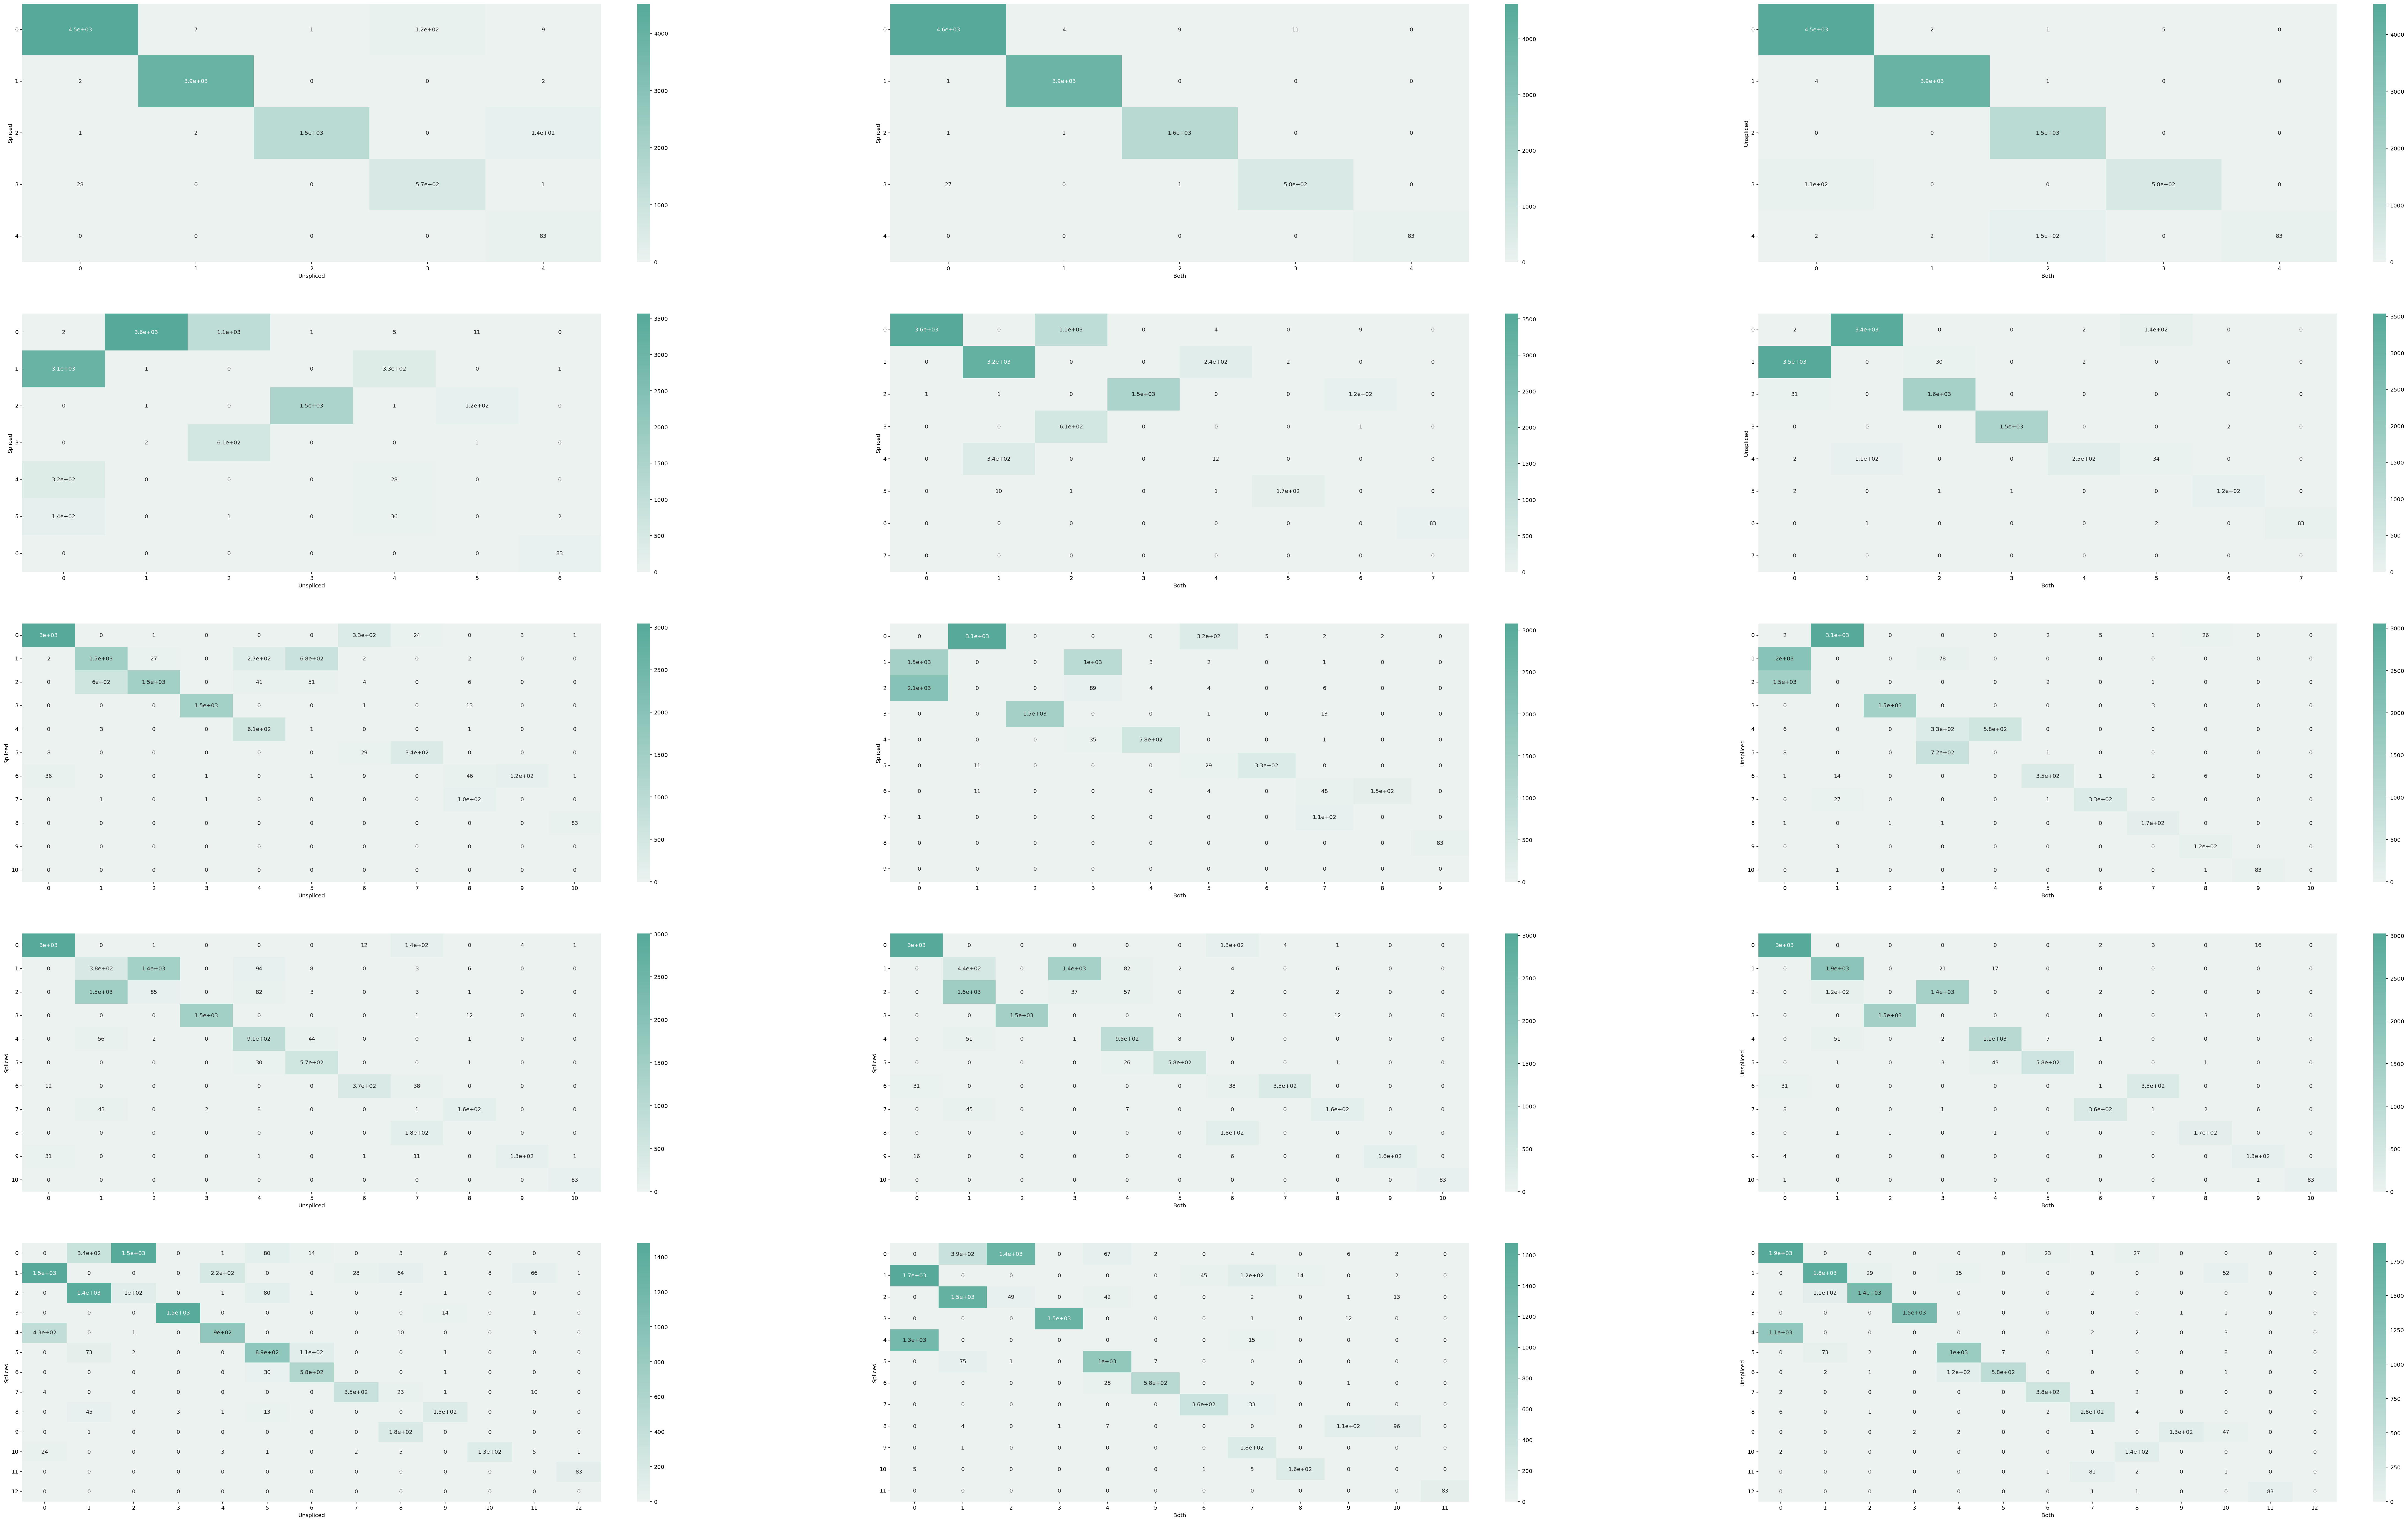

In [725]:
#compare overlap of all k-means assignments

num_per_set = num_ks

pairs = [(0,1),(0,2),(1,2)]
labs = [('Spliced','Unspliced'),('Spliced','Both'),('Unspliced','Both')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(80,50))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups[p[1]*(num_per_set)+i]
        true = all_groups[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=True, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j])
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)

        ax[i,j].set_ylabel(labs[j][0])
        ax[i,j].set_xlabel(labs[j][1])

    
plt.show()

## **Run MM/Monod Inference**

v----------- Only Run Once -----------v

In [726]:
#Define bounds, 
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-9, -4] #-7.5, -2
samp_ub = [-4, 1.5] #-5.5, 0
# gridsize = [5,6]
gridsize = [10,11]


In [727]:
len(dataset_names)

8

In [728]:
# dataset_names

In [729]:
#Run Monod as control on separate groups
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(dataset_names)-3,len(dataset_names)): 

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string,viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells/Bursty_Poisson_10x11 created.
INFO:root:Global inference parameters stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230501_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [14:48<00:00,  8.08s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells/Bursty_Poisson_10x11/analysis_figures created.
INFO:root:Runtime: 892.9 seconds.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_10x11 created.
INFO:root:Global inference parameters stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Monocytes
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230501_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [17:09<00:00,  9.36s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_10x11/analysis_figures created.
INFO:root:Runtime: 1034.5 seconds.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Bcells/Bursty_Poisson_10x11 created.
INFO:root:Global inference parameters stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Bcells/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Bcells
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230501_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Bcells/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [13:37<00:00,  7.43s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Bcells/Bursty_Poisson_10x11/analysis_figures created.
INFO:root:Runtime: 822.6 seconds.


In [730]:
result_strings = [i+'/Bursty_Poisson_10x11/grid_scan_results.res' for i in dataset_strings[(len(dataset_names)-3):]]


INFO:root:Grid scan results loaded from ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Bcells/Bursty_Poisson_10x11/grid_scan_results.res.
(-6.222222222222222, -1.25)
(-5.666666666666666, -0.6999999999999997)
(-5.666666666666666, -0.6999999999999997)


Text(0, 0.5, '$\\log_{10} \\lambda_M$')

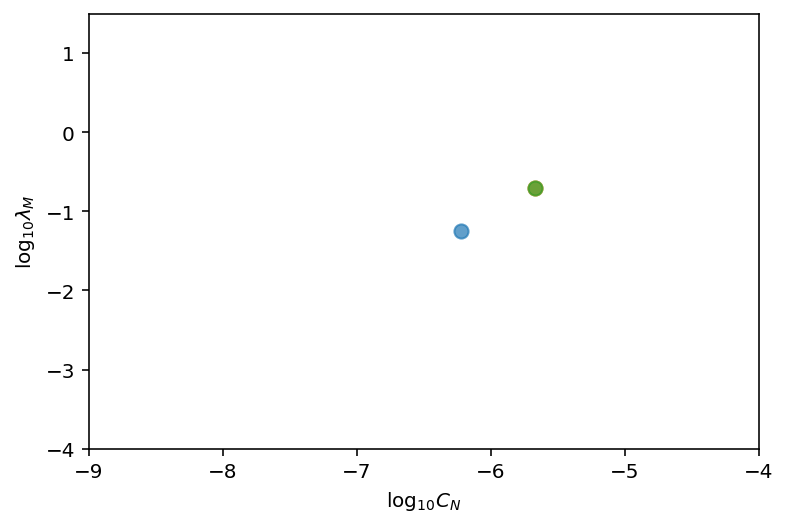

In [731]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
plt.figure()
for r in sr:
    r.find_sampling_optimum()
    print(r.samp_optimum)
    plt.scatter(r.samp_optimum[0],r.samp_optimum[1],alpha=0.7,s=50)
    
plt.xlim([-9,-4])
plt.ylim([-4,1.5])

plt.xlabel(r'$\log_{10} C_N$')
plt.ylabel(r'$\log_{10} \lambda_M$')

In [733]:
#Find closest technical param in grid, to centroid of technical params on plot
arbitrary_params = np.asarray([-5.8,-0.9]) #-8,-2.5
arbitrary_ind = np.argmin(((sr[0].sp.sampl_vals-arbitrary_params)**2).sum(1))
arbitrary_pars = sr[0].sp.sampl_vals[arbitrary_ind]
print(arbitrary_pars)

(-5.666666666666666, -0.6999999999999997)


^----------- Only Run Once -----------^

In [734]:
dataset_names

['pbmc_10k_v3_Tcells_Monocytes_Bcells_k1',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k3',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k5',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k10',
 'pbmc_10k_v3_Tcells_Monocytes_Bcells_k15',
 'pbmc_10k_v3_Tcells',
 'pbmc_10k_v3_Monocytes',
 'pbmc_10k_v3_Bcells']

In [735]:
#Define bounds, choose 'centroid'
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-5.666666666666666, -0.6999999999999997] 
samp_ub = [-5.666666666666666, -0.6999999999999997] 
# gridsize = [5,6]
gridsize = [1,1]

In [736]:
#Run Monod as control on separate groups 
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(dataset_names)-3,len(dataset_names)):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)
    

INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230501_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:37<00:00, 157.24s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 161.3 seconds.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Monocytes
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230501_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:07<00:00, 127.10s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 131.1 seconds.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Bcells/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Bcells/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Bcells
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230501_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Bcells/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:07<00:00, 127.72s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Bcells/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 131.8 seconds.


In [737]:
result_strings = [i+'/Bursty_Poisson_1x1/grid_scan_results.res' for i in dataset_strings[len(dataset_names)-3:]]

In [738]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
sr

INFO:root:Grid scan results loaded from ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Bcells/Bursty_Poisson_1x1/grid_scan_results.res.


In [739]:
#Raw ds files (with spliced/unspliced counts)
raws = [i+'/raw.sd' for i in dataset_strings[len(dataset_names)-3:]] #0:len(chosen)*num_ks
sd = [monod.analysis.load_search_data(i) for i in raws]
sd

INFO:root:Search data loaded from ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Bcells/raw.sd.


**Run Mixture Model**

In [740]:
epochs = 30 

In [ ]:
result_strings = []
for i in [4,3,2,1,0]: #range(num_ks-1,-1,-1): #rlen(chosen)*num_ks, 1,2,3,4,0
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k15/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k15/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k15
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230501_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k15/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [05:45<00:00, 23.01s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [05:39<00:00, 24.22s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.04324563e-01 4.97596003e-02 3.60701749e-03 1.02069675e-01
 2.22225508e-01 3.38787159e-03 9.69440746e-05 1.33830587e-01
 4.34536837e-02 1.08135324e-01 6.64133680e-03 7.36706428e-03
 3.35391699e-02 1.73546397e-01 8.01525743e-03]
Q Function:  -19209995.00404793

INFO:root:EM Epoch 2/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [05:30<00:00, 23.61s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.79923393e-02 4.22768085e-02 4.03187046e-03 1.02717124e-01
 2.30932830e-01 1.27368223e-04 1.00228715e-02 1.43380228e-01
 4.92845359e-02 1.11748033e-01 9.16338311e-11 6.96417125e-03
 3.27214034e-02 1.66777049e-01 1.02336743e-03]
Q Function:  -18009384.384952623

INFO:root:EM Epoch 3/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [06:47<00:00, 33.92s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.13543714e-02 3.34398724e-02 5.22313638e-03 1.03885118e-01
 2.63989233e-01 9.16338311e-11 8.32955390e-03 1.61469021e-01
 4.86797032e-02 1.07226722e-01 9.16338311e-11 6.96417125e-03
 3.15479536e-02 1.57891143e-01 9.16338311e-11]
Q Function:  -18057370.57278627

INFO:root:EM Epoch 4/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:53<00:00, 24.48s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.86131024e-02 2.47758384e-02 6.41436808e-03 1.18154933e-01
 2.74255429e-01 9.16338311e-11 8.52695561e-03 1.60884457e-01
 5.02206899e-02 1.08069065e-01 9.16338311e-11 6.96417125e-03
 1.68211053e-02 1.66299885e-01 9.16338311e-11]
Q Function:  -18090644.298284013

INFO:root:EM Epoch 5/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:23<00:00, 26.96s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.35645433e-02 1.92161263e-02 6.41436827e-03 1.27421335e-01
 2.78859327e-01 9.16338311e-11 6.14377898e-03 1.58311394e-01
 5.15059934e-02 1.07787027e-01 9.16338311e-11 6.96419173e-03
 7.35031086e-03 1.76461603e-01 9.16338311e-11]
Q Function:  -18046201.94973887

INFO:root:EM Epoch 6/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:33<00:00, 27.83s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.56611058e-02 1.19116674e-02 6.41436827e-03 1.32218203e-01
 2.84634779e-01 9.16338311e-11 3.27916621e-03 1.50541557e-01
 5.08793930e-02 1.10442947e-01 9.16338311e-11 7.13507973e-03
 2.82898643e-03 1.94052747e-01 9.16338311e-11]
Q Function:  -18020508.72185807

INFO:root:EM Epoch 7/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [05:54<00:00, 32.22s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.33684971e-02 9.16339230e-05 6.58470800e-03 1.33690197e-01
 2.87720227e-01 9.16338311e-11 9.16377518e-11 1.49277224e-01
 5.07401601e-02 1.11267530e-01 9.16338311e-11 7.23907275e-03
 9.17247716e-05 2.09929026e-01 9.16338311e-11]
Q Function:  -18015743.634932965

INFO:root:EM Epoch 8/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:37<00:00, 30.82s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.86279960e-02 9.16338311e-11 6.59763593e-03 1.33558066e-01
 2.96511884e-01 9.16338311e-11 9.16338311e-11 1.29533226e-01
 5.08992951e-02 1.07177671e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.29855153e-01 9.16338311e-11]
Q Function:  -18035540.771002032

INFO:root:EM Epoch 9/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:20<00:00, 42.31s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.71987760e-02 9.16338311e-11 6.59718075e-03 1.33250731e-01
 3.02307599e-01 9.16338311e-11 9.16338311e-11 1.16940368e-01
 5.18130231e-02 1.02022463e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.42630787e-01 9.16338311e-11]
Q Function:  -18043087.76179319

INFO:root:EM Epoch 10/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:27<00:00, 36.41s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.51073658e-02 9.16338311e-11 6.59761259e-03 1.33280888e-01
 3.05157259e-01 9.16338311e-11 9.16338311e-11 1.18921140e-01
 5.44935033e-02 9.84614934e-02 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.40741664e-01 9.16338311e-11]
Q Function:  -17996222.745789517

INFO:root:EM Epoch 11/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:52<00:00, 32.52s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.36880701e-02 9.16338311e-11 6.58462477e-03 1.33241356e-01
 3.01303742e-01 9.16338311e-11 9.16338311e-11 1.15234422e-01
 5.30683498e-02 1.05211997e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.44428365e-01 9.16338311e-11]
Q Function:  -17986557.041709695

INFO:root:EM Epoch 12/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:24<00:00, 36.08s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.45227308e-02 9.16338311e-11 6.33790529e-03 1.33144401e-01
 2.99300046e-01 9.16338311e-11 9.16338311e-11 1.06693360e-01
 5.29539984e-02 1.06839067e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.52969418e-01 9.16338311e-11]
Q Function:  -18026731.84731494

INFO:root:EM Epoch 13/30: 
INFO:root:Starting parallelized MLE param fits for EM.


  0%|                                                                                                                                | 0/9 [00:00<?, ?it/s]

INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:52<00:00, 39.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33255553e-02 9.16338311e-11 6.03037719e-03 1.33333003e-01
 2.91821470e-01 9.16338311e-11 9.16338311e-11 9.75693550e-02
 5.14270857e-02 1.17252414e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.62001665e-01 9.16338311e-11]
Q Function:  -18017788.4737743

INFO:root:EM Epoch 15/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:47<00:00, 31.91s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31709041e-02 9.16338311e-11 5.95619911e-03 1.33333458e-01
 2.91304378e-01 9.16338311e-11 9.16338311e-11 9.38154725e-02
 5.14819722e-02 1.17953705e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.65744838e-01 9.16338311e-11]
Q Function:  -18038840.75517628

INFO:root:EM Epoch 16/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:39<00:00, 24.44s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31742579e-02 9.16338311e-11 5.95613770e-03 1.33325262e-01
 2.90840857e-01 9.16338311e-11 9.16338311e-11 9.31180359e-02
 5.15279851e-02 1.18365101e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.66453290e-01 9.16338311e-11]
Q Function:  -18032895.581709933

INFO:root:EM Epoch 17/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:52<00:00, 19.13s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31710423e-02 9.16338311e-11 5.95613770e-03 1.33325410e-01
 2.90806396e-01 9.16338311e-11 9.16338311e-11 9.05234626e-02
 5.15216087e-02 1.18499293e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.68957577e-01 9.16338311e-11]
Q Function:  -18034358.53406585

INFO:root:EM Epoch 18/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:49<00:00, 18.83s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31714349e-02 9.16338311e-11 5.95613770e-03 1.33325374e-01
 2.90658690e-01 9.16338311e-11 9.16338311e-11 9.17425934e-02
 5.15290213e-02 1.18640749e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.67736926e-01 9.16338311e-11]
Q Function:  -18031948.037554666

INFO:root:EM Epoch 19/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:42<00:00, 18.08s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31714370e-02 9.16338311e-11 5.95613770e-03 1.33325374e-01
 2.90658194e-01 9.16338311e-11 9.16338311e-11 9.05683342e-02
 5.15289902e-02 1.18641274e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.68911185e-01 9.16338311e-11]
Q Function:  -18042078.833981737

INFO:root:EM Epoch 20/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:40<00:00, 17.80s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31714371e-02 9.16338311e-11 5.95613770e-03 1.33325374e-01
 2.90658193e-01 9.16338311e-11 9.16338311e-11 8.98347365e-02
 5.15289900e-02 1.18641276e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.69644783e-01 9.16338311e-11]
Q Function:  -18036903.53016124

INFO:root:EM Epoch 21/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:24<00:00, 16.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31714371e-02 9.16338311e-11 5.95613770e-03 1.33325374e-01
 2.90658192e-01 9.16338311e-11 9.16338311e-11 8.79127166e-02
 5.15289900e-02 1.18641276e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.71566803e-01 9.16338311e-11]
Q Function:  -18038908.77710799

INFO:root:EM Epoch 22/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:22<00:00, 15.86s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31714371e-02 9.16338311e-11 5.95613770e-03 1.33325374e-01
 2.90658192e-01 9.16338311e-11 9.16338311e-11 8.66529798e-02
 5.15289900e-02 1.18641276e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.72826540e-01 9.16338311e-11]
Q Function:  -18039661.516127437

INFO:root:EM Epoch 23/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:16<00:00, 15.20s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31714371e-02 9.16338311e-11 5.95613770e-03 1.33325374e-01
 2.90658192e-01 9.16338311e-11 9.16338311e-11 8.50591489e-02
 5.15289900e-02 1.18641277e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.74420369e-01 9.16338311e-11]
Q Function:  -18041543.191414997

INFO:root:EM Epoch 24/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:18<00:00, 15.40s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31714371e-02 9.16338311e-11 5.95613770e-03 1.33325374e-01
 2.90658192e-01 9.16338311e-11 9.16338311e-11 8.53775477e-02
 5.15289900e-02 1.18641276e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.74101972e-01 9.16338311e-11]
Q Function:  -18037742.01212723

INFO:root:EM Epoch 25/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:14<00:00, 14.94s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31714371e-02 9.16338311e-11 5.95613770e-03 1.33325374e-01
 2.90658192e-01 9.16338311e-11 9.16338311e-11 8.53119837e-02
 5.15289900e-02 1.18641276e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.74167536e-01 9.16338311e-11]
Q Function:  -18042815.947185494

INFO:root:EM Epoch 26/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:13<00:00, 14.82s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31714371e-02 9.16338311e-11 5.95613770e-03 1.33325374e-01
 2.90658192e-01 9.16338311e-11 9.16338311e-11 8.48376896e-02
 5.15289900e-02 1.18641276e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.74641830e-01 9.16338311e-11]
Q Function:  -18046381.042859893

INFO:root:EM Epoch 27/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:25<00:00, 16.22s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31714371e-02 9.16338311e-11 5.95613770e-03 1.33325374e-01
 2.90658192e-01 9.16338311e-11 9.16338311e-11 8.88784913e-02
 5.15289900e-02 1.18641276e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.70601028e-01 9.16338311e-11]
Q Function:  -18023930.15673076

INFO:root:EM Epoch 28/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:15<00:00, 15.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31714371e-02 9.16338311e-11 5.95613770e-03 1.33325374e-01
 2.90658192e-01 9.16338311e-11 9.16338311e-11 8.56705955e-02
 5.15289900e-02 1.18641280e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.73808920e-01 9.16338311e-11]
Q Function:  -18041973.414025854

INFO:root:EM Epoch 29/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:15<00:00, 15.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31714371e-02 9.16338311e-11 5.95613770e-03 1.33325374e-01
 2.90658192e-01 9.16338311e-11 9.16338311e-11 8.56347089e-02
 5.15289900e-02 1.18641276e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.73844811e-01 9.16338311e-11]
Q Function:  -18043554.743879158

INFO:root:EM Epoch 30/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:15<00:00, 15.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31714371e-02 9.16338311e-11 5.95613770e-03 1.33325374e-01
 2.90658193e-01 9.16338311e-11 9.16338311e-11 8.57124406e-02
 5.15289900e-02 1.18641276e-01 9.16338311e-11 7.23907275e-03
 9.16338311e-11 2.73767079e-01 9.16338311e-11]
Q Function:  -18044597.872979306

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k10/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k10/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k10
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230501_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocy

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:17<00:00, 13.76s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:07<00:00, 12.78s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.14269827 0.05586196 0.08674639 0.01119165 0.18802209 0.11300663
 0.01332585 0.04675026 0.13576002 0.20663687]
Q Function:  -18842651.88901962

INFO:root:EM Epoch 2/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:08<00:00, 12.86s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.12425246 0.05788638 0.07726257 0.01295279 0.19761563 0.12157191
 0.01902277 0.04671086 0.13501078 0.20771386]
Q Function:  -17983171.413655497

INFO:root:EM Epoch 3/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:12<00:00, 13.26s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.0841722  0.0535873  0.07448841 0.01347024 0.24414342 0.1137179
 0.02213862 0.04903223 0.13461006 0.21063963]
Q Function:  -18012839.053026192

INFO:root:EM Epoch 5/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:07<00:00, 12.76s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.07947011 0.04985843 0.07409904 0.01329849 0.24832577 0.11599689
 0.0230563  0.04787591 0.13442693 0.21359212]
Q Function:  -17999933.81595036

INFO:root:EM Epoch 6/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:08<00:00, 12.88s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.07999223 0.04867588 0.07410579 0.01292038 0.24943337 0.11625361
 0.02562325 0.04649278 0.13423747 0.21226526]
Q Function:  -17975857.534774683

INFO:root:EM Epoch 7/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:08<00:00, 12.81s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.07489789 0.04872261 0.07687696 0.01279911 0.25035366 0.11902576
 0.02514764 0.04817216 0.13408068 0.20992353]
Q Function:  -17976436.36532993

INFO:root:EM Epoch 8/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:11<00:00, 13.15s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.06797655 0.05375727 0.08575518 0.01273713 0.2569366  0.11987074
 0.02504075 0.04774698 0.134061   0.1961178 ]
Q Function:  -17931204.80371292

INFO:root:EM Epoch 9/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:08<00:00, 12.86s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.06572745 0.05326991 0.0831144  0.01273786 0.26525899 0.11129675
 0.02481317 0.05033876 0.13396916 0.19947355]
Q Function:  -17967241.10241064

INFO:root:EM Epoch 10/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:10<00:00, 13.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.06565137 0.0476665  0.0816905  0.0127323  0.26797435 0.10842102
 0.02449423 0.05112273 0.13351892 0.20672807]
Q Function:  -17976411.52111601

INFO:root:EM Epoch 11/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:10<00:00, 13.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.06403046 0.0495674  0.08049739 0.01264443 0.26754461 0.11070713
 0.02391469 0.05101941 0.13342588 0.20664861]
Q Function:  -17951621.639343195

INFO:root:EM Epoch 12/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:11<00:00, 13.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.06287291 0.04626585 0.07995041 0.01163461 0.26833267 0.11207113
 0.02259452 0.05107393 0.13333213 0.21187184]
Q Function:  -17979994.363539215

INFO:root:EM Epoch 13/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:06<00:00, 12.64s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.05642625 0.04571674 0.08085307 0.01160725 0.27364358 0.1133173
 0.02289963 0.0510902  0.13324467 0.21120131]
Q Function:  -17981575.716353264

INFO:root:EM Epoch 14/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:14<00:00, 13.48s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.051165   0.04640689 0.08056324 0.01127108 0.27556493 0.11697547
 0.02264031 0.05110626 0.13317008 0.21113674]
Q Function:  -17970593.341222905

INFO:root:EM Epoch 15/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:08<00:00, 12.84s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.04939408 0.04464741 0.08043453 0.01072337 0.27771703 0.11761375
 0.02286481 0.05093467 0.13281292 0.21285743]
Q Function:  -17974167.82453244

INFO:root:EM Epoch 16/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:11<00:00, 13.13s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.0458316  0.04462876 0.08126223 0.01010571 0.2855376  0.11268572
 0.02263656 0.0522097  0.13277524 0.21232689]
Q Function:  -17988105.595540754

INFO:root:EM Epoch 17/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:09<00:00, 12.98s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.04079971 0.0446888  0.0809325  0.00934433 0.29654846 0.10750772
 0.02290334 0.05189744 0.13302619 0.21235151]
Q Function:  -17999631.89420478

INFO:root:EM Epoch 18/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:04<00:00, 12.45s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.03902046 0.04468683 0.08126215 0.00868386 0.29503945 0.11321012
 0.02263537 0.05004811 0.13305233 0.21236131]
Q Function:  -17985109.24691228

INFO:root:EM Epoch 19/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:09<00:00, 12.95s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.03865047 0.04467429 0.08186534 0.00843031 0.29638276 0.11165255
 0.02284157 0.05097578 0.13296252 0.2115644 ]
Q Function:  -17979936.239570986

INFO:root:EM Epoch 20/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:05<00:00, 12.59s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.03889644 0.04452077 0.08198294 0.00818069 0.29688542 0.11117344
 0.02263375 0.05108689 0.13285304 0.21178662]
Q Function:  -17988735.213028822

INFO:root:EM Epoch 21/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:06<00:00, 12.66s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.03907945 0.04098835 0.0820045  0.00769724 0.29789177 0.10995522
 0.02281902 0.05157213 0.13285853 0.2151338 ]
Q Function:  -17988670.807630487

INFO:root:EM Epoch 22/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:06<00:00, 12.69s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.03927133 0.04135189 0.08279319 0.00751397 0.29745625 0.11084211
 0.02261234 0.0512145  0.13266454 0.21427987]
Q Function:  -17957078.49692245

INFO:root:EM Epoch 23/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:12<00:00, 13.26s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.04002193 0.04091775 0.08251595 0.00742234 0.29263272 0.11611264
 0.02280259 0.05038817 0.13238506 0.21480086]
Q Function:  -17959738.67325826

INFO:root:EM Epoch 24/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:09<00:00, 12.95s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.0396794  0.04442666 0.08420389 0.00733071 0.29660752 0.11152725
 0.02253115 0.05140846 0.13240937 0.20987559]
Q Function:  -17940256.764851112

INFO:root:EM Epoch 25/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:16<00:00, 13.65s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.03988533 0.04431311 0.09362603 0.00733071 0.29636119 0.11096109
 0.02151594 0.05201394 0.13241045 0.2015822 ]
Q Function:  -17945540.01522291

INFO:root:EM Epoch 26/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:11<00:00, 13.16s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.04003233 0.04083241 0.08999555 0.00733071 0.2962181  0.11105403
 0.02293    0.05202596 0.13239302 0.20718789]
Q Function:  -17976922.382507965

INFO:root:EM Epoch 27/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:09<00:00, 12.99s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.04017051 0.04275886 0.09057982 0.00733071 0.29624615 0.11188864
 0.02232101 0.0509192  0.13240749 0.2053776 ]
Q Function:  -17981316.14716675

INFO:root:EM Epoch 28/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:11<00:00, 13.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.04023378 0.04160394 0.09045373 0.00733071 0.29751987 0.11228739
 0.022233   0.04918668 0.13240428 0.20674662]
Q Function:  -17999875.416177437

INFO:root:EM Epoch 29/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:22<00:00, 14.25s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.04016072 0.03133912 0.08753156 0.00733071 0.29805842 0.11070461
 0.021187   0.05048223 0.13250218 0.22070346]
Q Function:  -17986124.258440863

INFO:root:EM Epoch 30/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:17<00:00, 13.76s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.03971095 0.03247091 0.0897895  0.00733071 0.29905507 0.10914964
 0.02133617 0.05140179 0.13249783 0.21725745]
Q Function:  -17956923.49502105

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k5
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230501_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting pa

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.41s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33549959 0.0874422  0.34542501 0.07871229 0.15292092]
Q Function:  -18615700.304487396

INFO:root:EM Epoch 2/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:28<00:00, 29.71s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32325634 0.09444271 0.34054702 0.08953104 0.15222289]
Q Function:  -18261644.774708547

INFO:root:EM Epoch 3/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:28<00:00, 29.69s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31904518 0.09452916 0.33247845 0.10254311 0.1514041 ]
Q Function:  -18310478.96288694

INFO:root:EM Epoch 4/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.23s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32239532 0.08665346 0.32450897 0.11514509 0.15129717]
Q Function:  -18318169.056460526

INFO:root:EM Epoch 5/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:35<00:00, 31.02s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32234752 0.08678192 0.31644949 0.12384361 0.15057745]
Q Function:  -18337873.658934236

INFO:root:EM Epoch 6/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:49<00:00, 33.91s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32424379 0.08738924 0.30959255 0.1283482  0.15042623]
Q Function:  -18313591.172599737

INFO:root:EM Epoch 7/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:39<00:00, 31.93s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3212721  0.09965249 0.30427157 0.12453069 0.15027316]
Q Function:  -18313549.330891818

INFO:root:EM Epoch 8/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.31s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32596577 0.09734785 0.29612692 0.13004602 0.15051344]
Q Function:  -18321520.099529628

INFO:root:EM Epoch 9/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:44<00:00, 32.81s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31398359 0.13330717 0.29038962 0.11114609 0.15117354]
Q Function:  -18251644.761785723

INFO:root:EM Epoch 10/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:38<00:00, 31.66s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31286281 0.16390063 0.27559967 0.09547897 0.15215792]
Q Function:  -18195938.63326215

INFO:root:EM Epoch 11/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:42<00:00, 32.41s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31568709 0.16374114 0.26711098 0.10073575 0.15272505]
Q Function:  -18151118.101460475

INFO:root:EM Epoch 12/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:41<00:00, 32.22s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.31849835 0.16115291 0.2770315  0.08992431 0.15339293]
Q Function:  -18176504.201526552

INFO:root:EM Epoch 13/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:30<00:00, 30.08s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32025003 0.15936145 0.27854997 0.08826046 0.15357809]
Q Function:  -18185248.45383326

INFO:root:EM Epoch 14/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:41<00:00, 32.39s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32071204 0.15889984 0.27864872 0.0879966  0.1537428 ]
Q Function:  -18190428.97755214

INFO:root:EM Epoch 15/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:45<00:00, 33.02s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32106756 0.15854385 0.27441188 0.09212343 0.15385327]
Q Function:  -18151817.85558655

INFO:root:EM Epoch 16/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:39<00:00, 31.99s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32122455 0.15847849 0.28222697 0.08416067 0.15390932]
Q Function:  -18200261.416124385

INFO:root:EM Epoch 17/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:45<00:00, 33.00s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32127952 0.15842354 0.28293824 0.08342695 0.15393175]
Q Function:  -18172393.295935057

INFO:root:EM Epoch 18/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:41<00:00, 32.26s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32156428 0.15813883 0.27701215 0.08943154 0.1538532 ]
Q Function:  -18166395.059366785

INFO:root:EM Epoch 19/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:42<00:00, 32.42s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32035012 0.15935273 0.27880183 0.08749429 0.15400103]
Q Function:  -18148119.8607474

INFO:root:EM Epoch 20/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:43<00:00, 32.61s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32077184 0.15893092 0.27732263 0.08902943 0.15394518]
Q Function:  -18161796.337012716

INFO:root:EM Epoch 21/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:45<00:00, 33.18s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32071353 0.15898957 0.28017652 0.08626725 0.15385313]
Q Function:  -18177876.474075936

INFO:root:EM Epoch 22/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:42<00:00, 32.56s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32030191 0.15940118 0.27479298 0.09155909 0.15394483]
Q Function:  -18156033.564026993

INFO:root:EM Epoch 23/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:41<00:00, 32.23s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32070773 0.15899534 0.27855829 0.08788427 0.15385437]
Q Function:  -18161578.096576244

INFO:root:EM Epoch 24/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:42<00:00, 32.45s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32060818 0.1590949  0.27892696 0.08742514 0.15394483]
Q Function:  -18175859.25147574

INFO:root:EM Epoch 25/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:40<00:00, 32.17s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32102266 0.15868044 0.28419762 0.08224217 0.1538571 ]
Q Function:  -18206148.79516958

INFO:root:EM Epoch 26/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:39<00:00, 31.93s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32036167 0.15934114 0.28294064 0.08341104 0.1539455 ]
Q Function:  -18187034.025694847

INFO:root:EM Epoch 27/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:41<00:00, 32.22s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32083731 0.15886579 0.27815397 0.08828973 0.1538532 ]
Q Function:  -18172938.708856482

INFO:root:EM Epoch 28/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:42<00:00, 32.42s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32061711 0.15908546 0.27452534 0.09179971 0.15397239]
Q Function:  -18134222.594366226

INFO:root:EM Epoch 29/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:37<00:00, 31.53s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32023633 0.15946677 0.28247066 0.08397286 0.15385338]
Q Function:  -18201667.01055839

INFO:root:EM Epoch 30/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:38<00:00, 31.77s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32006449 0.15963856 0.28262746 0.08372458 0.15394491]
Q Function:  -18183256.78138454

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k3
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230501_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:18<00:00, 46.15s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:22<00:00, 47.47s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48158515 0.35433098 0.16408387]
Q Function:  -18618842.14787357

INFO:root:EM Epoch 2/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:29<00:00, 49.97s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.4807609  0.35521014 0.16402896]
Q Function:  -18423411.594596993

INFO:root:EM Epoch 3/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:28<00:00, 49.59s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48046059 0.35561876 0.16392065]
Q Function:  -18421597.747765385

INFO:root:EM Epoch 4/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:42<00:00, 54.18s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48034444 0.35646426 0.16319131]
Q Function:  -18426937.366979547

INFO:root:EM Epoch 5/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:19<00:00, 46.46s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48034442 0.35648341 0.16317216]
Q Function:  -18422845.35408035

INFO:root:EM Epoch 6/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:24<00:00, 48.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48034421 0.35632057 0.16333522]
Q Function:  -18414086.0879092

INFO:root:EM Epoch 7/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:33<00:00, 51.19s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48034439 0.35594523 0.16371038]
Q Function:  -18422156.60214461

INFO:root:EM Epoch 8/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:32<00:00, 50.75s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48033926 0.35549397 0.16416677]
Q Function:  -18420508.453074314

INFO:root:EM Epoch 9/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:30<00:00, 50.13s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48034445 0.35571783 0.16393772]
Q Function:  -18425065.136054195

INFO:root:EM Epoch 10/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:28<00:00, 49.66s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48034448 0.35662909 0.16302642]
Q Function:  -18420250.422323566

INFO:root:EM Epoch 11/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:31<00:00, 50.53s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48034424 0.35664887 0.16300689]
Q Function:  -18419853.20696988

INFO:root:EM Epoch 12/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:26<00:00, 48.95s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.4803426  0.35607036 0.16358703]
Q Function:  -18423946.30757208

INFO:root:EM Epoch 13/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:30<00:00, 50.15s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48034351 0.35564107 0.16401542]
Q Function:  -18424825.85252374

INFO:root:EM Epoch 14/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:26<00:00, 48.99s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.4803429  0.35524556 0.16441154]
Q Function:  -18425418.21983129

INFO:root:EM Epoch 15/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:29<00:00, 49.75s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48017165 0.35456191 0.16526644]
Q Function:  -18406894.390610542

INFO:root:EM Epoch 16/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:35<00:00, 51.85s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48016127 0.35416121 0.16567752]
Q Function:  -18422230.767074246

INFO:root:EM Epoch 17/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:29<00:00, 49.89s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48014016 0.35386677 0.16599307]
Q Function:  -18409370.767044537

INFO:root:EM Epoch 18/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:30<00:00, 50.19s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48015872 0.35361212 0.16622916]
Q Function:  -18413143.778590444

INFO:root:EM Epoch 19/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:32<00:00, 50.79s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48015832 0.35370051 0.16614117]
Q Function:  -18413307.24340174

INFO:root:EM Epoch 20/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:32<00:00, 50.82s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48015769 0.35351272 0.16632958]
Q Function:  -18416287.23177895

INFO:root:EM Epoch 21/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:27<00:00, 49.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48015049 0.35330035 0.16654916]
Q Function:  -18410588.180183955

INFO:root:EM Epoch 22/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:32<00:00, 50.79s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48015112 0.35310941 0.16673947]
Q Function:  -18417012.992510423

INFO:root:EM Epoch 23/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:28<00:00, 49.64s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48006976 0.35258296 0.16734728]
Q Function:  -18413948.293243892

INFO:root:EM Epoch 24/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:35<00:00, 51.89s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48004674 0.35308006 0.16687321]
Q Function:  -18413170.36636703

INFO:root:EM Epoch 25/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:28<00:00, 49.60s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.47996806 0.35215089 0.16788104]
Q Function:  -18406298.819896292

INFO:root:EM Epoch 26/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:31<00:00, 50.56s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.47997696 0.35260071 0.16742233]
Q Function:  -18413301.73522993

INFO:root:EM Epoch 27/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:35<00:00, 51.72s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.4799784  0.35296407 0.16705753]
Q Function:  -18409541.187791668

INFO:root:EM Epoch 28/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:34<00:00, 51.47s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.4799635  0.35272187 0.16731463]
Q Function:  -18412213.497884177

INFO:root:EM Epoch 29/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:33<00:00, 51.20s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.47997776 0.35284157 0.16718067]
Q Function:  -18416586.18647949

INFO:root:EM Epoch 30/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:36<00:00, 52.31s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.47996311 0.35300342 0.16703347]
Q Function:  -18409118.077692106

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k1
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230501_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230501_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:43<00:00, 163.83s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:32<00:00, 152.76s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -19884034.154972482

INFO:root:EM Epoch 2/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:38<00:00, 158.63s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -19884034.154972482

INFO:root:EM Epoch 3/30: 
INFO:root:Starting parallelized MLE param fits for EM.


  0%|                                                                                                                                | 0/1 [00:00<?, ?it/s]

## **Analysis of Results**

In [678]:
def check_at_bounds(phys_params,thr=0.01):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [679]:
#Plot cluster concordance with true labels and distribution of clusters 
def vis_assign(true,assign,title='',figsize=(18, 5)):
    true_dict = dict(zip(np.unique(list(true)),range(len(np.unique(list(true))))))
    true = [true_dict[x] for x in true]                
    
    true_copy = list(true)

    
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1

    #Plot assignment distributions
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    sns.histplot(x=assign,hue=true, kde=False,ax=ax[0],palette='Set3',multiple="dodge")
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    
    #Plot confustion matrix
    heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[1])
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
    ax[1].set_ylabel('Original label')
    ax[1].set_xlabel('Assigned label')
    
    
    plt.show()

    

In [680]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,ks,figsize=(18, 5),s=50):
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0].all_qs)
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*np.array(results[i].all_qs))
        sets += [ks[i]]*epoch
        aic += [results[i].aic] #-2*n_cells*clus
        fin_k += [len(np.unique(results[i].assigns))]
        #kls += [np.mean([np.mean(results[i].klds[:,k]) for k in np.unique(results[i].assigns)])]
        
        kls += list(np.mean(np.sum(np.array(results[i].all_klds)[:,:,list(np.unique(results[i].assigns))],axis=2),axis=1))
        
        
    
    
    
    res['NLL'] = nlls
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k
    

    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('NLL')
    ax[0].set_title(title)
    
    
    #Plot klds
    sns.lineplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')

    
    
    #Plot aics
    sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='k')
    
    
 
    plt.show()
    
    
    


In [681]:
#Plot param distributions for specified clusters

def vis_params(param_estimates,assigns_toplot = [],title='',figsize=(18, 5),to_filt=True):
    
    #Plot param distributions
    pal = sns.color_palette('tab20')
    palette = {0:pal[0], 1:pal[1] ,2:pal[2] , 3:pal[3] , 4:pal[4] , 
               5:pal[5] , 6:pal[6] , 7:pal[7] , 8:pal[8] , 9:pal[9],
              10:pal[10], 11:pal[11] ,12:pal[12] , 13:pal[13] , 14:pal[14] , 
               15:pal[15] , 16:pal[16] , 17:pal[17] , 18:pal[18] , 19:pal[19]}

    if len(assigns_toplot) < 1:
        assigns_toplot = range(param_estimates.shape[2])
        
       
    bs = []
    betas = []
    gammas = []
    clus = []
    for a in assigns_toplot:
        if to_filt:
            filt = ~check_at_bounds(param_estimates[:,:,a] ,thr=0.01)
        else:
            filt = np.array([True]*param_estimates[:,:,a].shape[0])
        bs += list(param_estimates[filt,0,a])
        betas += list(param_estimates[filt,1,a])
        gammas += list(param_estimates[filt,2,a])
        clus += [a]*param_estimates[filt,0,a].shape[0]
        
    res = pd.DataFrame()
    res['b'] = bs
    res['beta'] = betas
    res['gamma'] = gammas
    res['Assignment'] = clus
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.histplot(data=res, x='b',hue='Assignment', kde=True,ax=ax[0],
                 palette=palette,multiple="dodge")
    ax[0].set_xlabel('b')
    ax[0].set_title(title)
    
    sns.histplot(data=res, x='beta',hue='Assignment', kde=True,ax=ax[1],
                 palette=palette,multiple="dodge")
    ax[1].set_xlabel('beta')
    
    sns.histplot(data=res, x='gamma',hue='Assignment', kde=True,ax=ax[2],
                 palette=palette,multiple="dodge")
    ax[2].set_xlabel('gamma')
    
    return res
    

**Read in result files**

In [682]:
#Mixture Model results
import pickle 
results = [i+'/Bursty_Poisson_1x1/grid_point_0.gp' for i in dataset_strings[0:num_ks]] #0:len(chosen)*num_ks
grid_point_results = []
for r in results:
    with open(r, "rb") as ipfs:
        grid_point_results += [pickle.load(ipfs)]

    

In [683]:
#Assign numerical labels to 'original' cell types, for confusion matrix vis
assign_dict = dict(zip(np.unique(list(all_assigns)),range(len(np.unique(list(all_assigns))))))
new_assigns = [assign_dict[x] for x in all_assigns]
print(assign_dict)

{'Bcells': 0, 'Monocytes': 1, 'Tcells': 2}


INFO:root:Search data loaded from ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/raw.sd.


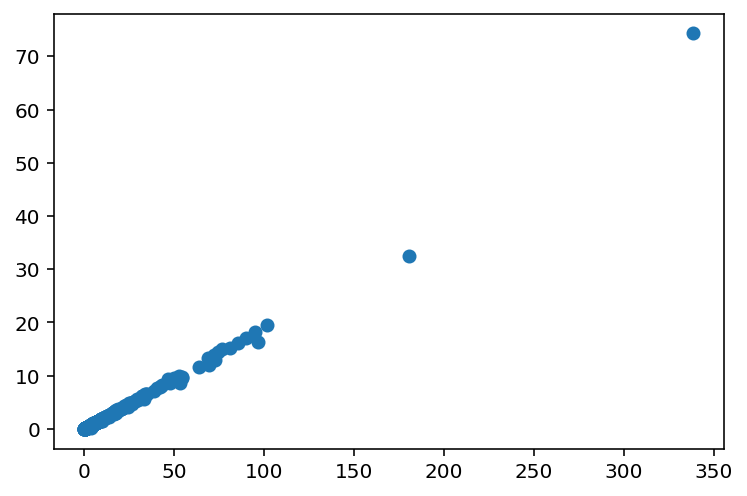

In [153]:
# #Check correlations of means
# #pbmc_10k_v3_Monocytes/Bursty_Poisson_10x11/

# #test_fit = monod.analysis.load_search_results('./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k3/Bursty_Poisson_1x1/grid_point_0.gp')
# test_fit = grid_point_results[1]
# test_raw = monod.analysis.load_search_data('./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Monocytes/raw.sd')


# monod_mu = test_fit.param_estimates[:,0,1] - test_fit.param_estimates[:,2,1]
# means = np.mean(test_raw.layers[1,:,:],axis=1)

# plt.scatter(10**monod_mu,means)
# # 



/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


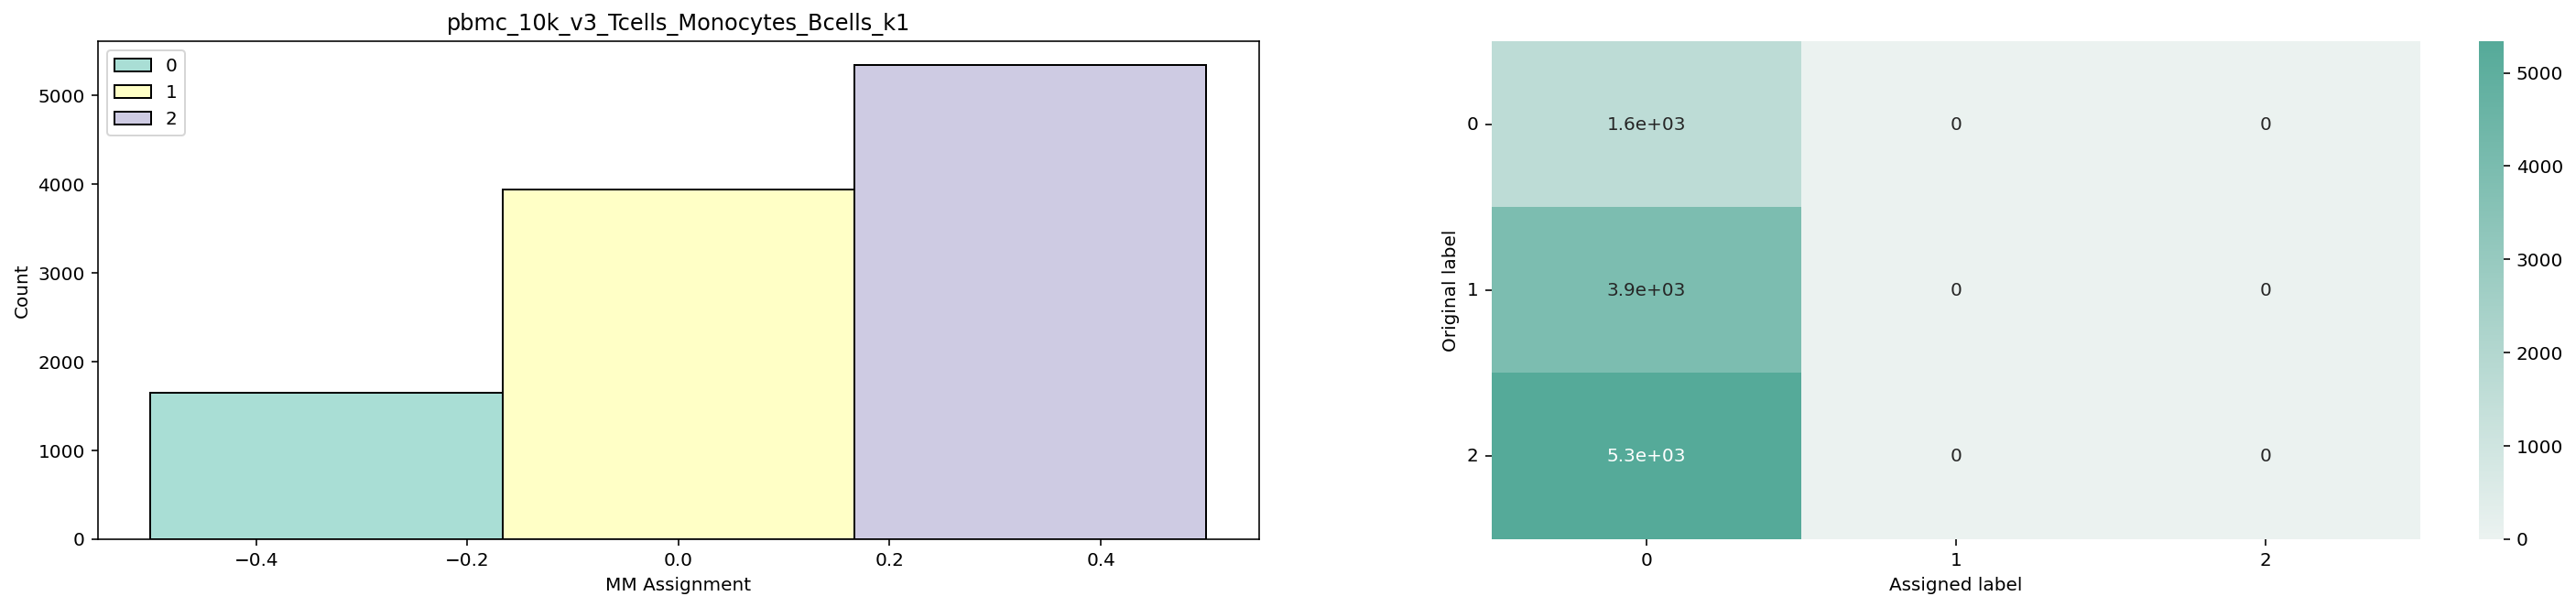

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


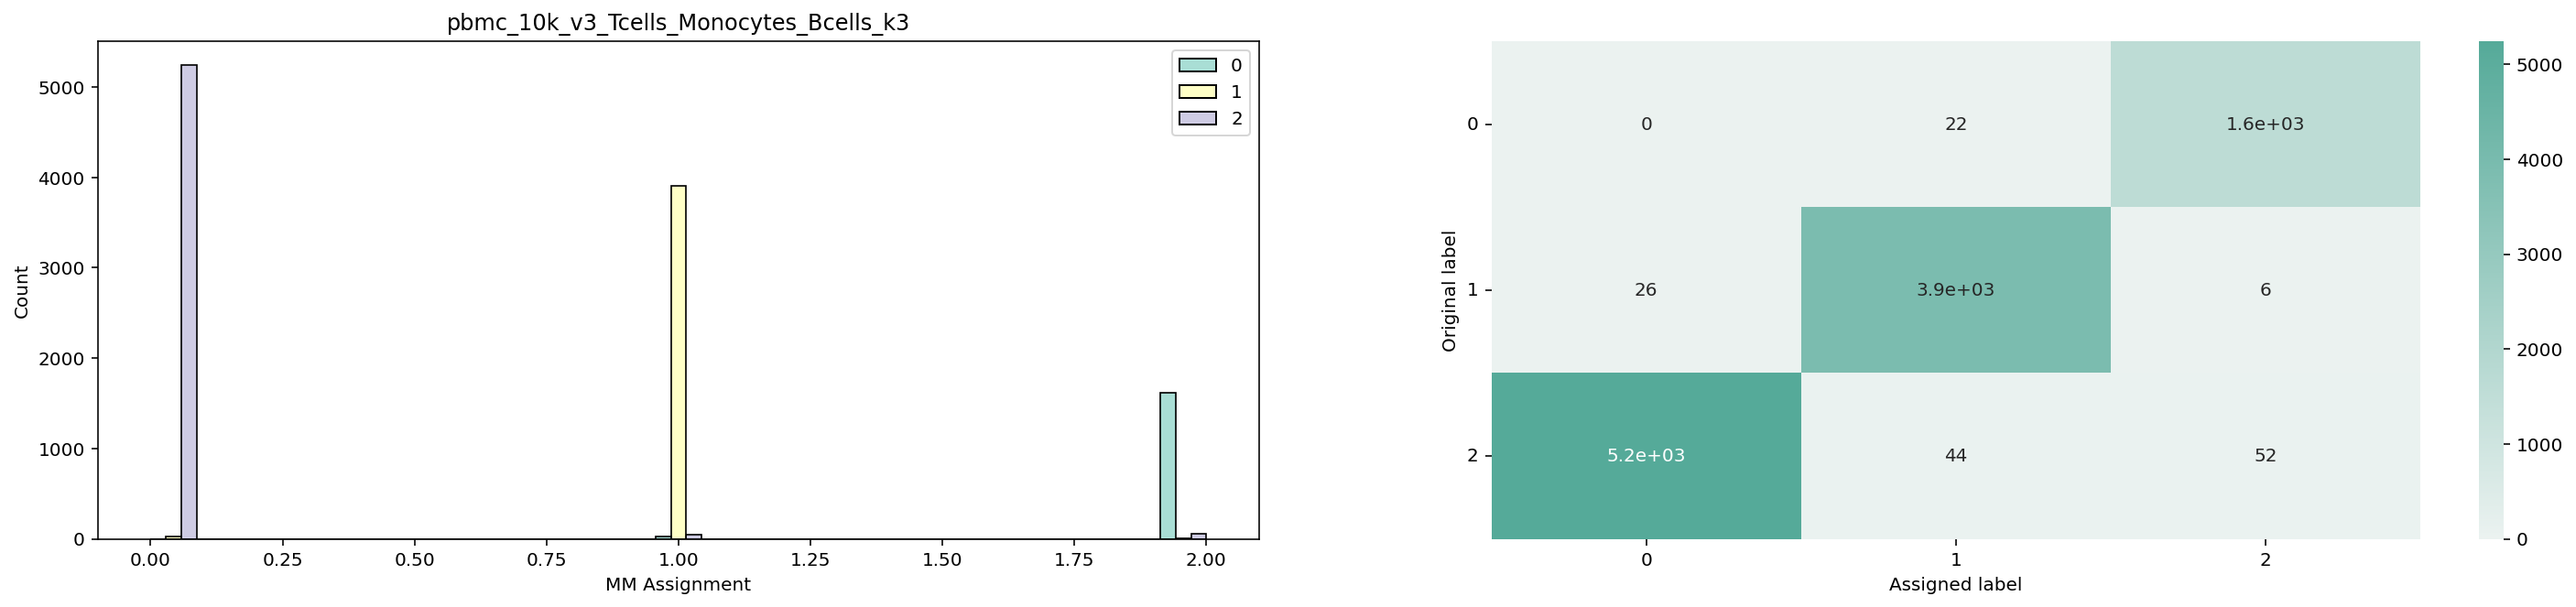

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


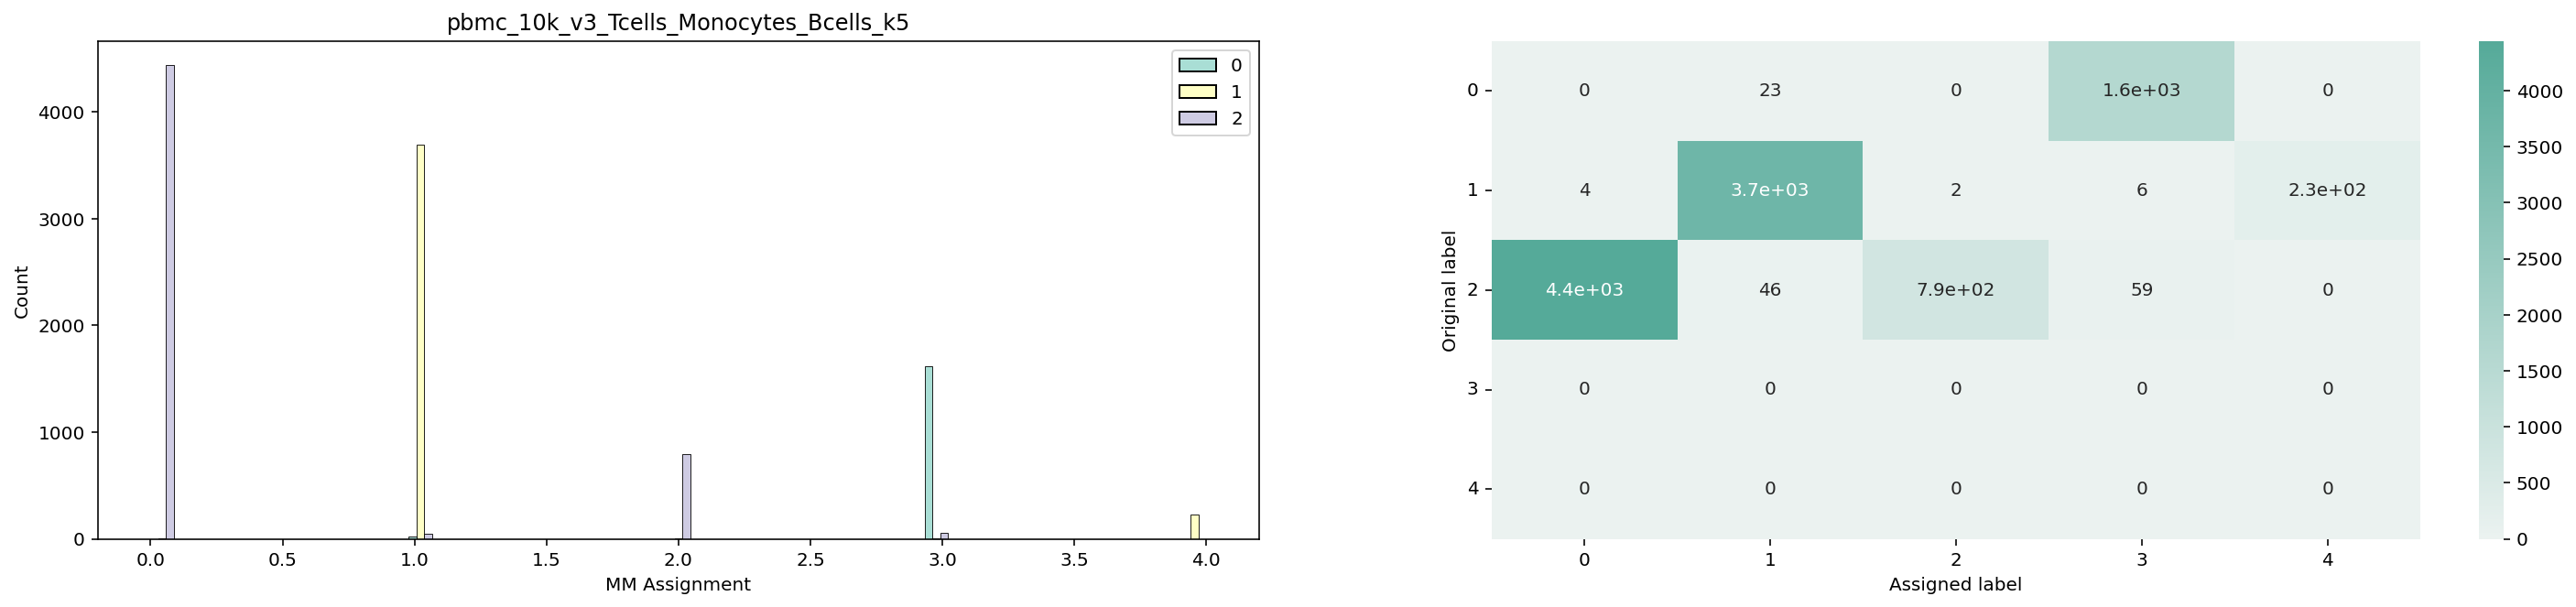

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(6, 6)
(6, 6)
(6, 6)


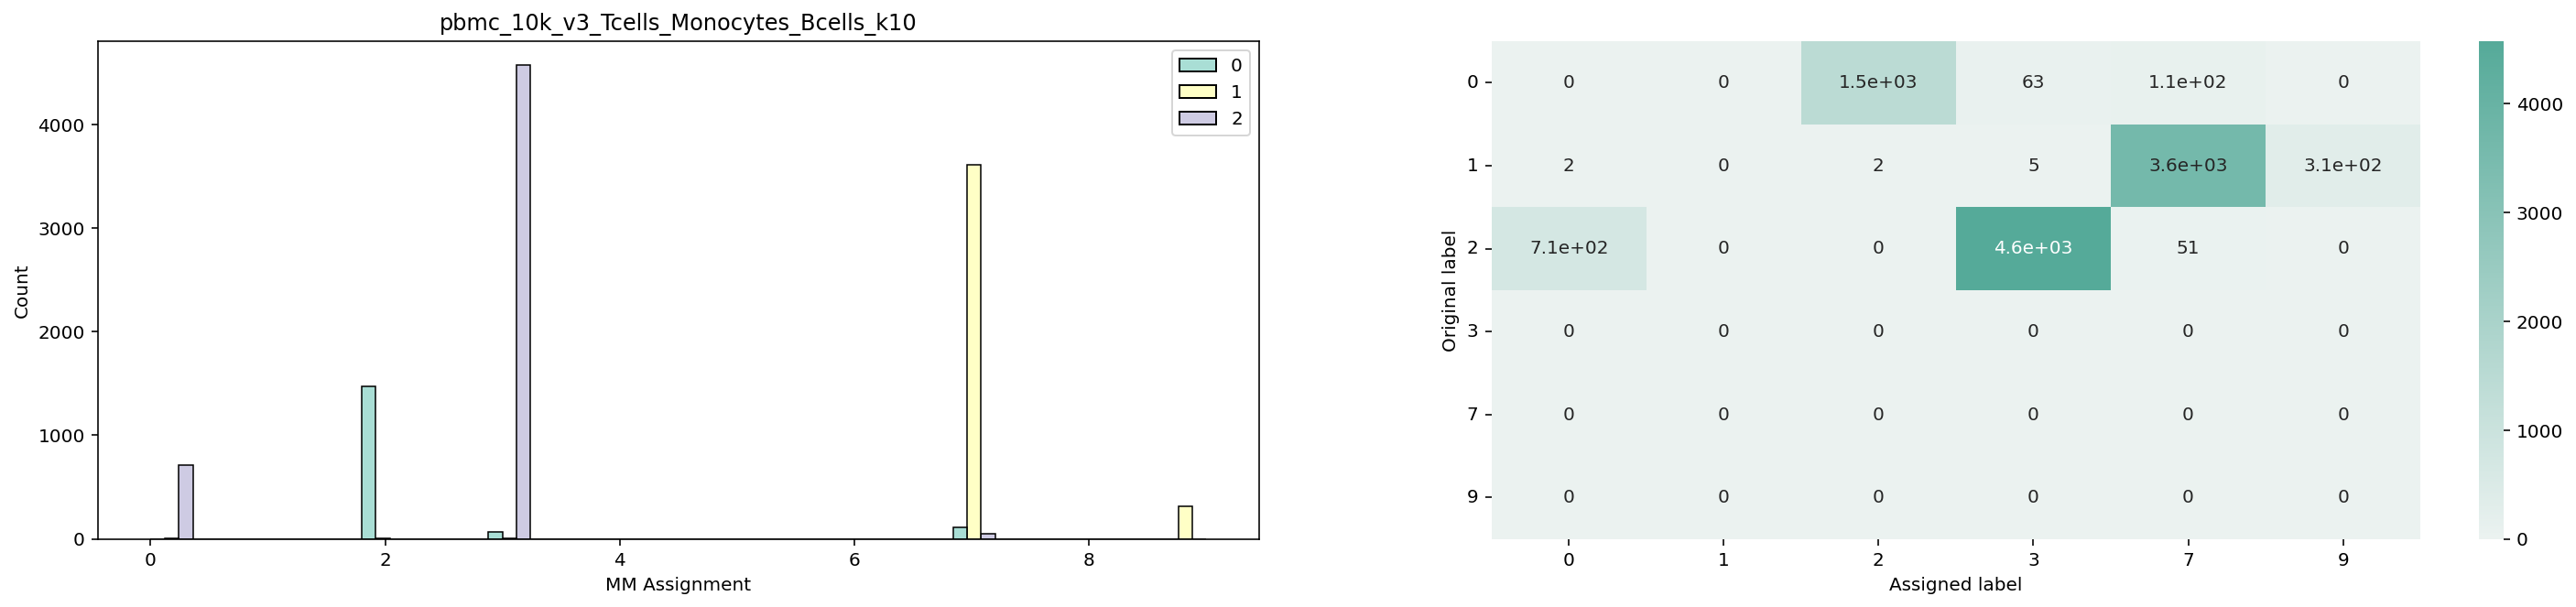

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(6, 6)
(6, 6)
(6, 6)


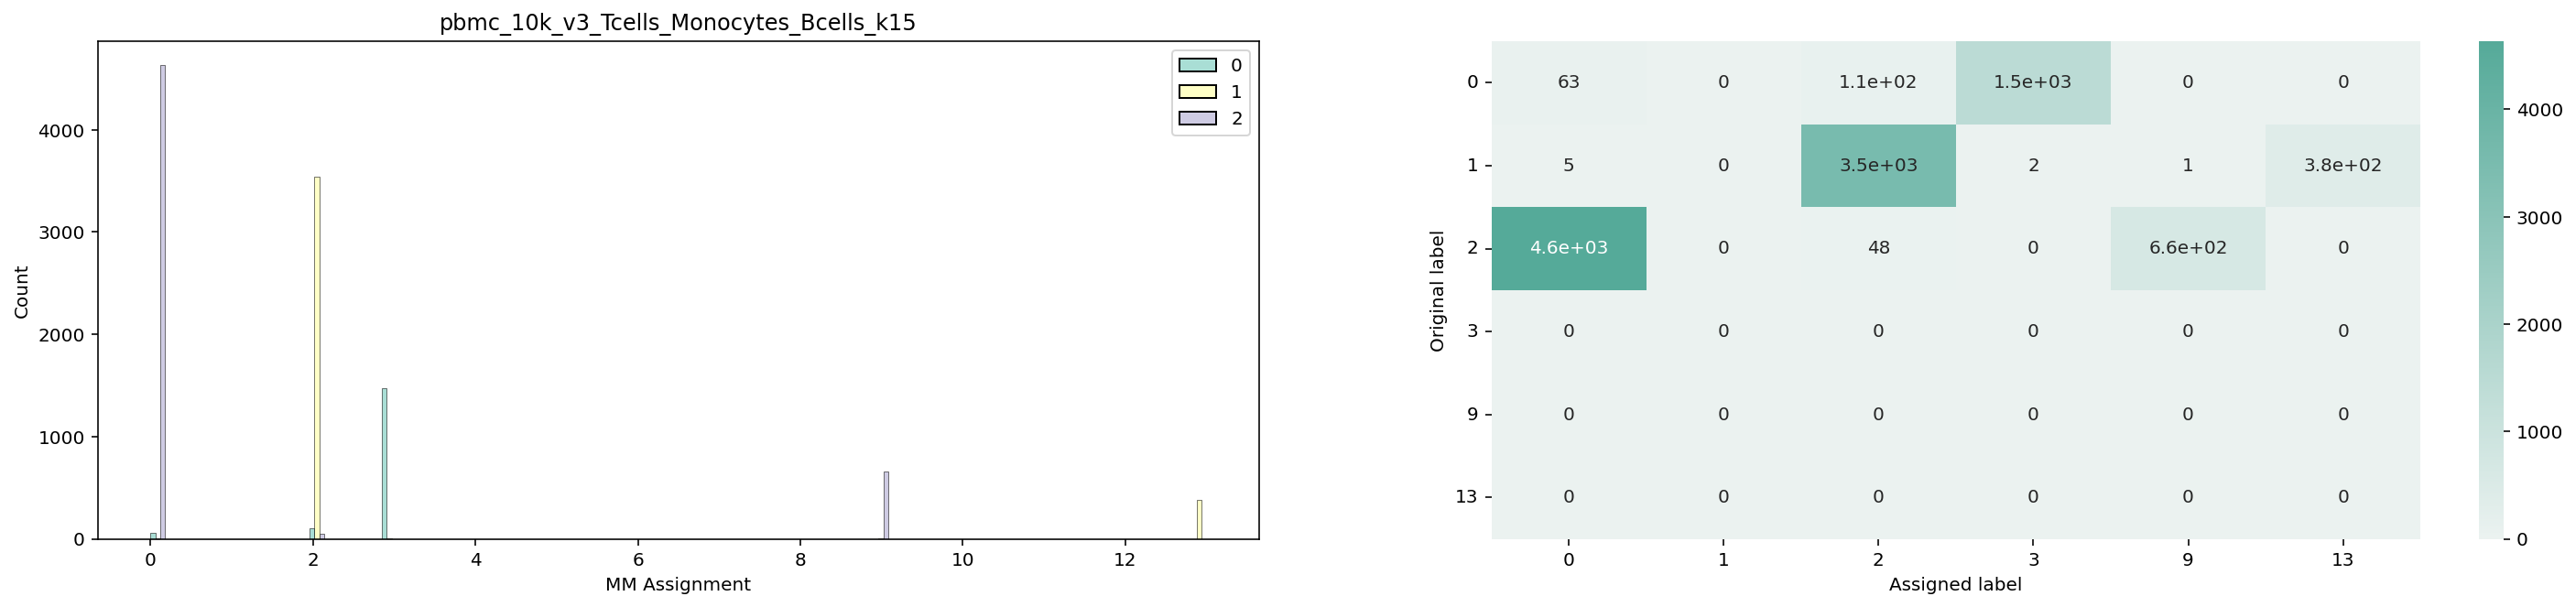

In [684]:
for i in range(len(grid_point_results)):
    r = grid_point_results[i]
    title = r.inference_string.replace('./fits/gg_230501_025_pbmc_MM_1/','') #g_230426_025_pbmc_MM_1
    title = title.replace('/Bursty_Poisson_1x1','')
    vis_assign(np.array(new_assigns),r.assigns,title,figsize=(25, 5))


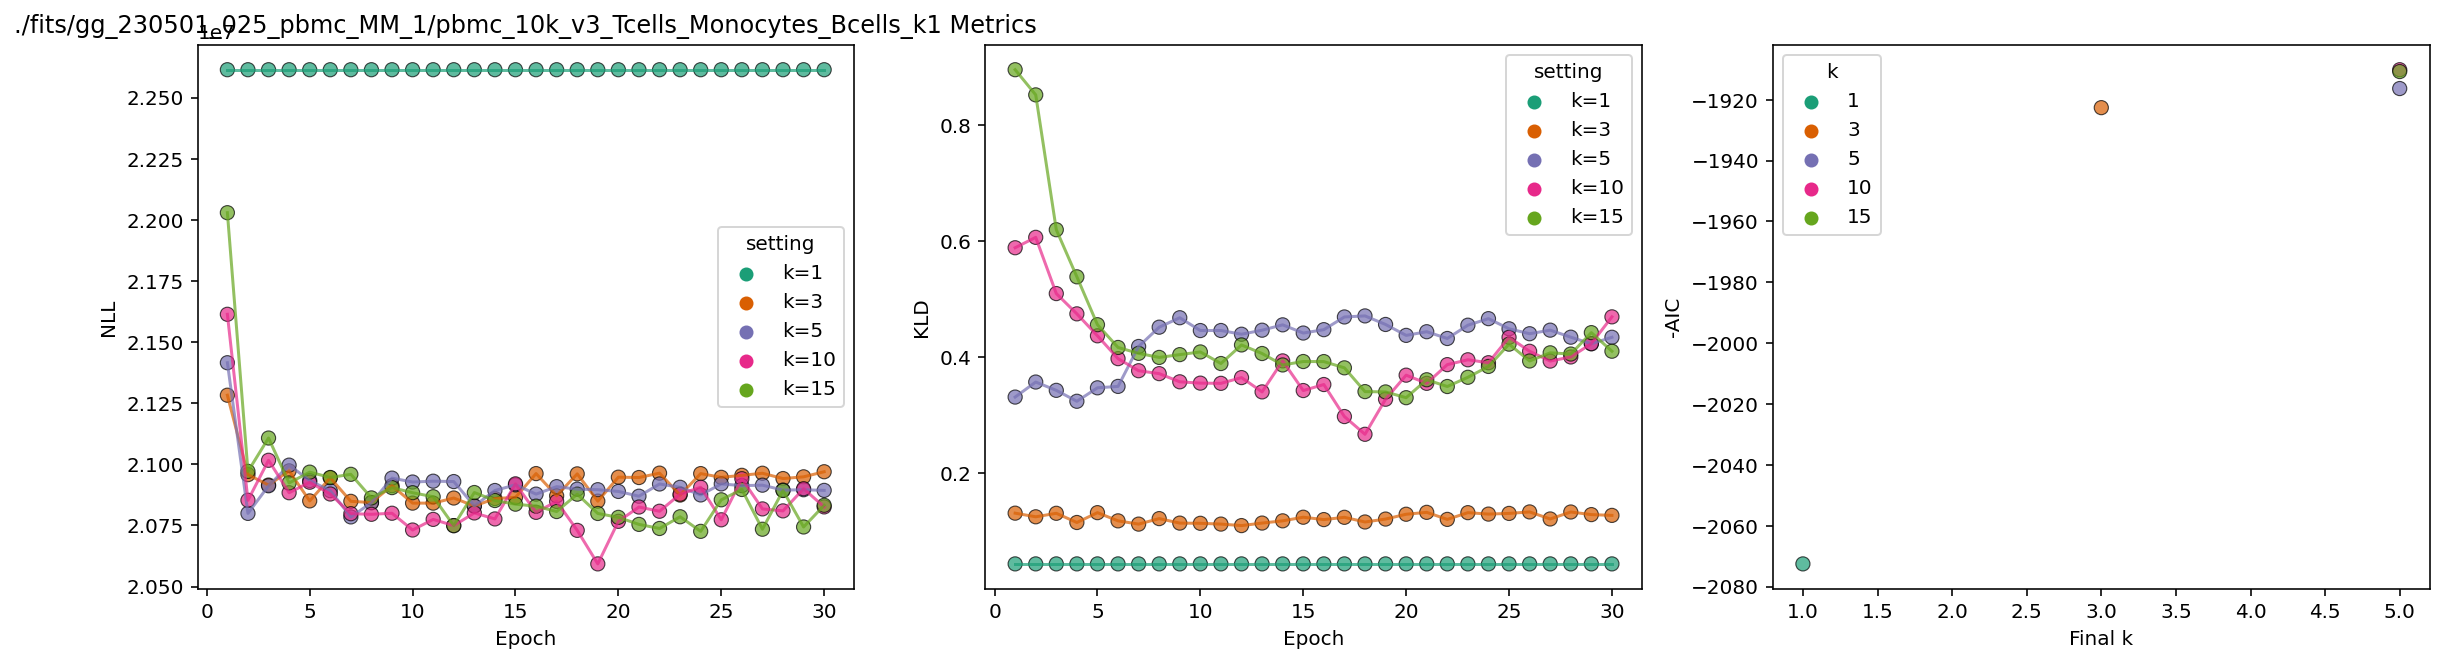

In [685]:
for i in range(0, len(grid_point_results), num_ks):
    r = grid_point_results[i:i+num_ks]
    title = dataset_strings[i]+' Metrics'
    vis_metrics(r,title,ks[0:num_ks],figsize=(20,5))

In [ ]:
for i in range(len(grid_point_results)):
    r = grid_point_results[i]
    all_groups_kmeans += [r.assigns]



In [ ]:
len(all_groups_kmeans)

In [ ]:
#Compare assignments to k-means inits
#compare overlap of all k-means assignments

num_per_set = num_ks

pairs = [(0,3),(1,3),(2,3)]
labs = [('Spliced','MM'),('Unspliced','MM'),('Both','MM')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(50,40))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups_kmeans[p[1]*(num_per_set)+i]
        true = all_groups_kmeans[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=True, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j])
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)

        ax[i,j].set_ylabel(labs[j][0])
        ax[i,j].set_xlabel(labs[j][1])

    
plt.show()


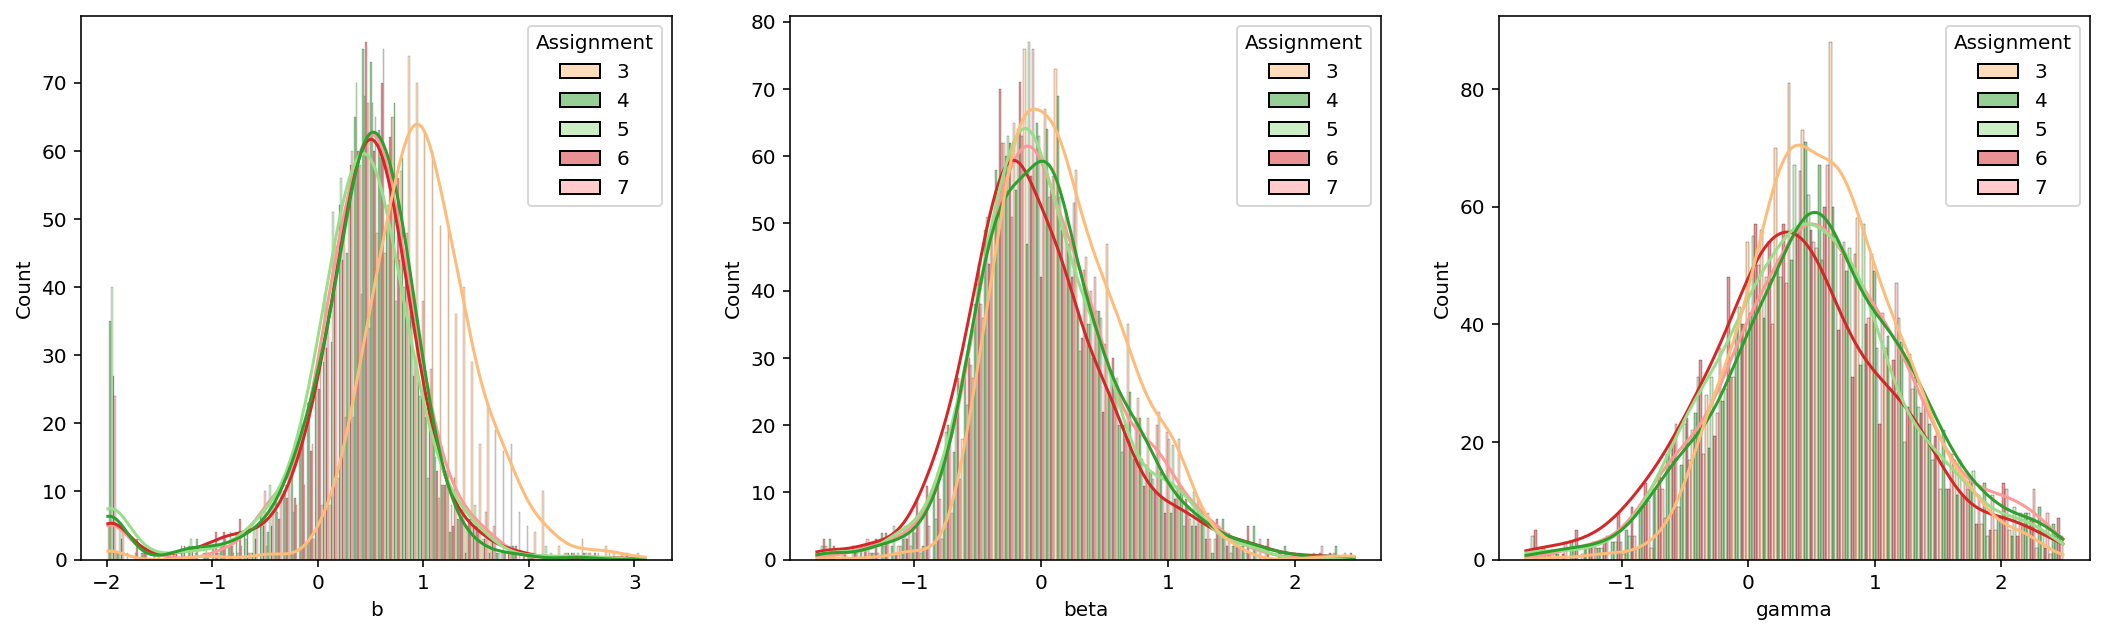

In [425]:
res = vis_params(grid_point_results[-2].param_estimates,assigns_toplot = [3,4,5,6,7],title='')

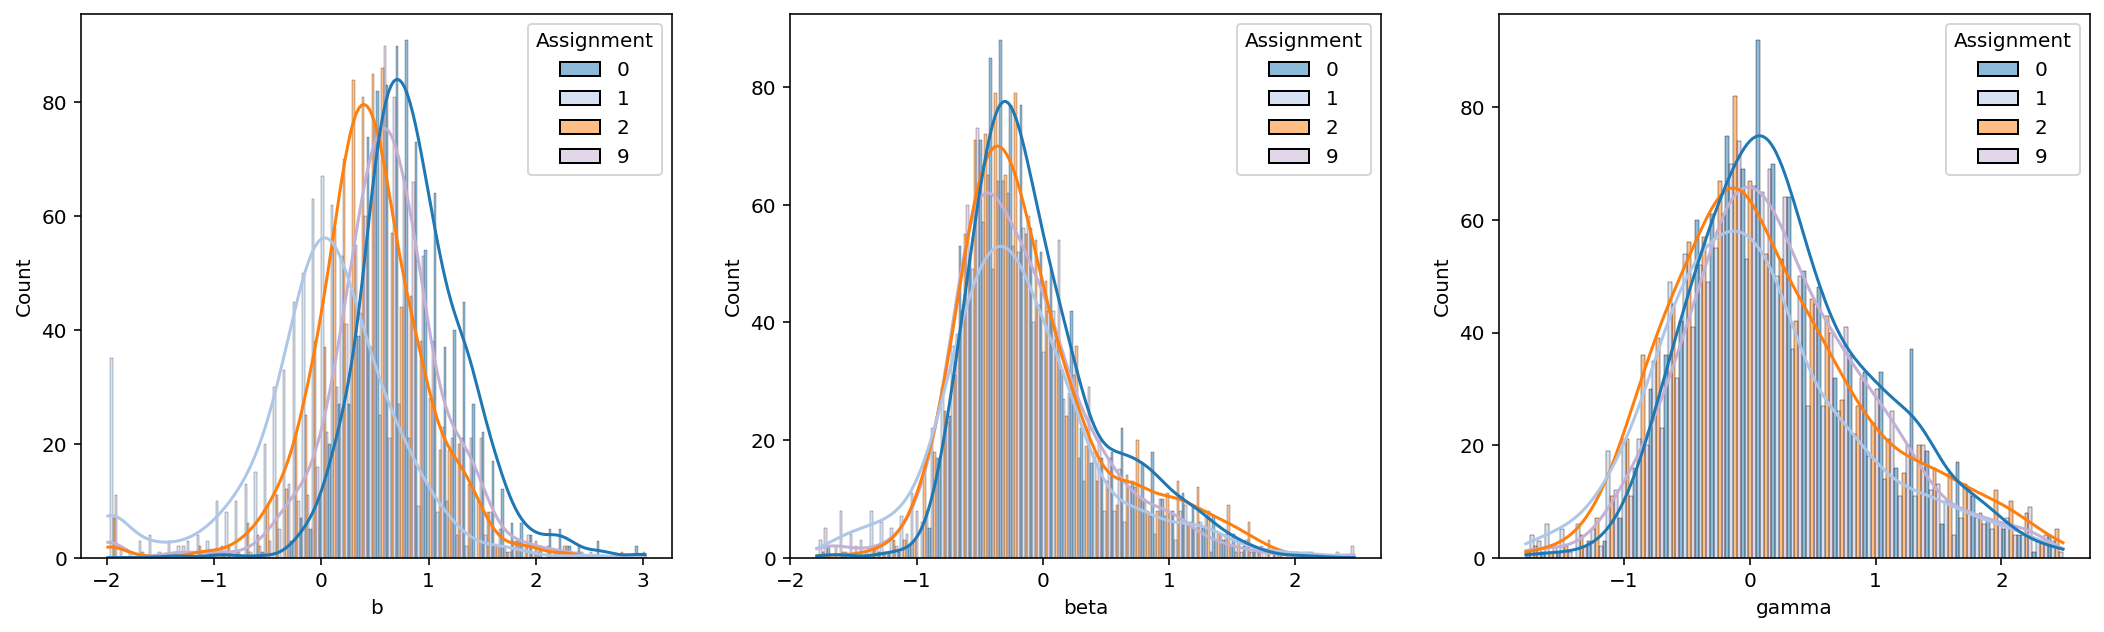

In [423]:
res = vis_params(grid_point_results[-2].param_estimates,assigns_toplot = [0,1,2,9],title='')

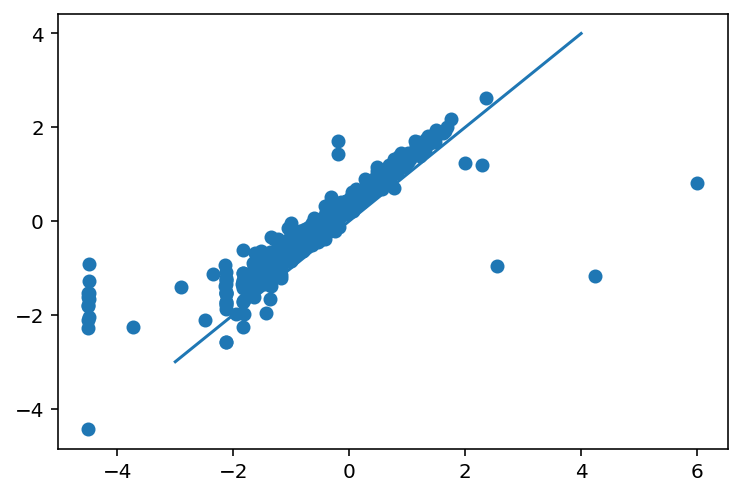

In [480]:
plt.scatter(grid_point_results[-2].param_estimates[:,0,1]-grid_point_results[-2].param_estimates[:,2,1],
            grid_point_results[-2].param_estimates[:,0,2]-grid_point_results[-2].param_estimates[:,2,2])
plt.plot(range(-3,5),range(-3,5))

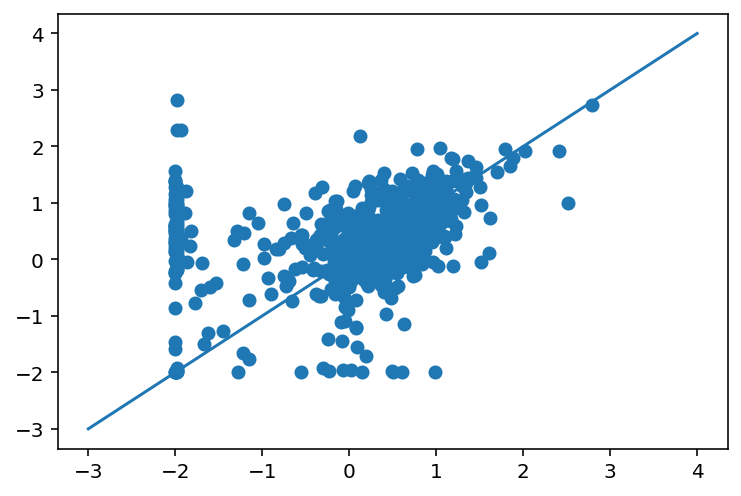

In [422]:
plt.scatter(grid_point_results[-2].param_estimates[:,0,4],grid_point_results[-2].param_estimates[:,0,2])
plt.plot(range(-3,5),range(-3,5))

In [ ]:
#Read in known marker genes + annots from Cell Atlas (Angel/Sina)

In [86]:
full_annots = pd.read_csv('/home/tchari/metadata/pbmc_markers_merchan.txt',sep='\t',header=None)
full_annots.head()

0  \
0              AXL+, SIGLEC6+ dendritic cell   
1                           Activated B cell   
2  Activated CD4-positive, alpha-beta T cell   
3                           Activated T cell   
4           Activated effector memory T cell   

                                                   1  
0  COQ7,CDKN1A,NDRG1,BAIAP2,PIM2,PLAAT3,KLF12,MGL...  
1                              KRT20,CD19,MS4A1,CD27  
2                                              IL-7R  
3            CD38,ICOS,HLA-DRA,IL2RA,ISG20,PRF1,CD3D  
4  CXCR6,CCR4,BTLA,ICOS,TBX21,GZMA,HLA-DRA,HLA-DR...

In [156]:
check_names = search_data.gene_names

all_annots = []
for n in check_names:
    annots = []
    for i in range(len(full_annots[1])):
        
        if n in full_annots[1][i]:
            annots += [full_annots[0][i]]
    all_annots += [annots]
            
name_annot_dict = dict(zip(check_names,all_annots))
        

In [158]:
inds = []
for i in range(len(all_annots)):
    if len(all_annots[i])<4:
        #if all_annots[i] == ['B cell'] or all_annots[i] == ['Myeloid cell'] or all_annots[i] == ['T cell']:
        inds += [i]
len(inds)

932

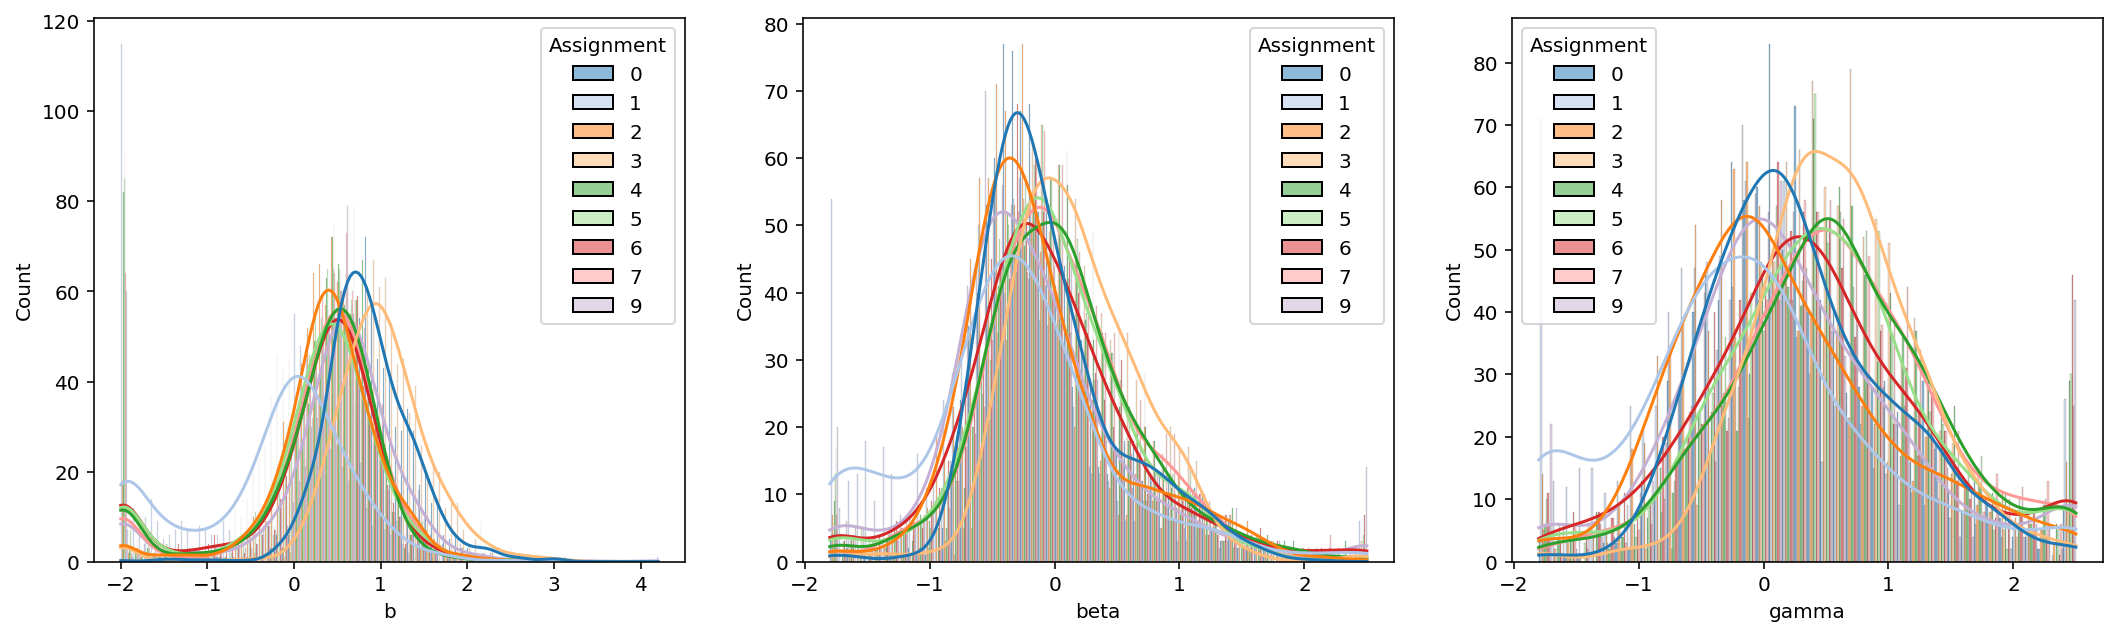

In [461]:
res = vis_params(grid_point_results[-2].param_estimates,assigns_toplot = [0,1,2,3,4,5,6,7,9],title='',to_filt=False)

In [541]:
toplot_marks = ['CD300E','FCGR2B','CD40',
                'CD69','MS4A1','CD79A','PTPRC',
                'CD3D','IL7R','LEF1','TRAC','CD4','CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5',
      'CD93','CSTA','FPR1','CD14','CD36',
      'CD79A','CD22','BLK','IGHD','VPREB3','CD28','IRF4','CCR6','GATA3','IL2RA','FOXP1','CD38',
               'CX3CR1','CD86','ADGRE1'] + ['CD14','FCGR3A','FCGR3B','CCR2','CCR5','CCR7',
'CD69','ITGAE','CTLA4','NCAM1','FOXP3','STAT4', 'TCF7','IL26',
'IL22','IL13','KLRB1','CXCR3','CD38',
'CLEC9A','ITGAX','XCR1','CD1C','CD207','ITGAM', 'NOTCH2',
'BATF3','CCR7','CD8A','CD8B',
'BCL2','BCL6','CD5','CD27','CD79B','SDC1','TLR9','XBP1','GZMB','IL3RA','CD74',
'IL7R', 'CCR7','LYZ','S100A4','GNLY', 'NKG7','FCER1A', 'CST3','PPBP','PF4']


toplot_marks = np.unique(toplot_marks)

In [542]:
inds = [list(check_names).index(i) for i in toplot_marks if i in check_names]

In [514]:
toshape = np.array(res['b']-res['gamma'])
toshape = toshape.reshape([9,1000])
toshape.shape

toshape = toshape[:,inds]


In [515]:
df = pd.DataFrame(toshape.T)
df.index = check_names[inds]


df.head()

0         1         2         3         4         5         6  \
ADGRE1  0.282096 -0.299420  0.211720 -0.825739 -1.925164 -2.337355 -2.011165   
BCL2    0.130755 -1.101482 -0.513134  0.480872  0.151274  0.223566 -0.211849   
CCR6   -0.357466 -1.832015 -1.379418  0.127441  0.122076 -0.043502 -1.568925   
CD2     0.582112 -0.995206 -0.493247  1.022405 -1.212429  0.827101  0.507462   
CD22   -0.060821 -1.286780 -1.169074  0.396104  0.703693 -1.639446 -1.572874   

               7         8  
ADGRE1 -0.948811  0.710899  
BCL2    0.411982 -0.877052  
CCR6   -0.276413 -1.193490  
CD2     0.908993 -1.040888  
CD22   -1.585785 -0.488655

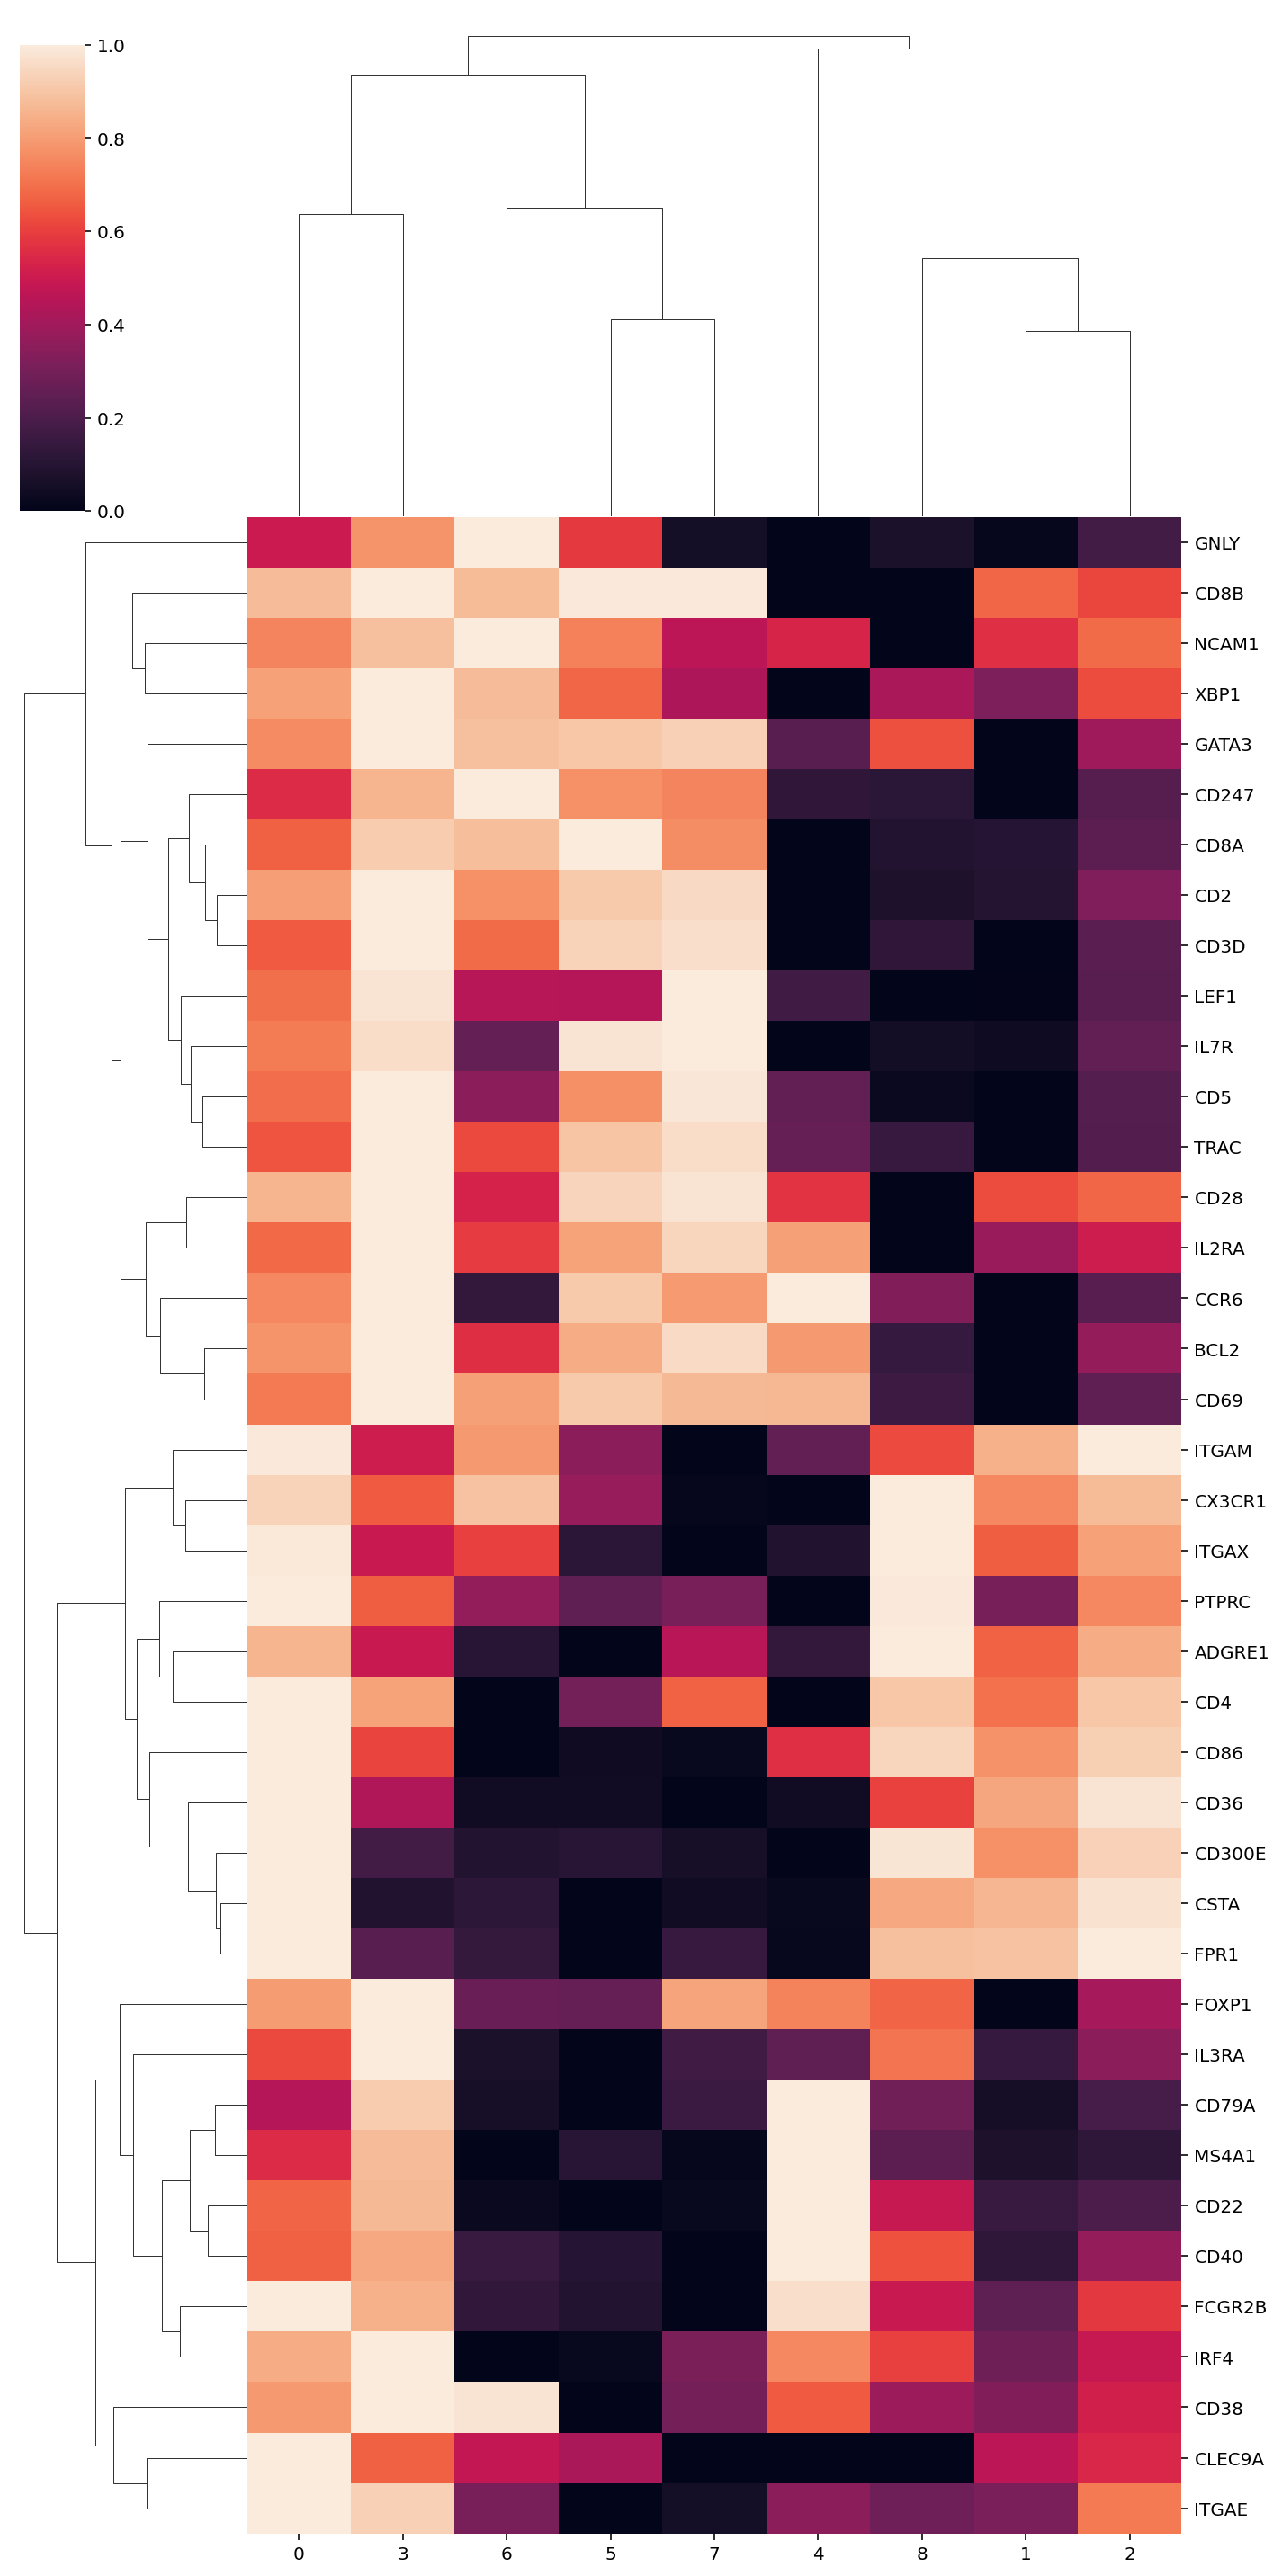

In [516]:
sns.clustermap(df,figsize=(10,20),standard_scale=0)

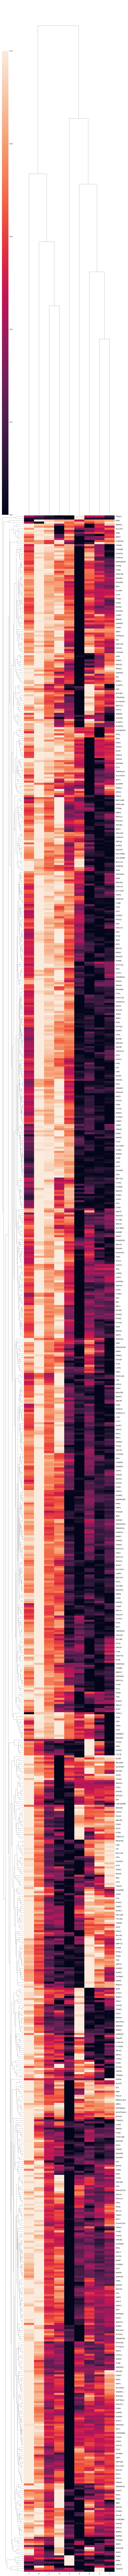

In [517]:
toshape = np.array(res['b']-res['gamma'])
toshape = toshape.reshape([9,1000])
toshape.shape


df = pd.DataFrame(toshape.T)
df.index = check_names


df.head()

sns.clustermap(df,figsize=(10,200),standard_scale=0)

In [297]:
'IL3RA' in check_names

True

In [686]:
#From raw spliced

# s = ds.layers['spliced'][:,:] #genexcell
# u = ds.layers['unspliced'][:,:]
# g_names = ds.ra['gene_name']

# tocheck = ['CD14','FCGR3A','FCGR3B','CCR2','CCR5','CCR7',
# 'CD69','ITGAE','CTLA4','NCAM1','FOXP3','STAT4', 'TCF7','IL26',
# 'IL22','IL13','KLRB1','CXCR3','CD38',
# 'CLEC9A','ITGAX','XCR1','CD1C','CD207','ITGAM', 'NOTCH2',
# 'BATF3','CCR7','CD8A','CD8B',
# 'BCL2','BCL6','CD5','CD27','CD79B','SDC1','TLR9','XBP1','GZMB','IL3RA','CD74']

# tocheck = list(np.unique(tocheck))+list(toplot_marks)

inds = [list(g_names).index(i) for i in toplot_marks if i in g_names]



In [687]:
#Mean per gene for all genes before filtering
raw_clus = s[:,cf[0]].T
print(raw_clus.shape)

# tots = np.sum(raw_clus,axis=1)
# divids = (1e4/tots)[:,None]
# raw_clus = raw_clus*divids
# raw_clus = np.log1p(raw_clus)
print(raw_clus.shape)

assigned = np.unique(grid_point_results[-2].assigns)
mean_g = np.zeros((len(assigned),raw_clus.shape[1]))

for i in range(len(assigned)):
    f = grid_point_results[-2].assigns == assigned[i]
    
    mean_g[i,:] = np.mean(raw_clus[f,:],axis=0)

(10913, 36601)
(10913, 36601)


In [550]:
len(np.unique(toplot_marks))

81

In [545]:
len([i for i in toplot_marks if i in filt_markers])

69

In [546]:
len([i for i in toplot_marks if i in search_data.gene_names])

40

In [520]:
# inds = [list(g_names).index(i) for i in check_names if i in g_names]

In [688]:

df = pd.DataFrame(np.log1p(mean_g[:,inds].T))
df.index = g_names[inds]


df.head()

0         1         2         3         4
CD300E  0.026263  0.012834  0.018138  1.094005  0.549063
FCGR2B  0.012526  0.346906  0.015173  0.145820  0.006369
CD40    0.023530  0.535933  0.029283  0.097213  0.006369
CD69    0.787311  0.913159  0.992390  0.262099  0.028348
MS4A1   0.037118  1.970468  0.185045  0.282897  0.015848

<AxesSubplot:>

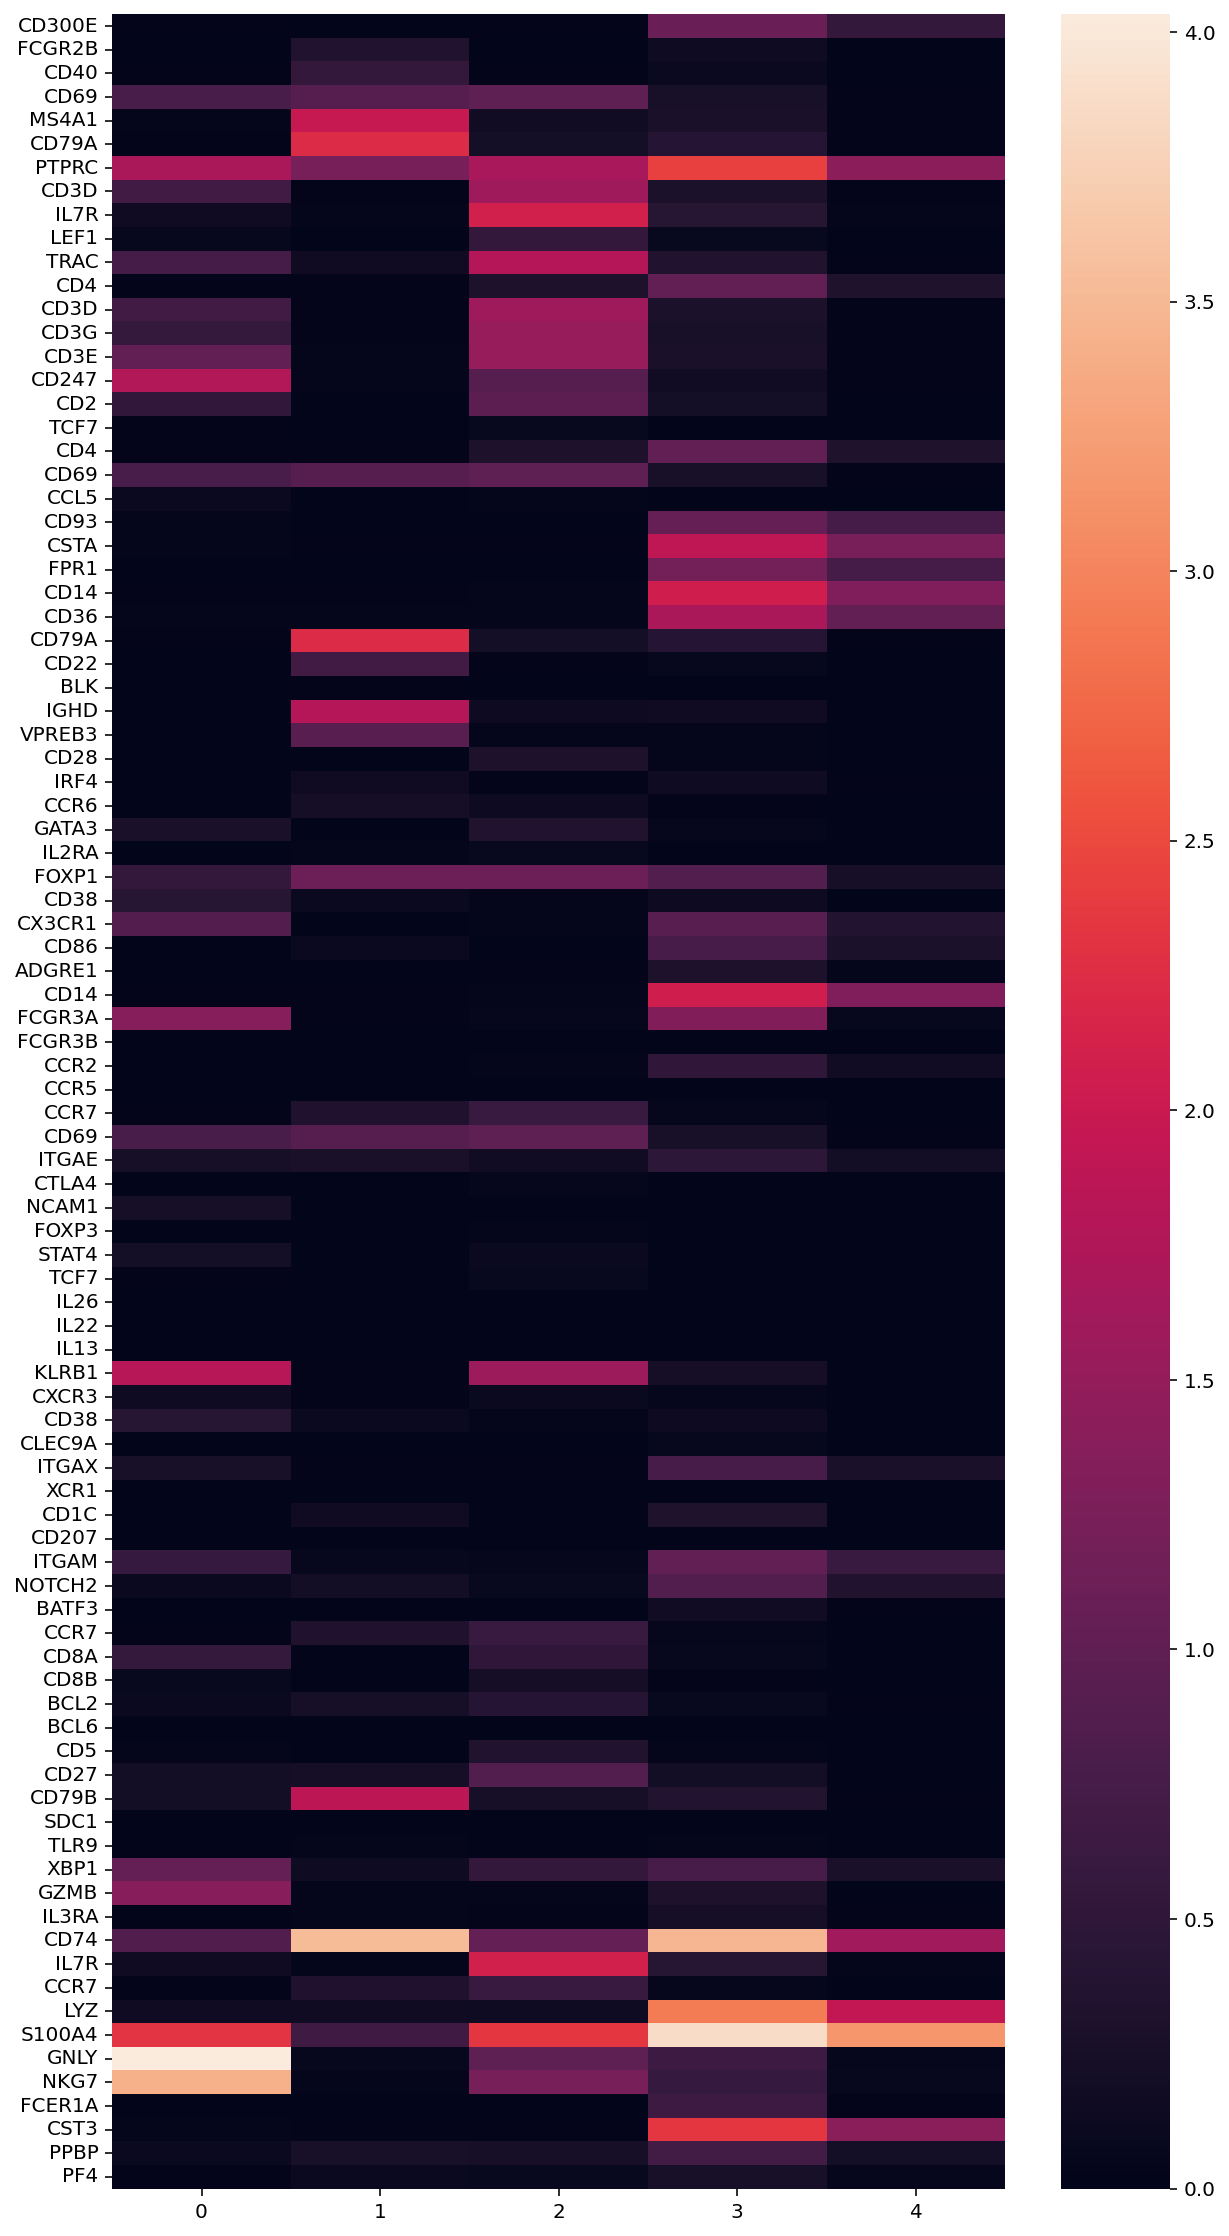

In [689]:
plt.figure(figsize=(10,20))
sns.heatmap(df)

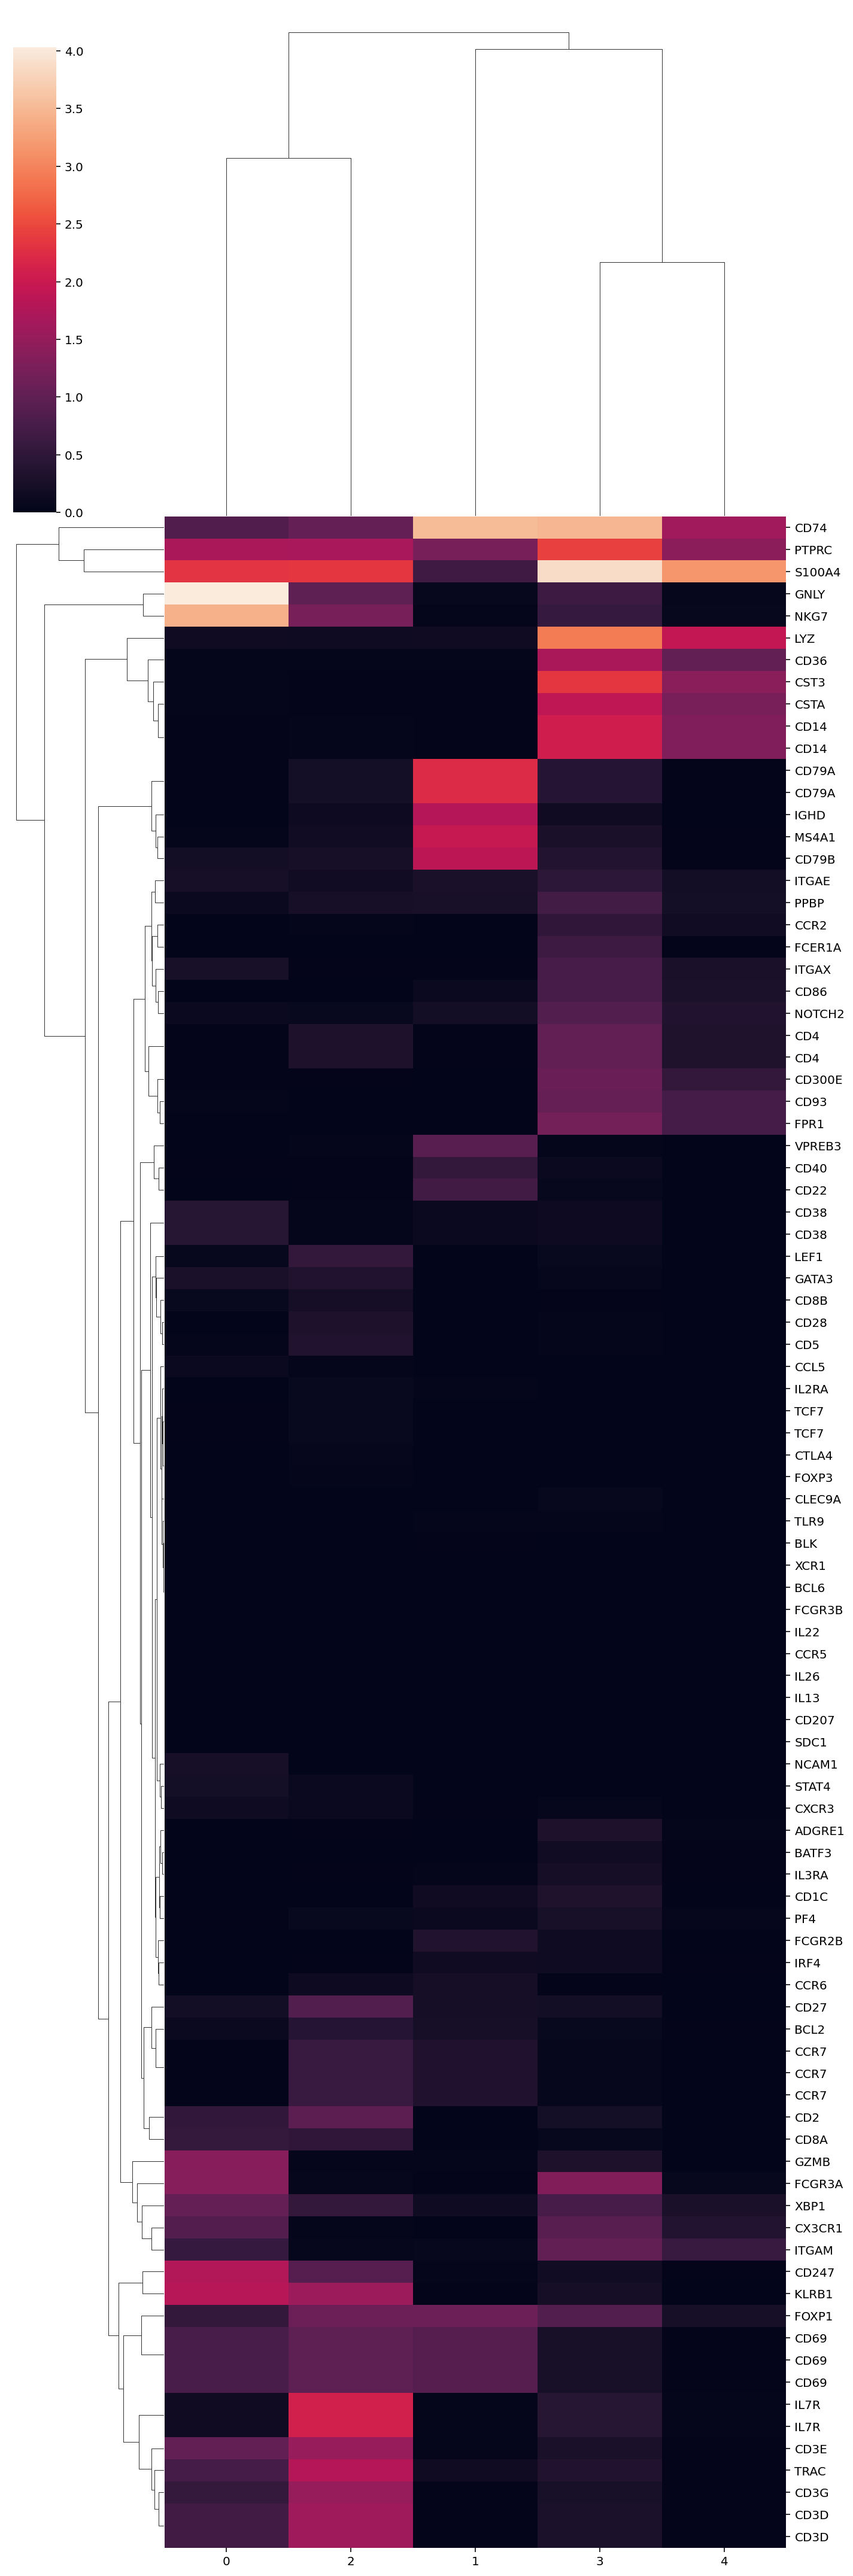

In [690]:
sns.clustermap(df,figsize=(10,30))

In [508]:
#check if 'b-cells' in cluster 3 actually misclassified t-cells (0-bcells, 2-tcells), cluster 4 all b-cells
search_data = monod.extract_data.extract_data(loom_filepaths[0], transcriptome_filepath, dataset_names[0],
                dataset_strings[0], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[0])

U = search_data.layers[0,:,:]
U_t = U.T
S = search_data.layers[1,:,:]
S_t = S.T

#S_t = U_t

tots = np.sum(S_t,axis=1)+1
divids = (1e4/tots)[:,None]
S_t = S_t*divids
S_t = np.log1p(S_t)

S=S_t.T

cell_filt = (np.array(all_assigns)=='Bcells') & (grid_point_results[1].assigns == 2) 
sml_bcell = S[:,cell_filt]
sml_bcell = np.var(sml_bcell,axis=1)
print(sml_bcell.shape)

cell_filt = (np.array(all_assigns)=='Tcells') & (grid_point_results[1].assigns == 2) 
tcell = S[:,cell_filt]
tcell = np.var(tcell,axis=1)
print(tcell.shape)

cell_filt = (np.array(all_assigns)=='Bcells') & (grid_point_results[1].assigns == 2) 
big_bcell = S[:,cell_filt]
big_bcell = np.var(big_bcell,axis=1)
print(big_bcell.shape)

cell_filt = (np.array(all_assigns)=='Tcells') & (grid_point_results[1].assigns == 0) 
big_tcell = S[:,cell_filt]
big_tcell = np.var(big_tcell,axis=1)
print(big_tcell.shape)


INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells_Monocytes_Bcells_k1
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230426_025_pbmc_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230426_025_pbmc_MM_1/pbmc_10k_v3_Tcells_Monocytes_Bcells_k1/raw.sd.
(1000,)
(1000,)
(1000,)
(1000,)


In [509]:
np.corrcoef(sml_bcell,big_bcell)

array([[1., 1.],
       [1., 1.]])

In [510]:
np.corrcoef(sml_bcell,tcell)

array([[1.        , 0.67468029],
       [0.67468029, 1.        ]])

In [511]:
np.corrcoef(big_tcell,tcell)

array([[1.        , 0.78577856],
       [0.78577856, 1.        ]])

### **Find Parameter-DE Genes**

i.e. genes 'DE' in any parameter, for now just looking at b and beta

In [ ]:
res_to_use = grid_point_results[-2] #params: gene x param x k

In [ ]:
assign